<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-25 19:35:33.965699: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-25 19:35:33.997299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-25 19:35:33.997327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-25 19:35:33.998357: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 19:35:34.003724: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-25 19:35:34.004243: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-25 19:35:34.758255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-25 19:35:37.147962: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

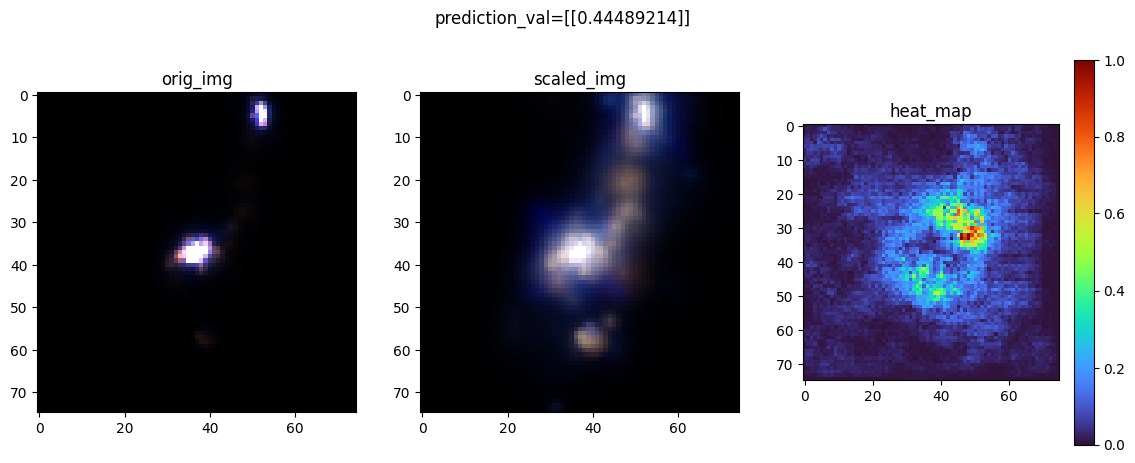

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

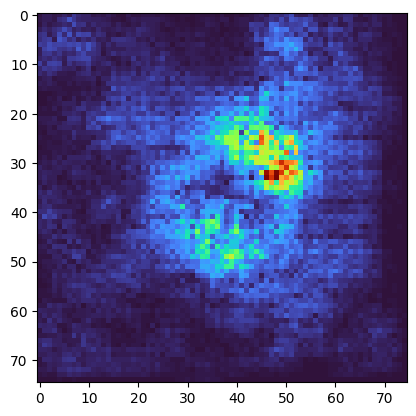

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-25 19:35:40.232560: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-25 19:35:41.067652: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-25 19:35:41.139486: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-25 19:35:41.183421: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-25 19:35:42.662476: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

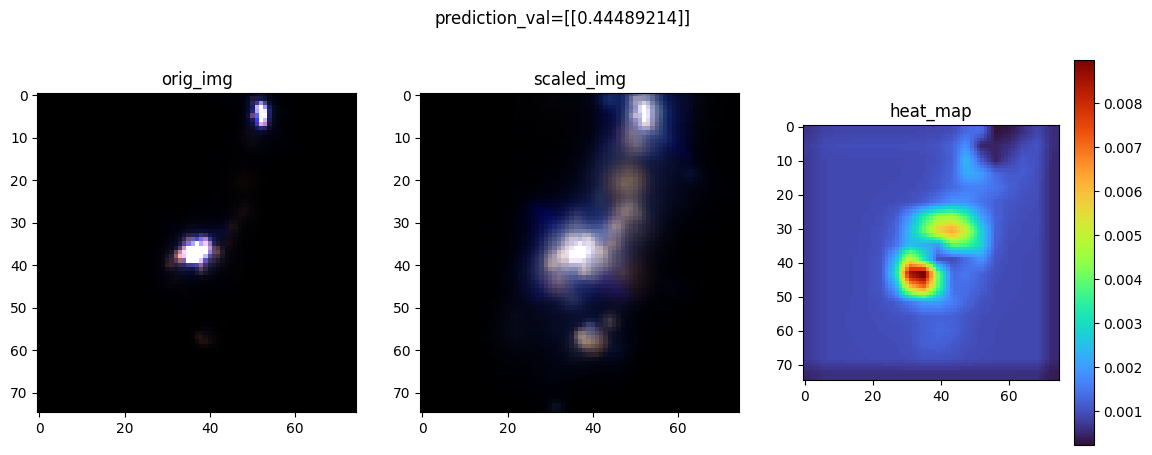

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

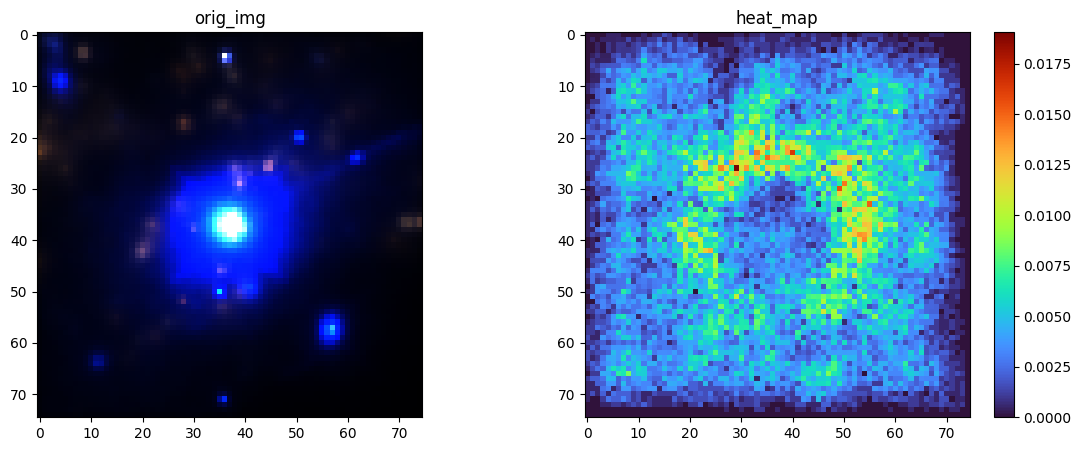

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:28 - loss: 0.7169 - accuracy: 0.4062

  2/338 [..............................] - ETA: 19s - loss: 0.7165 - accuracy: 0.4062 

  3/338 [..............................] - ETA: 19s - loss: 0.7166 - accuracy: 0.3958

  4/338 [..............................] - ETA: 19s - loss: 0.7147 - accuracy: 0.4219

  5/338 [..............................] - ETA: 19s - loss: 0.7125 - accuracy: 0.4500

  6/338 [..............................] - ETA: 18s - loss: 0.7102 - accuracy: 0.4844

  7/338 [..............................] - ETA: 18s - loss: 0.7105 - accuracy: 0.4732

  8/338 [..............................] - ETA: 18s - loss: 0.7108 - accuracy: 0.4609

  9/338 [..............................] - ETA: 18s - loss: 0.7100 - accuracy: 0.4688

 10/338 [..............................] - ETA: 18s - loss: 0.7098 - accuracy: 0.4656

 11/338 [..............................] - ETA: 18s - loss: 0.7100 - accuracy: 0.4574

 12/338 [>.............................] - ETA: 18s - loss: 0.7092 - accuracy: 0.4661

 13/338 [>.............................] - ETA: 18s - loss: 0.7089 - accuracy: 0.4663

 14/338 [>.............................] - ETA: 18s - loss: 0.7084 - accuracy: 0.4710

 15/338 [>.............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.4771

 16/338 [>.............................] - ETA: 18s - loss: 0.7074 - accuracy: 0.4824

 17/338 [>.............................] - ETA: 17s - loss: 0.7070 - accuracy: 0.4853

 18/338 [>.............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.4809

 19/338 [>.............................] - ETA: 17s - loss: 0.7068 - accuracy: 0.4786

 20/338 [>.............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.4781

 21/338 [>.............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.4792

 22/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.4773

 23/338 [=>............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.4783

 24/338 [=>............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.4714

 25/338 [=>............................] - ETA: 17s - loss: 0.7055 - accuracy: 0.4762

 26/338 [=>............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.4760

 27/338 [=>............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.4780

 28/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4821

 29/338 [=>............................] - ETA: 17s - loss: 0.7045 - accuracy: 0.4849

 30/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.4812

 31/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.4768

 32/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.4795

 33/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.4839

 34/338 [==>...........................] - ETA: 16s - loss: 0.7037 - accuracy: 0.4835

 35/338 [==>...........................] - ETA: 16s - loss: 0.7035 - accuracy: 0.4839

 36/338 [==>...........................] - ETA: 16s - loss: 0.7033 - accuracy: 0.4852

 37/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4840

 38/338 [==>...........................] - ETA: 16s - loss: 0.7031 - accuracy: 0.4819

 39/338 [==>...........................] - ETA: 16s - loss: 0.7031 - accuracy: 0.4776

 40/338 [==>...........................] - ETA: 16s - loss: 0.7029 - accuracy: 0.4789

 41/338 [==>...........................] - ETA: 16s - loss: 0.7027 - accuracy: 0.4794

 42/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4792

 43/338 [==>...........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4782

 44/338 [==>...........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.4787

 45/338 [==>...........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.4764

 46/338 [===>..........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.4769

 47/338 [===>..........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.4774

 48/338 [===>..........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.4792

 49/338 [===>..........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.4770

 50/338 [===>..........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.4750

 51/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.4730

 52/338 [===>..........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.4724

 53/338 [===>..........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.4729

 54/338 [===>..........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.4705

 55/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.4676

 56/338 [===>..........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.4682

 57/338 [====>.........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4709

 58/338 [====>.........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.4741

 59/338 [====>.........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.4767

 60/338 [====>.........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.4755

 61/338 [====>.........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.4780

 62/338 [====>.........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.4783

 63/338 [====>.........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.4807

 64/338 [====>.........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.4819

 65/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.4822

 66/338 [====>.........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.4830

 67/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.4837

 68/338 [=====>........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.4862

 69/338 [=====>........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.4860

 70/338 [=====>........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.4853

 71/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4855

 72/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4839

 73/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4820

 74/338 [=====>........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.4814

 75/338 [=====>........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.4804

 76/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.4811

 77/338 [=====>........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.4801

 78/338 [=====>........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4808

 79/338 [======>.......................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4794

 80/338 [======>.......................] - ETA: 14s - loss: 0.6995 - accuracy: 0.4812

 81/338 [======>.......................] - ETA: 14s - loss: 0.6994 - accuracy: 0.4819

 82/338 [======>.......................] - ETA: 14s - loss: 0.6994 - accuracy: 0.4817

 83/338 [======>.......................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4823

 84/338 [======>.......................] - ETA: 14s - loss: 0.6992 - accuracy: 0.4836

 85/338 [======>.......................] - ETA: 14s - loss: 0.6992 - accuracy: 0.4835

 86/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.4836

 87/338 [======>.......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.4831

 88/338 [======>.......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.4822

 89/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.4835

 90/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.4861

 91/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.4876

 92/338 [=======>......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.4881

 93/338 [=======>......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.4886

 94/338 [=======>......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.4894

 95/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.4901

 96/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.4909

 97/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.4926

 98/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.4933

 99/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.4953

100/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.4956

101/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.4957

102/338 [========>.....................] - ETA: 13s - loss: 0.6982 - accuracy: 0.4963

103/338 [========>.....................] - ETA: 13s - loss: 0.6982 - accuracy: 0.4954

104/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.4958

105/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.4976

106/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.4973

107/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.4971

108/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.4977

109/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.4983

110/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.4960

111/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.4958

112/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.4967

113/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.4978

114/338 [=========>....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.4967

115/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.4984

116/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.4981

117/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.4984

118/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4992

119/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.4995

120/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5005

121/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5013

122/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5005

123/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5000

124/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.4997

125/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5010

126/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5007

127/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.4995

128/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.4998

129/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5002

130/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5005

131/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5012

132/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5028

133/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5033

134/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5037

135/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5025

136/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5030

137/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5043

138/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5050

139/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5058

140/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5063

141/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5060

142/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5064

143/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5068

144/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5063

145/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5063

146/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5060

147/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5060

148/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5068

149/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5061

150/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5058

151/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5056

152/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5056

153/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5053

154/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5063

155/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5052

156/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5046

157/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5046

158/338 [=============>................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5042

159/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5045 

160/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5045

161/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5039

162/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5041

163/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5044

164/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5046

165/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5047

166/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5049

167/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5056

168/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5054

169/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5055

170/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5057

171/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5062

172/338 [==============>...............] - ETA: 9s - loss: 0.6961 - accuracy: 0.5053

173/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5060

174/338 [==============>...............] - ETA: 9s - loss: 0.6960 - accuracy: 0.5068

175/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5068

176/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5064

177/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5069

178/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5070

179/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5072

180/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5078

181/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5090

182/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5091

183/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5091

184/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5092

185/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5095

186/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5082

187/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5089

188/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5096

189/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5094

190/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5089

191/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5085

192/338 [================>.............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5091

193/338 [================>.............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5087

194/338 [================>.............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5093

195/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5095

196/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5089

197/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5094

198/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5090

199/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5091

200/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5092

201/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5089

202/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5084

203/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5089

204/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5089

205/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5091

206/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5090

207/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5094

208/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5089

209/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5090

210/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5088

211/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5089

212/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5091

213/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5087

214/338 [=================>............] - ETA: 6s - loss: 0.6952 - accuracy: 0.5083

215/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5086

216/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5091

217/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5092

218/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5100

219/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5106

220/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5109

221/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5102

222/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5104

223/338 [==================>...........] - ETA: 6s - loss: 0.6950 - accuracy: 0.5107

224/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5109

225/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5113

226/338 [===================>..........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5113

227/338 [===================>..........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5117

228/338 [===================>..........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5107

229/338 [===================>..........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5111

230/338 [===================>..........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5117

231/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5112

232/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5110

233/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5114

234/338 [===================>..........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5116

235/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5120

236/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5124

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5128

238/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5129

239/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5128

240/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5130

241/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5131

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5133

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5129

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5136

245/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5135

246/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5140

247/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5144

248/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5152

249/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5154

250/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5151

251/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5148

252/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5150

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5151

254/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5154

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5153

256/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5161

257/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5161

258/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5165

259/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5169

260/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5171

261/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5170

262/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5169

263/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5171

264/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5173

265/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5176

266/338 [======================>.......] - ETA: 4s - loss: 0.6938 - accuracy: 0.5177

267/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5172

268/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5170

269/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5168

270/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5168

271/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5165

272/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5168

273/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5168

274/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5168

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5166

276/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5161

277/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5162

278/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5163

279/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5164

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5165

281/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5171

282/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5170

283/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5168

284/338 [========================>.....] - ETA: 3s - loss: 0.6937 - accuracy: 0.5167

285/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5166

286/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5170

287/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5170

288/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5165

289/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5162

290/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5158

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5157

292/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5162

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5160

294/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5167

295/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5169

296/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5171

297/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5170

298/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5172

299/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5169

300/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5169

301/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5171

302/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5168

303/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5167

304/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5169

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5170

306/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5172

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5170

308/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5168

309/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5163

310/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5165

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5166

312/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5161

313/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5160

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5158

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5156

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5158

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5162

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5166

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5165

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5165

321/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5167

322/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5167

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5166

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5164

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5164

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5161

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5161

328/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5161

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5160

330/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5162

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5161

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5163

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5166

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5161

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5162

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5162

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5162

338/338 [==============================] - 22s 61ms/step - loss: 0.6933 - accuracy: 0.5163 - val_loss: 0.6902 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 19s - loss: 0.6888 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6890 - accuracy: 0.5156

  3/338 [..............................] - ETA: 18s - loss: 0.6910 - accuracy: 0.4896

  4/338 [..............................] - ETA: 18s - loss: 0.6917 - accuracy: 0.4922

  5/338 [..............................] - ETA: 18s - loss: 0.6925 - accuracy: 0.4812

  6/338 [..............................] - ETA: 18s - loss: 0.6924 - accuracy: 0.4844

  7/338 [..............................] - ETA: 18s - loss: 0.6929 - accuracy: 0.4821

  8/338 [..............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.4961

  9/338 [..............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5174

 10/338 [..............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5281

 11/338 [..............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5341

 12/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5417

 13/338 [>.............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5457

 14/338 [>.............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5357

 15/338 [>.............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5396

 16/338 [>.............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5430

 17/338 [>.............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5460

 18/338 [>.............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5417

 19/338 [>.............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5411

 20/338 [>.............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5359

 21/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5402

 22/338 [>.............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5369

 23/338 [=>............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5353

 24/338 [=>............................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5365

 25/338 [=>............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5412

 26/338 [=>............................] - ETA: 17s - loss: 0.6889 - accuracy: 0.5349

 27/338 [=>............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.5359

 28/338 [=>............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5413

 29/338 [=>............................] - ETA: 17s - loss: 0.6879 - accuracy: 0.5431

 30/338 [=>............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5406

 31/338 [=>............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5323

 32/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5332

 33/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5331

 34/338 [==>...........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5267

 35/338 [==>...........................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5232

 36/338 [==>...........................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5260

 37/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5220

 38/338 [==>...........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5247

 39/338 [==>...........................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5264

 40/338 [==>...........................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5250

 41/338 [==>...........................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5259

 42/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5216

 43/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5196

 44/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5199

 45/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5174

 46/338 [===>..........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5163

 47/338 [===>..........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5146

 48/338 [===>..........................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5111

 49/338 [===>..........................] - ETA: 16s - loss: 0.6911 - accuracy: 0.5083

 50/338 [===>..........................] - ETA: 16s - loss: 0.6910 - accuracy: 0.5094

 51/338 [===>..........................] - ETA: 15s - loss: 0.6910 - accuracy: 0.5092

 52/338 [===>..........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5060

 53/338 [===>..........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5065

 54/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5046

 55/338 [===>..........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5057

 56/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5039

 57/338 [====>.........................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5027

 58/338 [====>.........................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5022

 59/338 [====>.........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5032

 60/338 [====>.........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5052

 61/338 [====>.........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5051

 62/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5060

 63/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5060

 64/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5054

 65/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5053

 66/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5057

 67/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5079

 68/338 [=====>........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5087

 69/338 [=====>........................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5086

 70/338 [=====>........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5094

 71/338 [=====>........................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5084

 72/338 [=====>........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5078

 73/338 [=====>........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5086

 74/338 [=====>........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5101

 75/338 [=====>........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5100

 76/338 [=====>........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5099

 77/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5085

 78/338 [=====>........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5108

 79/338 [======>.......................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5127

 80/338 [======>.......................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5133

 81/338 [======>.......................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5120

 82/338 [======>.......................] - ETA: 14s - loss: 0.6905 - accuracy: 0.5130

 83/338 [======>.......................] - ETA: 14s - loss: 0.6904 - accuracy: 0.5132

 84/338 [======>.......................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5145

 85/338 [======>.......................] - ETA: 14s - loss: 0.6903 - accuracy: 0.5151

 86/338 [======>.......................] - ETA: 14s - loss: 0.6902 - accuracy: 0.5164

 87/338 [======>.......................] - ETA: 13s - loss: 0.6901 - accuracy: 0.5165

 88/338 [======>.......................] - ETA: 13s - loss: 0.6900 - accuracy: 0.5174

 89/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5190

 90/338 [======>.......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5198

 91/338 [=======>......................] - ETA: 13s - loss: 0.6899 - accuracy: 0.5199

 92/338 [=======>......................] - ETA: 13s - loss: 0.6898 - accuracy: 0.5200

 93/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5215

 94/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5219

 95/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5214

 96/338 [=======>......................] - ETA: 13s - loss: 0.6897 - accuracy: 0.5215

 97/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5222

 98/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5223

 99/338 [=======>......................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5230

100/338 [=======>......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5234

101/338 [=======>......................] - ETA: 13s - loss: 0.6895 - accuracy: 0.5235

102/338 [========>.....................] - ETA: 13s - loss: 0.6896 - accuracy: 0.5230

103/338 [========>.....................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5243

104/338 [========>.....................] - ETA: 13s - loss: 0.6892 - accuracy: 0.5261

105/338 [========>.....................] - ETA: 12s - loss: 0.6893 - accuracy: 0.5256

106/338 [========>.....................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5268

107/338 [========>.....................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5275

108/338 [========>.....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5289

109/338 [========>.....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5304

110/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5301

111/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5296

112/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5301

113/338 [=========>....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5282

114/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5285

115/338 [=========>....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5280

116/338 [=========>....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5275

117/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5280

118/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5294

119/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5302

120/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5299

121/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5302

122/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5302

123/338 [=========>....................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5292

124/338 [==========>...................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5295

125/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5303

126/338 [==========>...................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5300

127/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5290

128/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5266

130/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5281

131/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5284

132/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5284

133/338 [==========>...................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5287

134/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5303

135/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5303

136/338 [===========>..................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5303

137/338 [===========>..................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5303

138/338 [===========>..................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5306

139/338 [===========>..................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5312

140/338 [===========>..................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5310

141/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5317

142/338 [===========>..................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5310

143/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5315

144/338 [===========>..................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5306

145/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5308

146/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5304

147/338 [============>.................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5300

148/338 [============>.................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5293

149/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5289

150/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5281

151/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5284

152/338 [============>.................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5286

153/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5282

154/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5276

155/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5276

156/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5276

157/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5277

158/338 [=============>................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5265 

159/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5271

160/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5277

161/338 [=============>................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5287

162/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5287

163/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5289

164/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5286

165/338 [=============>................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5290

166/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5284

167/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5283

168/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5286

169/338 [==============>...............] - ETA: 9s - loss: 0.6883 - accuracy: 0.5285

170/338 [==============>...............] - ETA: 9s - loss: 0.6883 - accuracy: 0.5285

171/338 [==============>...............] - ETA: 9s - loss: 0.6882 - accuracy: 0.5292

172/338 [==============>...............] - ETA: 9s - loss: 0.6882 - accuracy: 0.5291

173/338 [==============>...............] - ETA: 9s - loss: 0.6882 - accuracy: 0.5293

174/338 [==============>...............] - ETA: 9s - loss: 0.6882 - accuracy: 0.5295

175/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5296

176/338 [==============>...............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5293

177/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5298

178/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5298

179/338 [==============>...............] - ETA: 8s - loss: 0.6882 - accuracy: 0.5295

180/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5297

181/338 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5306

182/338 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5306

183/338 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5309

184/338 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5307

185/338 [===============>..............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5306

186/338 [===============>..............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5307

187/338 [===============>..............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5304

188/338 [===============>..............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5303

189/338 [===============>..............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5309

190/338 [===============>..............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5306

191/338 [===============>..............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5304

192/338 [================>.............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5295

193/338 [================>.............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5295

194/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5295

195/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5290

196/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5293

197/338 [================>.............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5290

198/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5289

199/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5284

200/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5284

201/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5281

202/338 [================>.............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5282

203/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5282

204/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5277

205/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5277

206/338 [=================>............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5278

207/338 [=================>............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5278

208/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5275

209/338 [=================>............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5272

210/338 [=================>............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5275

211/338 [=================>............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5275

212/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5277

213/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5283

214/338 [=================>............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5279

215/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5285

216/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5286

217/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5287

218/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5280

219/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5288

220/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5287

221/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5283

222/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5277

223/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5280

224/338 [==================>...........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5280

225/338 [==================>...........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5286

226/338 [===================>..........] - ETA: 6s - loss: 0.6881 - accuracy: 0.5285

227/338 [===================>..........] - ETA: 6s - loss: 0.6882 - accuracy: 0.5275

228/338 [===================>..........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5273

229/338 [===================>..........] - ETA: 6s - loss: 0.6883 - accuracy: 0.5270

230/338 [===================>..........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5272

231/338 [===================>..........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5277

232/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5290

233/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5288

234/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5288

235/338 [===================>..........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5295

236/338 [===================>..........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5291

237/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5297

238/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5297

239/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5294

240/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5288

241/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5281

242/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5284

243/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5285

244/338 [====================>.........] - ETA: 5s - loss: 0.6880 - accuracy: 0.5291

245/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5286

246/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5282

247/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5281

248/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5272

249/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5271

250/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5274

251/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5273

252/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5274

253/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5268

254/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5271

255/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5278

256/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5278

257/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5281

258/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5273

259/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5276

260/338 [======================>.......] - ETA: 4s - loss: 0.6881 - accuracy: 0.5276

261/338 [======================>.......] - ETA: 4s - loss: 0.6881 - accuracy: 0.5274

262/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5277

263/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5283

264/338 [======================>.......] - ETA: 4s - loss: 0.6879 - accuracy: 0.5289

265/338 [======================>.......] - ETA: 4s - loss: 0.6879 - accuracy: 0.5289

266/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5289

267/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5293

268/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5287

269/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5287

270/338 [======================>.......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5280

271/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5278

272/338 [=======================>......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5275

273/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5276

274/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5282

275/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5285

276/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5281

277/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5278

278/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5283

279/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5286

280/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5285

281/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5285

282/338 [========================>.....] - ETA: 3s - loss: 0.6879 - accuracy: 0.5283

283/338 [========================>.....] - ETA: 3s - loss: 0.6878 - accuracy: 0.5286

284/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5287

285/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5284

286/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5280

287/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5280

288/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5282

289/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5282

290/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5279

291/338 [========================>.....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5278

292/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5279

293/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5278

294/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5277

295/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5276

296/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5273

297/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5270

298/338 [=========================>....] - ETA: 2s - loss: 0.6879 - accuracy: 0.5274

299/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5278

300/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5281

301/338 [=========================>....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5280

302/338 [=========================>....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5280

303/338 [=========================>....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5278

304/338 [=========================>....] - ETA: 1s - loss: 0.6878 - accuracy: 0.5279

305/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5284

306/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5284

307/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5282

308/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5285

309/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5284

310/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5282

311/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5279

312/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5280

313/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5284

314/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5281

315/338 [==========================>...] - ETA: 1s - loss: 0.6878 - accuracy: 0.5279

316/338 [===========================>..] - ETA: 1s - loss: 0.6878 - accuracy: 0.5281

317/338 [===========================>..] - ETA: 1s - loss: 0.6878 - accuracy: 0.5276

318/338 [===========================>..] - ETA: 1s - loss: 0.6878 - accuracy: 0.5278

319/338 [===========================>..] - ETA: 1s - loss: 0.6879 - accuracy: 0.5271

320/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5269

321/338 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.5269

322/338 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.5271

323/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5264

324/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5260

325/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5263

326/338 [===========================>..] - ETA: 0s - loss: 0.6879 - accuracy: 0.5265

327/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5266

328/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5267

329/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5268

330/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5268

331/338 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5266

332/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5268

333/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5271

334/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5271

335/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5267

337/338 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5272

338/338 [==============================] - 20s 60ms/step - loss: 0.6877 - accuracy: 0.5271 - val_loss: 0.6869 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 19s - loss: 0.6679 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.5000

  3/338 [..............................] - ETA: 18s - loss: 0.6855 - accuracy: 0.4792

  4/338 [..............................] - ETA: 18s - loss: 0.6809 - accuracy: 0.5234

  5/338 [..............................] - ETA: 18s - loss: 0.6869 - accuracy: 0.5000

  6/338 [..............................] - ETA: 18s - loss: 0.6852 - accuracy: 0.5000

  7/338 [..............................] - ETA: 18s - loss: 0.6841 - accuracy: 0.5089

  8/338 [..............................] - ETA: 18s - loss: 0.6843 - accuracy: 0.5078

  9/338 [..............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5069

 10/338 [..............................] - ETA: 18s - loss: 0.6838 - accuracy: 0.5156

 11/338 [..............................] - ETA: 17s - loss: 0.6832 - accuracy: 0.5256

 12/338 [>.............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5156

 13/338 [>.............................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5120

 14/338 [>.............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5246

 15/338 [>.............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5021

 16/338 [>.............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5059

 17/338 [>.............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5055

 18/338 [>.............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5035

 19/338 [>.............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5033

 20/338 [>.............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5141

 21/338 [>.............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5164

 22/338 [>.............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5128

 23/338 [=>............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5109

 24/338 [=>............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5091

 25/338 [=>............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5125

 26/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5156

 27/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5185

 28/338 [=>............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5179

 29/338 [=>............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5162

 30/338 [=>............................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5229

 31/338 [=>............................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5272

 32/338 [=>............................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5264

 33/338 [=>............................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5237

 34/338 [==>...........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5221

 35/338 [==>...........................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5196

 36/338 [==>...........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5217

 37/338 [==>...........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5245

 38/338 [==>...........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5263

 39/338 [==>...........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5248

 40/338 [==>...........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5242

 41/338 [==>...........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5236

 42/338 [==>...........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5253

 43/338 [==>...........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5269

 44/338 [==>...........................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5277

 45/338 [==>...........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5299

 46/338 [===>..........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5292

 47/338 [===>..........................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5319

 48/338 [===>..........................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5339

 49/338 [===>..........................] - ETA: 15s - loss: 0.6850 - accuracy: 0.5376

 50/338 [===>..........................] - ETA: 15s - loss: 0.6847 - accuracy: 0.5394

 51/338 [===>..........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5417

 52/338 [===>..........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5451

 53/338 [===>..........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5460

 54/338 [===>..........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5469

 55/338 [===>..........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5489

 56/338 [===>..........................] - ETA: 15s - loss: 0.6832 - accuracy: 0.5480

 57/338 [====>.........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5439

 58/338 [====>.........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5436

 59/338 [====>.........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5418

 60/338 [====>.........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.5406

 61/338 [====>.........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5415

 62/338 [====>.........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5413

 63/338 [====>.........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5412

 64/338 [====>.........................] - ETA: 15s - loss: 0.6841 - accuracy: 0.5391

 65/338 [====>.........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5413

 66/338 [====>.........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.5402

 67/338 [====>.........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5378

 68/338 [=====>........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5354

 69/338 [=====>........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5349

 70/338 [=====>........................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5357

 71/338 [=====>........................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5348

 72/338 [=====>........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5360

 73/338 [=====>........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5364

 74/338 [=====>........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5372

 75/338 [=====>........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5371

 76/338 [=====>........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5374

 77/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5365

 78/338 [=====>........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5369

 79/338 [======>.......................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5376

 80/338 [======>.......................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5371

 81/338 [======>.......................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5367

 82/338 [======>.......................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5358

 83/338 [======>.......................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5354

 84/338 [======>.......................] - ETA: 14s - loss: 0.6844 - accuracy: 0.5331

 85/338 [======>.......................] - ETA: 14s - loss: 0.6843 - accuracy: 0.5342

 86/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5342

 87/338 [======>.......................] - ETA: 13s - loss: 0.6847 - accuracy: 0.5327

 88/338 [======>.......................] - ETA: 13s - loss: 0.6847 - accuracy: 0.5337

 89/338 [======>.......................] - ETA: 13s - loss: 0.6847 - accuracy: 0.5334

 90/338 [======>.......................] - ETA: 13s - loss: 0.6849 - accuracy: 0.5326

 91/338 [=======>......................] - ETA: 13s - loss: 0.6849 - accuracy: 0.5319

 92/338 [=======>......................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5309

 93/338 [=======>......................] - ETA: 13s - loss: 0.6851 - accuracy: 0.5289

 94/338 [=======>......................] - ETA: 13s - loss: 0.6851 - accuracy: 0.5276

 95/338 [=======>......................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5270

 96/338 [=======>......................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5260

 97/338 [=======>......................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5255

 98/338 [=======>......................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5258

 99/338 [=======>......................] - ETA: 13s - loss: 0.6850 - accuracy: 0.5265

100/338 [=======>......................] - ETA: 13s - loss: 0.6852 - accuracy: 0.5253

101/338 [=======>......................] - ETA: 13s - loss: 0.6853 - accuracy: 0.5241

102/338 [========>.....................] - ETA: 13s - loss: 0.6853 - accuracy: 0.5242

103/338 [========>.....................] - ETA: 13s - loss: 0.6854 - accuracy: 0.5228

104/338 [========>.....................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5231

105/338 [========>.....................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5229

106/338 [========>.....................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5236

107/338 [========>.....................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5234

108/338 [========>.....................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5249

109/338 [========>.....................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5252

110/338 [========>.....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5250

111/338 [========>.....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5259

112/338 [========>.....................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5268

113/338 [=========>....................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5260

114/338 [=========>....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5260

115/338 [=========>....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5264

116/338 [=========>....................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5275

117/338 [=========>....................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5270

118/338 [=========>....................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5262

119/338 [=========>....................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5263

120/338 [=========>....................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5260

121/338 [=========>....................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5256

122/338 [=========>....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5254

123/338 [=========>....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5257

124/338 [==========>...................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5257

125/338 [==========>...................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5255

126/338 [==========>...................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5258

127/338 [==========>...................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5266

128/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5264

129/338 [==========>...................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5257

130/338 [==========>...................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5269

131/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5274

132/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5279

133/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5282

134/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5285

135/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5287

136/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5287

137/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5290

138/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5301

139/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5308

140/338 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5319

141/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5315

142/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5321

143/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5332

144/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5336

145/338 [===========>..................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5343

146/338 [===========>..................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5349

147/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5342

148/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5344

149/338 [============>.................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5344

150/338 [============>.................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5346

151/338 [============>.................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5350

152/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5350

153/338 [============>.................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5349

154/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5353

155/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5365

156/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5369

157/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5374

158/338 [=============>................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5384 

159/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5391

160/338 [=============>................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5389

161/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5402

162/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5407

163/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5414

164/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5419

165/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5422

166/338 [=============>................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5420

167/338 [=============>................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5427

168/338 [=============>................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5433

169/338 [==============>...............] - ETA: 9s - loss: 0.6846 - accuracy: 0.5435

170/338 [==============>...............] - ETA: 9s - loss: 0.6846 - accuracy: 0.5436

171/338 [==============>...............] - ETA: 9s - loss: 0.6845 - accuracy: 0.5444

172/338 [==============>...............] - ETA: 9s - loss: 0.6844 - accuracy: 0.5452

173/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5457

174/338 [==============>...............] - ETA: 9s - loss: 0.6844 - accuracy: 0.5456

175/338 [==============>...............] - ETA: 9s - loss: 0.6844 - accuracy: 0.5461

176/338 [==============>...............] - ETA: 8s - loss: 0.6844 - accuracy: 0.5465

177/338 [==============>...............] - ETA: 8s - loss: 0.6843 - accuracy: 0.5471

178/338 [==============>...............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5479

179/338 [==============>...............] - ETA: 8s - loss: 0.6842 - accuracy: 0.5482

180/338 [==============>...............] - ETA: 8s - loss: 0.6842 - accuracy: 0.5483

181/338 [===============>..............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5485

182/338 [===============>..............] - ETA: 8s - loss: 0.6840 - accuracy: 0.5489

183/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5499

184/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5504

185/338 [===============>..............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5514

186/338 [===============>..............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5517

187/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5528

188/338 [===============>..............] - ETA: 8s - loss: 0.6836 - accuracy: 0.5534

189/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5531

190/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5528

191/338 [===============>..............] - ETA: 8s - loss: 0.6836 - accuracy: 0.5538

192/338 [================>.............] - ETA: 8s - loss: 0.6834 - accuracy: 0.5547

193/338 [================>.............] - ETA: 8s - loss: 0.6833 - accuracy: 0.5557

194/338 [================>.............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5556

195/338 [================>.............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5556

196/338 [================>.............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5561

197/338 [================>.............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5562

198/338 [================>.............] - ETA: 7s - loss: 0.6832 - accuracy: 0.5565

199/338 [================>.............] - ETA: 7s - loss: 0.6832 - accuracy: 0.5564

200/338 [================>.............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5564

201/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5560

202/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5563

203/338 [=================>............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5565

204/338 [=================>............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5564

205/338 [=================>............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5578

206/338 [=================>............] - ETA: 7s - loss: 0.6831 - accuracy: 0.5586

207/338 [=================>............] - ETA: 7s - loss: 0.6831 - accuracy: 0.5589

208/338 [=================>............] - ETA: 7s - loss: 0.6831 - accuracy: 0.5595

209/338 [=================>............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5591

210/338 [=================>............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5594

211/338 [=================>............] - ETA: 7s - loss: 0.6833 - accuracy: 0.5595

212/338 [=================>............] - ETA: 6s - loss: 0.6833 - accuracy: 0.5596

213/338 [=================>............] - ETA: 6s - loss: 0.6833 - accuracy: 0.5600

214/338 [=================>............] - ETA: 6s - loss: 0.6832 - accuracy: 0.5603

215/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5606

216/338 [==================>...........] - ETA: 6s - loss: 0.6830 - accuracy: 0.5613

217/338 [==================>...........] - ETA: 6s - loss: 0.6830 - accuracy: 0.5619

218/338 [==================>...........] - ETA: 6s - loss: 0.6830 - accuracy: 0.5619

219/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5615

220/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5616

221/338 [==================>...........] - ETA: 6s - loss: 0.6831 - accuracy: 0.5617

222/338 [==================>...........] - ETA: 6s - loss: 0.6830 - accuracy: 0.5625

223/338 [==================>...........] - ETA: 6s - loss: 0.6828 - accuracy: 0.5635

224/338 [==================>...........] - ETA: 6s - loss: 0.6828 - accuracy: 0.5639

225/338 [==================>...........] - ETA: 6s - loss: 0.6829 - accuracy: 0.5640

226/338 [===================>..........] - ETA: 6s - loss: 0.6828 - accuracy: 0.5642

227/338 [===================>..........] - ETA: 6s - loss: 0.6827 - accuracy: 0.5644

228/338 [===================>..........] - ETA: 6s - loss: 0.6827 - accuracy: 0.5647

229/338 [===================>..........] - ETA: 6s - loss: 0.6827 - accuracy: 0.5654

230/338 [===================>..........] - ETA: 5s - loss: 0.6827 - accuracy: 0.5656

231/338 [===================>..........] - ETA: 5s - loss: 0.6826 - accuracy: 0.5662

232/338 [===================>..........] - ETA: 5s - loss: 0.6826 - accuracy: 0.5660

233/338 [===================>..........] - ETA: 5s - loss: 0.6826 - accuracy: 0.5659

234/338 [===================>..........] - ETA: 5s - loss: 0.6825 - accuracy: 0.5664

235/338 [===================>..........] - ETA: 5s - loss: 0.6825 - accuracy: 0.5666

236/338 [===================>..........] - ETA: 5s - loss: 0.6824 - accuracy: 0.5670

237/338 [====================>.........] - ETA: 5s - loss: 0.6824 - accuracy: 0.5672

238/338 [====================>.........] - ETA: 5s - loss: 0.6824 - accuracy: 0.5674

239/338 [====================>.........] - ETA: 5s - loss: 0.6824 - accuracy: 0.5676

240/338 [====================>.........] - ETA: 5s - loss: 0.6823 - accuracy: 0.5680

241/338 [====================>.........] - ETA: 5s - loss: 0.6823 - accuracy: 0.5678

242/338 [====================>.........] - ETA: 5s - loss: 0.6824 - accuracy: 0.5678

243/338 [====================>.........] - ETA: 5s - loss: 0.6824 - accuracy: 0.5680

244/338 [====================>.........] - ETA: 5s - loss: 0.6823 - accuracy: 0.5684

245/338 [====================>.........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5693

246/338 [====================>.........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5692

247/338 [====================>.........] - ETA: 5s - loss: 0.6823 - accuracy: 0.5690

248/338 [=====================>........] - ETA: 4s - loss: 0.6823 - accuracy: 0.5693

249/338 [=====================>........] - ETA: 4s - loss: 0.6822 - accuracy: 0.5699

250/338 [=====================>........] - ETA: 4s - loss: 0.6823 - accuracy: 0.5695

251/338 [=====================>........] - ETA: 4s - loss: 0.6822 - accuracy: 0.5698

252/338 [=====================>........] - ETA: 4s - loss: 0.6822 - accuracy: 0.5702

253/338 [=====================>........] - ETA: 4s - loss: 0.6821 - accuracy: 0.5709

254/338 [=====================>........] - ETA: 4s - loss: 0.6820 - accuracy: 0.5715

255/338 [=====================>........] - ETA: 4s - loss: 0.6820 - accuracy: 0.5717

256/338 [=====================>........] - ETA: 4s - loss: 0.6819 - accuracy: 0.5719

257/338 [=====================>........] - ETA: 4s - loss: 0.6818 - accuracy: 0.5726

258/338 [=====================>........] - ETA: 4s - loss: 0.6818 - accuracy: 0.5727

259/338 [=====================>........] - ETA: 4s - loss: 0.6818 - accuracy: 0.5732

260/338 [======================>.......] - ETA: 4s - loss: 0.6817 - accuracy: 0.5737

261/338 [======================>.......] - ETA: 4s - loss: 0.6818 - accuracy: 0.5733

262/338 [======================>.......] - ETA: 4s - loss: 0.6818 - accuracy: 0.5731

263/338 [======================>.......] - ETA: 4s - loss: 0.6819 - accuracy: 0.5730

264/338 [======================>.......] - ETA: 4s - loss: 0.6819 - accuracy: 0.5734

265/338 [======================>.......] - ETA: 4s - loss: 0.6819 - accuracy: 0.5736

266/338 [======================>.......] - ETA: 3s - loss: 0.6818 - accuracy: 0.5740

267/338 [======================>.......] - ETA: 3s - loss: 0.6818 - accuracy: 0.5742

268/338 [======================>.......] - ETA: 3s - loss: 0.6818 - accuracy: 0.5744

269/338 [======================>.......] - ETA: 3s - loss: 0.6818 - accuracy: 0.5746

270/338 [======================>.......] - ETA: 3s - loss: 0.6817 - accuracy: 0.5751

271/338 [=======================>......] - ETA: 3s - loss: 0.6816 - accuracy: 0.5756

272/338 [=======================>......] - ETA: 3s - loss: 0.6816 - accuracy: 0.5757

273/338 [=======================>......] - ETA: 3s - loss: 0.6816 - accuracy: 0.5758

274/338 [=======================>......] - ETA: 3s - loss: 0.6815 - accuracy: 0.5761

275/338 [=======================>......] - ETA: 3s - loss: 0.6814 - accuracy: 0.5769

276/338 [=======================>......] - ETA: 3s - loss: 0.6813 - accuracy: 0.5772

277/338 [=======================>......] - ETA: 3s - loss: 0.6813 - accuracy: 0.5772

278/338 [=======================>......] - ETA: 3s - loss: 0.6813 - accuracy: 0.5771

279/338 [=======================>......] - ETA: 3s - loss: 0.6813 - accuracy: 0.5771

280/338 [=======================>......] - ETA: 3s - loss: 0.6812 - accuracy: 0.5776

281/338 [=======================>......] - ETA: 3s - loss: 0.6812 - accuracy: 0.5778

282/338 [========================>.....] - ETA: 3s - loss: 0.6811 - accuracy: 0.5781

283/338 [========================>.....] - ETA: 3s - loss: 0.6811 - accuracy: 0.5782

284/338 [========================>.....] - ETA: 2s - loss: 0.6810 - accuracy: 0.5787

285/338 [========================>.....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5786

286/338 [========================>.....] - ETA: 2s - loss: 0.6810 - accuracy: 0.5790

287/338 [========================>.....] - ETA: 2s - loss: 0.6809 - accuracy: 0.5793

288/338 [========================>.....] - ETA: 2s - loss: 0.6809 - accuracy: 0.5792

289/338 [========================>.....] - ETA: 2s - loss: 0.6809 - accuracy: 0.5793

290/338 [========================>.....] - ETA: 2s - loss: 0.6811 - accuracy: 0.5788

291/338 [========================>.....] - ETA: 2s - loss: 0.6810 - accuracy: 0.5793

292/338 [========================>.....] - ETA: 2s - loss: 0.6808 - accuracy: 0.5799

293/338 [=========================>....] - ETA: 2s - loss: 0.6808 - accuracy: 0.5799

294/338 [=========================>....] - ETA: 2s - loss: 0.6808 - accuracy: 0.5801

295/338 [=========================>....] - ETA: 2s - loss: 0.6807 - accuracy: 0.5805

296/338 [=========================>....] - ETA: 2s - loss: 0.6807 - accuracy: 0.5806

297/338 [=========================>....] - ETA: 2s - loss: 0.6805 - accuracy: 0.5812

298/338 [=========================>....] - ETA: 2s - loss: 0.6804 - accuracy: 0.5816

299/338 [=========================>....] - ETA: 2s - loss: 0.6804 - accuracy: 0.5819

300/338 [=========================>....] - ETA: 2s - loss: 0.6804 - accuracy: 0.5821

301/338 [=========================>....] - ETA: 2s - loss: 0.6803 - accuracy: 0.5820

302/338 [=========================>....] - ETA: 1s - loss: 0.6803 - accuracy: 0.5821

303/338 [=========================>....] - ETA: 1s - loss: 0.6805 - accuracy: 0.5812

304/338 [=========================>....] - ETA: 1s - loss: 0.6804 - accuracy: 0.5812

305/338 [==========================>...] - ETA: 1s - loss: 0.6804 - accuracy: 0.5813

306/338 [==========================>...] - ETA: 1s - loss: 0.6805 - accuracy: 0.5806

307/338 [==========================>...] - ETA: 1s - loss: 0.6805 - accuracy: 0.5806

308/338 [==========================>...] - ETA: 1s - loss: 0.6804 - accuracy: 0.5811

309/338 [==========================>...] - ETA: 1s - loss: 0.6804 - accuracy: 0.5812

310/338 [==========================>...] - ETA: 1s - loss: 0.6804 - accuracy: 0.5813

311/338 [==========================>...] - ETA: 1s - loss: 0.6803 - accuracy: 0.5815

312/338 [==========================>...] - ETA: 1s - loss: 0.6802 - accuracy: 0.5818

313/338 [==========================>...] - ETA: 1s - loss: 0.6801 - accuracy: 0.5824

314/338 [==========================>...] - ETA: 1s - loss: 0.6800 - accuracy: 0.5825

315/338 [==========================>...] - ETA: 1s - loss: 0.6801 - accuracy: 0.5823

316/338 [===========================>..] - ETA: 1s - loss: 0.6801 - accuracy: 0.5821

317/338 [===========================>..] - ETA: 1s - loss: 0.6801 - accuracy: 0.5823

318/338 [===========================>..] - ETA: 1s - loss: 0.6801 - accuracy: 0.5824

319/338 [===========================>..] - ETA: 1s - loss: 0.6801 - accuracy: 0.5825

320/338 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5826

321/338 [===========================>..] - ETA: 0s - loss: 0.6801 - accuracy: 0.5827

322/338 [===========================>..] - ETA: 0s - loss: 0.6799 - accuracy: 0.5832

323/338 [===========================>..] - ETA: 0s - loss: 0.6799 - accuracy: 0.5832

324/338 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.5833

325/338 [===========================>..] - ETA: 0s - loss: 0.6799 - accuracy: 0.5834

326/338 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.5837

327/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5839

328/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5840

329/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5842

330/338 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.5844

331/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5846

332/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5849

333/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5850

334/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5850

335/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5850

336/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5852

337/338 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5853

338/338 [==============================] - 20s 60ms/step - loss: 0.6795 - accuracy: 0.5858 - val_loss: 0.6824 - val_accuracy: 0.6023


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6932 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6980 - accuracy: 0.5312

  3/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5521

  4/338 [..............................] - ETA: 18s - loss: 0.6842 - accuracy: 0.5859

  5/338 [..............................] - ETA: 18s - loss: 0.6817 - accuracy: 0.5875

  6/338 [..............................] - ETA: 18s - loss: 0.6810 - accuracy: 0.5938

  7/338 [..............................] - ETA: 18s - loss: 0.6764 - accuracy: 0.6161

  8/338 [..............................] - ETA: 18s - loss: 0.6809 - accuracy: 0.5938

  9/338 [..............................] - ETA: 18s - loss: 0.6810 - accuracy: 0.5938

 10/338 [..............................] - ETA: 18s - loss: 0.6769 - accuracy: 0.6062

 11/338 [..............................] - ETA: 18s - loss: 0.6742 - accuracy: 0.6193

 12/338 [>.............................] - ETA: 18s - loss: 0.6702 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6346

 14/338 [>.............................] - ETA: 17s - loss: 0.6669 - accuracy: 0.6406

 15/338 [>.............................] - ETA: 17s - loss: 0.6657 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6367

 17/338 [>.............................] - ETA: 17s - loss: 0.6670 - accuracy: 0.6324

 18/338 [>.............................] - ETA: 17s - loss: 0.6665 - accuracy: 0.6337

 19/338 [>.............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6299

 20/338 [>.............................] - ETA: 17s - loss: 0.6689 - accuracy: 0.6281

 21/338 [>.............................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6250

 22/338 [>.............................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6236

 23/338 [=>............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6236

 24/338 [=>............................] - ETA: 17s - loss: 0.6704 - accuracy: 0.6211

 25/338 [=>............................] - ETA: 17s - loss: 0.6704 - accuracy: 0.6212

 26/338 [=>............................] - ETA: 17s - loss: 0.6710 - accuracy: 0.6190

 27/338 [=>............................] - ETA: 17s - loss: 0.6687 - accuracy: 0.6273

 28/338 [=>............................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6239

 29/338 [=>............................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6239

 30/338 [=>............................] - ETA: 17s - loss: 0.6690 - accuracy: 0.6271

 31/338 [=>............................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6270

 32/338 [=>............................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6289

 33/338 [=>............................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6288

 34/338 [==>...........................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6287

 35/338 [==>...........................] - ETA: 16s - loss: 0.6696 - accuracy: 0.6295

 36/338 [==>...........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6311

 37/338 [==>...........................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6343

 38/338 [==>...........................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6316

 39/338 [==>...........................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6314

 40/338 [==>...........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6344

 41/338 [==>...........................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6334

 42/338 [==>...........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6310

 43/338 [==>...........................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6315

 44/338 [==>...........................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6300

 45/338 [==>...........................] - ETA: 16s - loss: 0.6687 - accuracy: 0.6340

 46/338 [===>..........................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6352

 47/338 [===>..........................] - ETA: 16s - loss: 0.6686 - accuracy: 0.6343

 48/338 [===>..........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6341

 49/338 [===>..........................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6327

 50/338 [===>..........................] - ETA: 15s - loss: 0.6695 - accuracy: 0.6325

 51/338 [===>..........................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6311

 52/338 [===>..........................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6298

 53/338 [===>..........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6303

 54/338 [===>..........................] - ETA: 15s - loss: 0.6698 - accuracy: 0.6302

 55/338 [===>..........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6278

 56/338 [===>..........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6283

 57/338 [====>.........................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6261

 58/338 [====>.........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6277

 59/338 [====>.........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6276

 60/338 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6281

 61/338 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6281

 62/338 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6280

 63/338 [====>.........................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6280

 64/338 [====>.........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6260

 65/338 [====>.........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6274

 66/338 [====>.........................] - ETA: 14s - loss: 0.6694 - accuracy: 0.6297

 67/338 [====>.........................] - ETA: 14s - loss: 0.6695 - accuracy: 0.6301

 68/338 [=====>........................] - ETA: 14s - loss: 0.6697 - accuracy: 0.6291

 69/338 [=====>........................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6273

 70/338 [=====>........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6277

 71/338 [=====>........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6259

 72/338 [=====>........................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6280

 73/338 [=====>........................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6254

 74/338 [=====>........................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6250

 75/338 [=====>........................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6258

 76/338 [=====>........................] - ETA: 14s - loss: 0.6706 - accuracy: 0.6262

 77/338 [=====>........................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6258

 78/338 [=====>........................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6246

 79/338 [======>.......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6246

 80/338 [======>.......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6242

 81/338 [======>.......................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6250

 82/338 [======>.......................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6258

 83/338 [======>.......................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6250

 84/338 [======>.......................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6254

 85/338 [======>.......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6254

 86/338 [======>.......................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6261

 87/338 [======>.......................] - ETA: 13s - loss: 0.6709 - accuracy: 0.6268

 88/338 [======>.......................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6264

 89/338 [======>.......................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6261

 90/338 [======>.......................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6264

 91/338 [=======>......................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6250

 92/338 [=======>......................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6257

 93/338 [=======>......................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6260

 94/338 [=======>......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6263

 95/338 [=======>......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6260

 96/338 [=======>......................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6253

 97/338 [=======>......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6260

 98/338 [=======>......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6256

 99/338 [=======>......................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6250

100/338 [=======>......................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6250

101/338 [=======>......................] - ETA: 13s - loss: 0.6710 - accuracy: 0.6269

102/338 [========>.....................] - ETA: 13s - loss: 0.6708 - accuracy: 0.6262

103/338 [========>.....................] - ETA: 12s - loss: 0.6706 - accuracy: 0.6274

104/338 [========>.....................] - ETA: 12s - loss: 0.6705 - accuracy: 0.6274

105/338 [========>.....................] - ETA: 12s - loss: 0.6707 - accuracy: 0.6274

106/338 [========>.....................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6253

107/338 [========>.....................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6253

108/338 [========>.....................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6250

109/338 [========>.....................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6239

110/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6236

111/338 [========>.....................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6244

112/338 [========>.....................] - ETA: 12s - loss: 0.6711 - accuracy: 0.6244

113/338 [=========>....................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6258

114/338 [=========>....................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6255

115/338 [=========>....................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6253

116/338 [=========>....................] - ETA: 12s - loss: 0.6708 - accuracy: 0.6253

117/338 [=========>....................] - ETA: 12s - loss: 0.6704 - accuracy: 0.6261

118/338 [=========>....................] - ETA: 12s - loss: 0.6704 - accuracy: 0.6263

119/338 [=========>....................] - ETA: 12s - loss: 0.6705 - accuracy: 0.6261

120/338 [=========>....................] - ETA: 12s - loss: 0.6705 - accuracy: 0.6263

121/338 [=========>....................] - ETA: 11s - loss: 0.6705 - accuracy: 0.6263

122/338 [=========>....................] - ETA: 11s - loss: 0.6704 - accuracy: 0.6260

123/338 [=========>....................] - ETA: 11s - loss: 0.6703 - accuracy: 0.6260

124/338 [==========>...................] - ETA: 11s - loss: 0.6704 - accuracy: 0.6265

125/338 [==========>...................] - ETA: 11s - loss: 0.6702 - accuracy: 0.6270

126/338 [==========>...................] - ETA: 11s - loss: 0.6700 - accuracy: 0.6277

127/338 [==========>...................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6284

128/338 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6284

129/338 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6286

130/338 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6284

131/338 [==========>...................] - ETA: 11s - loss: 0.6699 - accuracy: 0.6281

132/338 [==========>...................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6283

133/338 [==========>...................] - ETA: 11s - loss: 0.6699 - accuracy: 0.6281

134/338 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6290

135/338 [==========>...................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6292

136/338 [===========>..................] - ETA: 11s - loss: 0.6699 - accuracy: 0.6282

137/338 [===========>..................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6289

138/338 [===========>..................] - ETA: 11s - loss: 0.6697 - accuracy: 0.6291

139/338 [===========>..................] - ETA: 11s - loss: 0.6700 - accuracy: 0.6286

140/338 [===========>..................] - ETA: 10s - loss: 0.6699 - accuracy: 0.6290

141/338 [===========>..................] - ETA: 10s - loss: 0.6700 - accuracy: 0.6290

142/338 [===========>..................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6292

143/338 [===========>..................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6300

144/338 [===========>..................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6306

145/338 [===========>..................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6308

146/338 [===========>..................] - ETA: 10s - loss: 0.6692 - accuracy: 0.6310

147/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6299

148/338 [============>.................] - ETA: 10s - loss: 0.6696 - accuracy: 0.6296

149/338 [============>.................] - ETA: 10s - loss: 0.6697 - accuracy: 0.6292

150/338 [============>.................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6283

151/338 [============>.................] - ETA: 10s - loss: 0.6697 - accuracy: 0.6285

152/338 [============>.................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6281

153/338 [============>.................] - ETA: 10s - loss: 0.6697 - accuracy: 0.6287

154/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6291

155/338 [============>.................] - ETA: 10s - loss: 0.6695 - accuracy: 0.6292

156/338 [============>.................] - ETA: 10s - loss: 0.6691 - accuracy: 0.6302

157/338 [============>.................] - ETA: 10s - loss: 0.6690 - accuracy: 0.6306

158/338 [=============>................] - ETA: 9s - loss: 0.6691 - accuracy: 0.6303 

159/338 [=============>................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6305

160/338 [=============>................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6303

161/338 [=============>................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6304

162/338 [=============>................] - ETA: 9s - loss: 0.6689 - accuracy: 0.6308

163/338 [=============>................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6313

164/338 [=============>................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6319

165/338 [=============>................] - ETA: 9s - loss: 0.6685 - accuracy: 0.6320

166/338 [=============>................] - ETA: 9s - loss: 0.6684 - accuracy: 0.6323

167/338 [=============>................] - ETA: 9s - loss: 0.6682 - accuracy: 0.6332

168/338 [=============>................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6334

169/338 [==============>...............] - ETA: 9s - loss: 0.6683 - accuracy: 0.6330

170/338 [==============>...............] - ETA: 9s - loss: 0.6681 - accuracy: 0.6336

171/338 [==============>...............] - ETA: 9s - loss: 0.6682 - accuracy: 0.6334

172/338 [==============>...............] - ETA: 9s - loss: 0.6680 - accuracy: 0.6339

173/338 [==============>...............] - ETA: 9s - loss: 0.6679 - accuracy: 0.6342

174/338 [==============>...............] - ETA: 9s - loss: 0.6679 - accuracy: 0.6343

175/338 [==============>...............] - ETA: 9s - loss: 0.6680 - accuracy: 0.6341

176/338 [==============>...............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6342

177/338 [==============>...............] - ETA: 8s - loss: 0.6680 - accuracy: 0.6342

178/338 [==============>...............] - ETA: 8s - loss: 0.6677 - accuracy: 0.6352

179/338 [==============>...............] - ETA: 8s - loss: 0.6675 - accuracy: 0.6360

180/338 [==============>...............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6363

181/338 [===============>..............] - ETA: 8s - loss: 0.6673 - accuracy: 0.6366

182/338 [===============>..............] - ETA: 8s - loss: 0.6675 - accuracy: 0.6360

183/338 [===============>..............] - ETA: 8s - loss: 0.6677 - accuracy: 0.6352

184/338 [===============>..............] - ETA: 8s - loss: 0.6676 - accuracy: 0.6357

185/338 [===============>..............] - ETA: 8s - loss: 0.6676 - accuracy: 0.6360

186/338 [===============>..............] - ETA: 8s - loss: 0.6675 - accuracy: 0.6361

187/338 [===============>..............] - ETA: 8s - loss: 0.6675 - accuracy: 0.6362

188/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6360

189/338 [===============>..............] - ETA: 8s - loss: 0.6673 - accuracy: 0.6362

190/338 [===============>..............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6357

191/338 [===============>..............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6361

192/338 [================>.............] - ETA: 8s - loss: 0.6674 - accuracy: 0.6357

193/338 [================>.............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6367

194/338 [================>.............] - ETA: 7s - loss: 0.6670 - accuracy: 0.6369

195/338 [================>.............] - ETA: 7s - loss: 0.6669 - accuracy: 0.6373

196/338 [================>.............] - ETA: 7s - loss: 0.6668 - accuracy: 0.6376

197/338 [================>.............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6380

198/338 [================>.............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6381

199/338 [================>.............] - ETA: 7s - loss: 0.6665 - accuracy: 0.6382

200/338 [================>.............] - ETA: 7s - loss: 0.6665 - accuracy: 0.6384

201/338 [================>.............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6385

202/338 [================>.............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6386

203/338 [=================>............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6384

204/338 [=================>............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6383

205/338 [=================>............] - ETA: 7s - loss: 0.6665 - accuracy: 0.6380

206/338 [=================>............] - ETA: 7s - loss: 0.6662 - accuracy: 0.6387

207/338 [=================>............] - ETA: 7s - loss: 0.6661 - accuracy: 0.6387

208/338 [=================>............] - ETA: 7s - loss: 0.6660 - accuracy: 0.6391

209/338 [=================>............] - ETA: 7s - loss: 0.6662 - accuracy: 0.6386

210/338 [=================>............] - ETA: 7s - loss: 0.6661 - accuracy: 0.6388

211/338 [=================>............] - ETA: 7s - loss: 0.6661 - accuracy: 0.6386

212/338 [=================>............] - ETA: 6s - loss: 0.6659 - accuracy: 0.6390

213/338 [=================>............] - ETA: 6s - loss: 0.6661 - accuracy: 0.6385

214/338 [=================>............] - ETA: 6s - loss: 0.6660 - accuracy: 0.6387

215/338 [==================>...........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6388

216/338 [==================>...........] - ETA: 6s - loss: 0.6660 - accuracy: 0.6387

217/338 [==================>...........] - ETA: 6s - loss: 0.6660 - accuracy: 0.6387

218/338 [==================>...........] - ETA: 6s - loss: 0.6660 - accuracy: 0.6386

219/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6390

220/338 [==================>...........] - ETA: 6s - loss: 0.6655 - accuracy: 0.6398

221/338 [==================>...........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6403

222/338 [==================>...........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6401

223/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6393

224/338 [==================>...........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6391

225/338 [==================>...........] - ETA: 6s - loss: 0.6660 - accuracy: 0.6390

226/338 [===================>..........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6391

227/338 [===================>..........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6393

228/338 [===================>..........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6393

229/338 [===================>..........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6395

230/338 [===================>..........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6397

231/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6395

232/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6394

233/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6392

234/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6389

235/338 [===================>..........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6394

236/338 [===================>..........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6389

237/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6387

238/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6390

239/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6390

240/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6392

241/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6391

242/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6389

243/338 [====================>.........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6391

244/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6387

245/338 [====================>.........] - ETA: 5s - loss: 0.6658 - accuracy: 0.6385

246/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6387

247/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6389

248/338 [=====================>........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6392

249/338 [=====================>........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6398

250/338 [=====================>........] - ETA: 4s - loss: 0.6655 - accuracy: 0.6394

251/338 [=====================>........] - ETA: 4s - loss: 0.6655 - accuracy: 0.6393

252/338 [=====================>........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6395

253/338 [=====================>........] - ETA: 4s - loss: 0.6656 - accuracy: 0.6390

254/338 [=====================>........] - ETA: 4s - loss: 0.6655 - accuracy: 0.6389

255/338 [=====================>........] - ETA: 4s - loss: 0.6655 - accuracy: 0.6390

256/338 [=====================>........] - ETA: 4s - loss: 0.6654 - accuracy: 0.6393

257/338 [=====================>........] - ETA: 4s - loss: 0.6653 - accuracy: 0.6396

258/338 [=====================>........] - ETA: 4s - loss: 0.6652 - accuracy: 0.6398

259/338 [=====================>........] - ETA: 4s - loss: 0.6653 - accuracy: 0.6396

260/338 [======================>.......] - ETA: 4s - loss: 0.6653 - accuracy: 0.6393

261/338 [======================>.......] - ETA: 4s - loss: 0.6653 - accuracy: 0.6391

262/338 [======================>.......] - ETA: 4s - loss: 0.6653 - accuracy: 0.6391

263/338 [======================>.......] - ETA: 4s - loss: 0.6654 - accuracy: 0.6388

264/338 [======================>.......] - ETA: 4s - loss: 0.6654 - accuracy: 0.6390

265/338 [======================>.......] - ETA: 4s - loss: 0.6654 - accuracy: 0.6390

266/338 [======================>.......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6390

267/338 [======================>.......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6390

268/338 [======================>.......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6391

269/338 [======================>.......] - ETA: 3s - loss: 0.6655 - accuracy: 0.6386

270/338 [======================>.......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6390

271/338 [=======================>......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6390

272/338 [=======================>......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6387

273/338 [=======================>......] - ETA: 3s - loss: 0.6651 - accuracy: 0.6393

274/338 [=======================>......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6389

275/338 [=======================>......] - ETA: 3s - loss: 0.6650 - accuracy: 0.6393

276/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6398

277/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6399

278/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6400

279/338 [=======================>......] - ETA: 3s - loss: 0.6649 - accuracy: 0.6399

280/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6403

281/338 [=======================>......] - ETA: 3s - loss: 0.6646 - accuracy: 0.6408

282/338 [========================>.....] - ETA: 3s - loss: 0.6647 - accuracy: 0.6406

283/338 [========================>.....] - ETA: 3s - loss: 0.6647 - accuracy: 0.6405

284/338 [========================>.....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6406

285/338 [========================>.....] - ETA: 2s - loss: 0.6644 - accuracy: 0.6410

286/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6408

287/338 [========================>.....] - ETA: 2s - loss: 0.6644 - accuracy: 0.6410

288/338 [========================>.....] - ETA: 2s - loss: 0.6644 - accuracy: 0.6412

289/338 [========================>.....] - ETA: 2s - loss: 0.6644 - accuracy: 0.6412

290/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6408

291/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6410

292/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6411

293/338 [=========================>....] - ETA: 2s - loss: 0.6647 - accuracy: 0.6404

294/338 [=========================>....] - ETA: 2s - loss: 0.6648 - accuracy: 0.6399

295/338 [=========================>....] - ETA: 2s - loss: 0.6649 - accuracy: 0.6396

296/338 [=========================>....] - ETA: 2s - loss: 0.6650 - accuracy: 0.6391

297/338 [=========================>....] - ETA: 2s - loss: 0.6652 - accuracy: 0.6388

298/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6389

299/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6389

300/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6390

301/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6390

302/338 [=========================>....] - ETA: 1s - loss: 0.6651 - accuracy: 0.6389

303/338 [=========================>....] - ETA: 1s - loss: 0.6651 - accuracy: 0.6388

304/338 [=========================>....] - ETA: 1s - loss: 0.6652 - accuracy: 0.6386

305/338 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.6382

306/338 [==========================>...] - ETA: 1s - loss: 0.6655 - accuracy: 0.6379

307/338 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.6383

308/338 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.6383

309/338 [==========================>...] - ETA: 1s - loss: 0.6654 - accuracy: 0.6381

310/338 [==========================>...] - ETA: 1s - loss: 0.6655 - accuracy: 0.6378

311/338 [==========================>...] - ETA: 1s - loss: 0.6653 - accuracy: 0.6384

312/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6387

313/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6389

314/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6389

315/338 [==========================>...] - ETA: 1s - loss: 0.6652 - accuracy: 0.6388

316/338 [===========================>..] - ETA: 1s - loss: 0.6652 - accuracy: 0.6384

317/338 [===========================>..] - ETA: 1s - loss: 0.6654 - accuracy: 0.6383

318/338 [===========================>..] - ETA: 1s - loss: 0.6654 - accuracy: 0.6384

319/338 [===========================>..] - ETA: 1s - loss: 0.6655 - accuracy: 0.6379

320/338 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6383

321/338 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6384

322/338 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6384

323/338 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6383

324/338 [===========================>..] - ETA: 0s - loss: 0.6653 - accuracy: 0.6386

325/338 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6382

326/338 [===========================>..] - ETA: 0s - loss: 0.6653 - accuracy: 0.6380

327/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6379

328/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6377

329/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6372

330/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6372

331/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6369

332/338 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6372

333/338 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6372

334/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6370

335/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6368

336/338 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6366

337/338 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6365

338/338 [==============================] - 20s 60ms/step - loss: 0.6656 - accuracy: 0.6369 - val_loss: 0.6598 - val_accuracy: 0.6387


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6123 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6195 - accuracy: 0.7344

  3/338 [..............................] - ETA: 18s - loss: 0.6379 - accuracy: 0.6771

  4/338 [..............................] - ETA: 18s - loss: 0.6522 - accuracy: 0.6328

  5/338 [..............................] - ETA: 18s - loss: 0.6578 - accuracy: 0.6125

  6/338 [..............................] - ETA: 18s - loss: 0.6581 - accuracy: 0.5990

  7/338 [..............................] - ETA: 18s - loss: 0.6627 - accuracy: 0.6071

  8/338 [..............................] - ETA: 18s - loss: 0.6601 - accuracy: 0.6172

  9/338 [..............................] - ETA: 18s - loss: 0.6588 - accuracy: 0.6250

 10/338 [..............................] - ETA: 18s - loss: 0.6600 - accuracy: 0.6250

 11/338 [..............................] - ETA: 18s - loss: 0.6615 - accuracy: 0.6278

 12/338 [>.............................] - ETA: 18s - loss: 0.6656 - accuracy: 0.6172

 13/338 [>.............................] - ETA: 18s - loss: 0.6700 - accuracy: 0.6130

 14/338 [>.............................] - ETA: 17s - loss: 0.6740 - accuracy: 0.6094

 15/338 [>.............................] - ETA: 17s - loss: 0.6676 - accuracy: 0.6250

 16/338 [>.............................] - ETA: 17s - loss: 0.6660 - accuracy: 0.6289

 17/338 [>.............................] - ETA: 17s - loss: 0.6678 - accuracy: 0.6268

 18/338 [>.............................] - ETA: 17s - loss: 0.6655 - accuracy: 0.6319

 19/338 [>.............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6316

 20/338 [>.............................] - ETA: 17s - loss: 0.6659 - accuracy: 0.6328

 21/338 [>.............................] - ETA: 17s - loss: 0.6634 - accuracy: 0.6399

 22/338 [>.............................] - ETA: 17s - loss: 0.6654 - accuracy: 0.6335

 23/338 [=>............................] - ETA: 17s - loss: 0.6620 - accuracy: 0.6427

 24/338 [=>............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6458

 25/338 [=>............................] - ETA: 17s - loss: 0.6624 - accuracy: 0.6413

 26/338 [=>............................] - ETA: 17s - loss: 0.6614 - accuracy: 0.6442

 27/338 [=>............................] - ETA: 17s - loss: 0.6654 - accuracy: 0.6354

 28/338 [=>............................] - ETA: 17s - loss: 0.6637 - accuracy: 0.6373

 29/338 [=>............................] - ETA: 17s - loss: 0.6640 - accuracy: 0.6358

 30/338 [=>............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6292

 31/338 [=>............................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6270

 32/338 [=>............................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6270

 33/338 [=>............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6297

 34/338 [==>...........................] - ETA: 16s - loss: 0.6687 - accuracy: 0.6259

 35/338 [==>...........................] - ETA: 16s - loss: 0.6678 - accuracy: 0.6295

 36/338 [==>...........................] - ETA: 16s - loss: 0.6676 - accuracy: 0.6311

 37/338 [==>...........................] - ETA: 16s - loss: 0.6681 - accuracy: 0.6292

 38/338 [==>...........................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6324

 39/338 [==>...........................] - ETA: 16s - loss: 0.6670 - accuracy: 0.6322

 40/338 [==>...........................] - ETA: 16s - loss: 0.6674 - accuracy: 0.6289

 41/338 [==>...........................] - ETA: 16s - loss: 0.6666 - accuracy: 0.6311

 42/338 [==>...........................] - ETA: 16s - loss: 0.6671 - accuracy: 0.6295

 43/338 [==>...........................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6323

 44/338 [==>...........................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6335

 45/338 [==>...........................] - ETA: 16s - loss: 0.6646 - accuracy: 0.6347

 46/338 [===>..........................] - ETA: 16s - loss: 0.6639 - accuracy: 0.6359

 47/338 [===>..........................] - ETA: 16s - loss: 0.6626 - accuracy: 0.6383

 48/338 [===>..........................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6400

 49/338 [===>..........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6409

 50/338 [===>..........................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6381

 51/338 [===>..........................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6360

 52/338 [===>..........................] - ETA: 15s - loss: 0.6632 - accuracy: 0.6358

 53/338 [===>..........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6338

 54/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6354

 55/338 [===>..........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6352

 56/338 [===>..........................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6350

 57/338 [====>.........................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6343

 58/338 [====>.........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6352

 59/338 [====>.........................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6367

 60/338 [====>.........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6349

 61/338 [====>.........................] - ETA: 15s - loss: 0.6627 - accuracy: 0.6358

 62/338 [====>.........................] - ETA: 15s - loss: 0.6633 - accuracy: 0.6336

 63/338 [====>.........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6364

 64/338 [====>.........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6367

 65/338 [====>.........................] - ETA: 15s - loss: 0.6605 - accuracy: 0.6399

 66/338 [====>.........................] - ETA: 15s - loss: 0.6605 - accuracy: 0.6392

 67/338 [====>.........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6390

 68/338 [=====>........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6374

 69/338 [=====>........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6363

 70/338 [=====>........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6366

 71/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6378

 72/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6376

 73/338 [=====>........................] - ETA: 14s - loss: 0.6600 - accuracy: 0.6383

 74/338 [=====>........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6377

 75/338 [=====>........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6383

 76/338 [=====>........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6386

 77/338 [=====>........................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6408

 78/338 [=====>........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6402

 79/338 [======>.......................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6412

 80/338 [======>.......................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6410

 81/338 [======>.......................] - ETA: 14s - loss: 0.6591 - accuracy: 0.6412

 82/338 [======>.......................] - ETA: 14s - loss: 0.6598 - accuracy: 0.6395

 83/338 [======>.......................] - ETA: 14s - loss: 0.6594 - accuracy: 0.6408

 84/338 [======>.......................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6391

 85/338 [======>.......................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6393

 86/338 [======>.......................] - ETA: 13s - loss: 0.6605 - accuracy: 0.6384

 87/338 [======>.......................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6386

 88/338 [======>.......................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6374

 89/338 [======>.......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6390

 90/338 [======>.......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6392

 91/338 [=======>......................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6394

 92/338 [=======>......................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6379

 93/338 [=======>......................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6371

 94/338 [=======>......................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6360

 95/338 [=======>......................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6375

 96/338 [=======>......................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6380

 97/338 [=======>......................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6389

 98/338 [=======>......................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6397

 99/338 [=======>......................] - ETA: 13s - loss: 0.6600 - accuracy: 0.6398

100/338 [=======>......................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6391

101/338 [=======>......................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6392

102/338 [========>.....................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6385

103/338 [========>.....................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6383

104/338 [========>.....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6382

105/338 [========>.....................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6396

106/338 [========>.....................] - ETA: 12s - loss: 0.6603 - accuracy: 0.6392

107/338 [========>.....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6393

108/338 [========>.....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6395

109/338 [========>.....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6385

110/338 [========>.....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6386

111/338 [========>.....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6385

112/338 [========>.....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6390

113/338 [=========>....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6386

114/338 [=========>....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6382

115/338 [=========>....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6397

116/338 [=========>....................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6398

117/338 [=========>....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6394

118/338 [=========>....................] - ETA: 12s - loss: 0.6601 - accuracy: 0.6398

119/338 [=========>....................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6408

120/338 [=========>....................] - ETA: 12s - loss: 0.6596 - accuracy: 0.6406

121/338 [=========>....................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6400

122/338 [=========>....................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6404

123/338 [=========>....................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6402

124/338 [==========>...................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6399

125/338 [==========>...................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6407

126/338 [==========>...................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6401

127/338 [==========>...................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6405

128/338 [==========>...................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6392

129/338 [==========>...................] - ETA: 11s - loss: 0.6599 - accuracy: 0.6386

130/338 [==========>...................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6389

131/338 [==========>...................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6386

132/338 [==========>...................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6380

133/338 [==========>...................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6370

134/338 [==========>...................] - ETA: 11s - loss: 0.6611 - accuracy: 0.6357

135/338 [==========>...................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6366

136/338 [===========>..................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6365

137/338 [===========>..................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6364

138/338 [===========>..................] - ETA: 11s - loss: 0.6607 - accuracy: 0.6365

139/338 [===========>..................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6374

140/338 [===========>..................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6359

141/338 [===========>..................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6356

142/338 [===========>..................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6340

143/338 [===========>..................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6333

144/338 [===========>..................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6339

145/338 [===========>..................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6347

146/338 [===========>..................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6336

147/338 [============>.................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6333

148/338 [============>.................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6337

149/338 [============>.................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6330

150/338 [============>.................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6325

151/338 [============>.................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6329

152/338 [============>.................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6334

153/338 [============>.................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6328

154/338 [============>.................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6331

155/338 [============>.................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6331

156/338 [============>.................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6334

157/338 [============>.................] - ETA: 10s - loss: 0.6615 - accuracy: 0.6334

158/338 [=============>................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6343 

159/338 [=============>................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6335

160/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6326

161/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6322

162/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6325

163/338 [=============>................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6319

164/338 [=============>................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6313

165/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6322

166/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6320

167/338 [=============>................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6310

168/338 [=============>................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6306

169/338 [==============>...............] - ETA: 9s - loss: 0.6621 - accuracy: 0.6298

170/338 [==============>...............] - ETA: 9s - loss: 0.6622 - accuracy: 0.6294

171/338 [==============>...............] - ETA: 9s - loss: 0.6624 - accuracy: 0.6292

172/338 [==============>...............] - ETA: 9s - loss: 0.6624 - accuracy: 0.6288

173/338 [==============>...............] - ETA: 9s - loss: 0.6627 - accuracy: 0.6283

174/338 [==============>...............] - ETA: 9s - loss: 0.6626 - accuracy: 0.6293

175/338 [==============>...............] - ETA: 9s - loss: 0.6626 - accuracy: 0.6296

176/338 [==============>...............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6294

177/338 [==============>...............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6299

178/338 [==============>...............] - ETA: 8s - loss: 0.6627 - accuracy: 0.6297

179/338 [==============>...............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6301

180/338 [==============>...............] - ETA: 8s - loss: 0.6627 - accuracy: 0.6297

181/338 [===============>..............] - ETA: 8s - loss: 0.6623 - accuracy: 0.6307

182/338 [===============>..............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6307

183/338 [===============>..............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6301

184/338 [===============>..............] - ETA: 8s - loss: 0.6621 - accuracy: 0.6303

185/338 [===============>..............] - ETA: 8s - loss: 0.6622 - accuracy: 0.6299

186/338 [===============>..............] - ETA: 8s - loss: 0.6623 - accuracy: 0.6295

187/338 [===============>..............] - ETA: 8s - loss: 0.6624 - accuracy: 0.6295

188/338 [===============>..............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6287

189/338 [===============>..............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6283

190/338 [===============>..............] - ETA: 8s - loss: 0.6631 - accuracy: 0.6281

191/338 [===============>..............] - ETA: 8s - loss: 0.6630 - accuracy: 0.6283

192/338 [================>.............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6289

193/338 [================>.............] - ETA: 8s - loss: 0.6625 - accuracy: 0.6297

194/338 [================>.............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6295

195/338 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6292

196/338 [================>.............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6287

197/338 [================>.............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6288

198/338 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6291

199/338 [================>.............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6292

200/338 [================>.............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6289

201/338 [================>.............] - ETA: 7s - loss: 0.6626 - accuracy: 0.6294

202/338 [================>.............] - ETA: 7s - loss: 0.6624 - accuracy: 0.6300

203/338 [=================>............] - ETA: 7s - loss: 0.6627 - accuracy: 0.6290

204/338 [=================>............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6296

205/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6302

206/338 [=================>............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6308

207/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6307

208/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6304

209/338 [=================>............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6308

210/338 [=================>............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6313

211/338 [=================>............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6300

212/338 [=================>............] - ETA: 6s - loss: 0.6624 - accuracy: 0.6303

213/338 [=================>............] - ETA: 6s - loss: 0.6624 - accuracy: 0.6304

214/338 [=================>............] - ETA: 6s - loss: 0.6622 - accuracy: 0.6308

215/338 [==================>...........] - ETA: 6s - loss: 0.6621 - accuracy: 0.6314

216/338 [==================>...........] - ETA: 6s - loss: 0.6622 - accuracy: 0.6315

217/338 [==================>...........] - ETA: 6s - loss: 0.6620 - accuracy: 0.6322

218/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6322

219/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6321

220/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6321

221/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6319

222/338 [==================>...........] - ETA: 6s - loss: 0.6620 - accuracy: 0.6319

223/338 [==================>...........] - ETA: 6s - loss: 0.6617 - accuracy: 0.6323

224/338 [==================>...........] - ETA: 6s - loss: 0.6615 - accuracy: 0.6327

225/338 [==================>...........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6332

226/338 [===================>..........] - ETA: 6s - loss: 0.6615 - accuracy: 0.6329

227/338 [===================>..........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6333

228/338 [===================>..........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6335

229/338 [===================>..........] - ETA: 6s - loss: 0.6613 - accuracy: 0.6335

230/338 [===================>..........] - ETA: 5s - loss: 0.6614 - accuracy: 0.6333

231/338 [===================>..........] - ETA: 5s - loss: 0.6612 - accuracy: 0.6339

232/338 [===================>..........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6340

233/338 [===================>..........] - ETA: 5s - loss: 0.6612 - accuracy: 0.6339

234/338 [===================>..........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6342

235/338 [===================>..........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6343

236/338 [===================>..........] - ETA: 5s - loss: 0.6608 - accuracy: 0.6345

237/338 [====================>.........] - ETA: 5s - loss: 0.6607 - accuracy: 0.6345

238/338 [====================>.........] - ETA: 5s - loss: 0.6606 - accuracy: 0.6348

239/338 [====================>.........] - ETA: 5s - loss: 0.6607 - accuracy: 0.6344

240/338 [====================>.........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6341

241/338 [====================>.........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6339

242/338 [====================>.........] - ETA: 5s - loss: 0.6608 - accuracy: 0.6344

243/338 [====================>.........] - ETA: 5s - loss: 0.6606 - accuracy: 0.6348

244/338 [====================>.........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6349

245/338 [====================>.........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6356

246/338 [====================>.........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6355

247/338 [====================>.........] - ETA: 5s - loss: 0.6599 - accuracy: 0.6360

248/338 [=====================>........] - ETA: 4s - loss: 0.6599 - accuracy: 0.6361

249/338 [=====================>........] - ETA: 4s - loss: 0.6601 - accuracy: 0.6357

250/338 [=====================>........] - ETA: 4s - loss: 0.6603 - accuracy: 0.6354

251/338 [=====================>........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6350

252/338 [=====================>........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6350

253/338 [=====================>........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6353

254/338 [=====================>........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6355

255/338 [=====================>........] - ETA: 4s - loss: 0.6602 - accuracy: 0.6359

256/338 [=====================>........] - ETA: 4s - loss: 0.6601 - accuracy: 0.6360

257/338 [=====================>........] - ETA: 4s - loss: 0.6601 - accuracy: 0.6361

258/338 [=====================>........] - ETA: 4s - loss: 0.6600 - accuracy: 0.6363

259/338 [=====================>........] - ETA: 4s - loss: 0.6597 - accuracy: 0.6369

260/338 [======================>.......] - ETA: 4s - loss: 0.6596 - accuracy: 0.6373

261/338 [======================>.......] - ETA: 4s - loss: 0.6594 - accuracy: 0.6376

262/338 [======================>.......] - ETA: 4s - loss: 0.6595 - accuracy: 0.6375

263/338 [======================>.......] - ETA: 4s - loss: 0.6594 - accuracy: 0.6377

264/338 [======================>.......] - ETA: 4s - loss: 0.6592 - accuracy: 0.6383

265/338 [======================>.......] - ETA: 4s - loss: 0.6588 - accuracy: 0.6393

266/338 [======================>.......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6400

267/338 [======================>.......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6397

268/338 [======================>.......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6397

269/338 [======================>.......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6400

270/338 [======================>.......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6405

271/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6399

272/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6399

273/338 [=======================>......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6402

274/338 [=======================>......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6402

275/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6400

276/338 [=======================>......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6403

277/338 [=======================>......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6402

278/338 [=======================>......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6404

279/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6398

280/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6400

281/338 [=======================>......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6400

282/338 [========================>.....] - ETA: 3s - loss: 0.6585 - accuracy: 0.6404

283/338 [========================>.....] - ETA: 3s - loss: 0.6588 - accuracy: 0.6396

284/338 [========================>.....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6399

285/338 [========================>.....] - ETA: 2s - loss: 0.6584 - accuracy: 0.6404

286/338 [========================>.....] - ETA: 2s - loss: 0.6583 - accuracy: 0.6405

287/338 [========================>.....] - ETA: 2s - loss: 0.6581 - accuracy: 0.6409

288/338 [========================>.....] - ETA: 2s - loss: 0.6582 - accuracy: 0.6407

289/338 [========================>.....] - ETA: 2s - loss: 0.6581 - accuracy: 0.6409

290/338 [========================>.....] - ETA: 2s - loss: 0.6579 - accuracy: 0.6414

291/338 [========================>.....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6419

292/338 [========================>.....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6417

293/338 [=========================>....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6420

294/338 [=========================>....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6421

295/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6427

296/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6425

297/338 [=========================>....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6428

298/338 [=========================>....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6421

299/338 [=========================>....] - ETA: 2s - loss: 0.6578 - accuracy: 0.6421

300/338 [=========================>....] - ETA: 2s - loss: 0.6577 - accuracy: 0.6423

301/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6429

302/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6429

303/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6427

304/338 [=========================>....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6424

305/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6425

306/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6425

307/338 [==========================>...] - ETA: 1s - loss: 0.6573 - accuracy: 0.6426

308/338 [==========================>...] - ETA: 1s - loss: 0.6574 - accuracy: 0.6422

309/338 [==========================>...] - ETA: 1s - loss: 0.6577 - accuracy: 0.6418

310/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6418

311/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6418

312/338 [==========================>...] - ETA: 1s - loss: 0.6577 - accuracy: 0.6414

313/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6416

314/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6417

315/338 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.6418

316/338 [===========================>..] - ETA: 1s - loss: 0.6575 - accuracy: 0.6418

317/338 [===========================>..] - ETA: 1s - loss: 0.6575 - accuracy: 0.6418

318/338 [===========================>..] - ETA: 1s - loss: 0.6576 - accuracy: 0.6415

319/338 [===========================>..] - ETA: 1s - loss: 0.6575 - accuracy: 0.6418

320/338 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.6420

321/338 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.6421

322/338 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.6421

323/338 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.6420

324/338 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.6419

325/338 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.6413

326/338 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.6414

327/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6412

328/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6410

329/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6409

330/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6406

331/338 [============================>.] - ETA: 0s - loss: 0.6582 - accuracy: 0.6407

332/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6409

333/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6413

334/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6416

335/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6417

336/338 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.6420

337/338 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.6427

338/338 [==============================] - 20s 60ms/step - loss: 0.6573 - accuracy: 0.6428 - val_loss: 0.6636 - val_accuracy: 0.6474


 1/97 [..............................] - ETA: 2s - loss: 0.6859 - accuracy: 0.6250

 5/97 [>.............................] - ETA: 1s - loss: 0.6614 - accuracy: 0.7000

 9/97 [=>............................] - ETA: 1s - loss: 0.6661 - accuracy: 0.6632

13/97 [===>..........................] - ETA: 1s - loss: 0.6716 - accuracy: 0.6394

17/97 [====>.........................] - ETA: 1s - loss: 0.6686 - accuracy: 0.6397

21/97 [=====>........................] - ETA: 1s - loss: 0.6698 - accuracy: 0.6384

25/97 [======>.......................] - ETA: 1s - loss: 0.6657 - accuracy: 0.6450

29/97 [=======>......................] - ETA: 1s - loss: 0.6674 - accuracy: 0.6358

33/97 [=========>....................] - ETA: 1s - loss: 0.6650 - accuracy: 0.6420

37/97 [==========>...................] - ETA: 0s - loss: 0.6652 - accuracy: 0.6478

41/97 [===========>..................] - ETA: 0s - loss: 0.6658 - accuracy: 0.6441

45/97 [============>.................] - ETA: 0s - loss: 0.6657 - accuracy: 0.6417

49/97 [==============>...............] - ETA: 0s - loss: 0.6647 - accuracy: 0.6390

53/97 [===============>..............] - ETA: 0s - loss: 0.6653 - accuracy: 0.6392

57/97 [================>.............] - ETA: 0s - loss: 0.6642 - accuracy: 0.6436

61/97 [=================>............] - ETA: 0s - loss: 0.6641 - accuracy: 0.6419

65/97 [===================>..........] - ETA: 0s - loss: 0.6646 - accuracy: 0.6399

69/97 [====================>.........] - ETA: 0s - loss: 0.6634 - accuracy: 0.6436

73/97 [=====================>........] - ETA: 0s - loss: 0.6626 - accuracy: 0.6468

77/97 [======================>.......] - ETA: 0s - loss: 0.6621 - accuracy: 0.6489

81/97 [========================>.....] - ETA: 0s - loss: 0.6631 - accuracy: 0.6474

85/97 [=========================>....] - ETA: 0s - loss: 0.6631 - accuracy: 0.6460

89/97 [==========================>...] - ETA: 0s - loss: 0.6638 - accuracy: 0.6454

93/97 [===========================>..] - ETA: 0s - loss: 0.6638 - accuracy: 0.6458

97/97 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.6474

97/97 [==============================] - 2s 16ms/step - loss: 0.6636 - accuracy: 0.6474


Epoch 1/5


  1/338 [..............................] - ETA: 5:30 - loss: 0.7105 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.7117 - accuracy: 0.4792 

  5/338 [..............................] - ETA: 11s - loss: 0.7100 - accuracy: 0.4938

  7/338 [..............................] - ETA: 11s - loss: 0.7076 - accuracy: 0.5179

  9/338 [..............................] - ETA: 11s - loss: 0.7093 - accuracy: 0.4896

 11/338 [..............................] - ETA: 11s - loss: 0.7082 - accuracy: 0.4972

 13/338 [>.............................] - ETA: 11s - loss: 0.7064 - accuracy: 0.5144

 15/338 [>.............................] - ETA: 11s - loss: 0.7055 - accuracy: 0.5208

 17/338 [>.............................] - ETA: 10s - loss: 0.7041 - accuracy: 0.5331

 19/338 [>.............................] - ETA: 10s - loss: 0.7046 - accuracy: 0.5214

 21/338 [>.............................] - ETA: 10s - loss: 0.7041 - accuracy: 0.5223

 23/338 [=>............................] - ETA: 10s - loss: 0.7041 - accuracy: 0.5177

 25/338 [=>............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5200

 27/338 [=>............................] - ETA: 10s - loss: 0.7027 - accuracy: 0.5266

 29/338 [=>............................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5302

 31/338 [=>............................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5312

 33/338 [=>............................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5246

 35/338 [==>...........................] - ETA: 10s - loss: 0.7014 - accuracy: 0.5268

 37/338 [==>...........................] - ETA: 10s - loss: 0.7013 - accuracy: 0.5245

 39/338 [==>...........................] - ETA: 10s - loss: 0.7015 - accuracy: 0.5192

 41/338 [==>...........................] - ETA: 10s - loss: 0.7007 - accuracy: 0.5259

 43/338 [==>...........................] - ETA: 10s - loss: 0.7003 - accuracy: 0.5269

 45/338 [==>...........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5271 

 47/338 [===>..........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5253

 49/338 [===>..........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5255

 51/338 [===>..........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5239

 53/338 [===>..........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5254

 55/338 [===>..........................] - ETA: 9s - loss: 0.6992 - accuracy: 0.5267

 57/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5236

 59/338 [====>.........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5275

 61/338 [====>.........................] - ETA: 9s - loss: 0.6987 - accuracy: 0.5277

 63/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5268

 65/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5260

 67/338 [====>.........................] - ETA: 9s - loss: 0.6984 - accuracy: 0.5266

 69/338 [=====>........................] - ETA: 9s - loss: 0.6982 - accuracy: 0.5267

 71/338 [=====>........................] - ETA: 9s - loss: 0.6978 - accuracy: 0.5299

 73/338 [=====>........................] - ETA: 9s - loss: 0.6975 - accuracy: 0.5321

 75/338 [=====>........................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5325

 77/338 [=====>........................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5349

 79/338 [======>.......................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5352

 81/338 [======>.......................] - ETA: 8s - loss: 0.6971 - accuracy: 0.5324

 83/338 [======>.......................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5320

 85/338 [======>.......................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5316

 87/338 [======>.......................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5312

 89/338 [======>.......................] - ETA: 8s - loss: 0.6968 - accuracy: 0.5312

 91/338 [=======>......................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5295

 93/338 [=======>......................] - ETA: 8s - loss: 0.6968 - accuracy: 0.5302

 95/338 [=======>......................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5303

 97/338 [=======>......................] - ETA: 8s - loss: 0.6965 - accuracy: 0.5316

 99/338 [=======>......................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5341

101/338 [=======>......................] - ETA: 8s - loss: 0.6964 - accuracy: 0.5312

103/338 [========>.....................] - ETA: 7s - loss: 0.6963 - accuracy: 0.5312

105/338 [========>.....................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5295

107/338 [========>.....................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5292

109/338 [========>.....................] - ETA: 7s - loss: 0.6963 - accuracy: 0.5295

111/338 [========>.....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5296

113/338 [=========>....................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5299

115/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5296

117/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5291

119/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5294

121/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5282

123/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5279

125/338 [==========>...................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5268

127/338 [==========>...................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5256

129/338 [==========>...................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5254

131/338 [==========>...................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5248

133/338 [==========>...................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5249

135/338 [==========>...................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5243

137/338 [===========>..................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5244

139/338 [===========>..................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5250

141/338 [===========>..................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5233

143/338 [===========>..................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5236

145/338 [===========>..................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5250

147/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5234

149/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5231

151/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5236

153/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5237

155/338 [============>.................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5246

157/338 [============>.................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5245

159/338 [=============>................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5246

161/338 [=============>................] - ETA: 6s - loss: 0.6953 - accuracy: 0.5243

163/338 [=============>................] - ETA: 5s - loss: 0.6954 - accuracy: 0.5236

165/338 [=============>................] - ETA: 5s - loss: 0.6952 - accuracy: 0.5246

167/338 [=============>................] - ETA: 5s - loss: 0.6952 - accuracy: 0.5240

169/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5231

171/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5234

173/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5220

175/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5218

177/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5221

179/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5220

181/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5218

183/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5234

185/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5238

187/338 [===============>..............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5241

189/338 [===============>..............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5236

191/338 [===============>..............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5237

193/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5243

195/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5236

197/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5236

199/338 [================>.............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5240

201/338 [================>.............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5246

203/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5243

205/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5238

207/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5242

209/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5230

211/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5241

213/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5233

215/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5233

217/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5220

219/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5214

221/338 [==================>...........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5221

223/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5231

225/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5226

227/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5229

229/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5224

231/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5225

233/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5228

235/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5218

237/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5235

239/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5230

241/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5227

243/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5220

245/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5219

247/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5225

249/338 [=====================>........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5223

251/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5222

253/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5225

255/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5229

257/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5235

259/338 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.5235

261/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5242

263/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5246

265/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5242

267/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5239

269/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5238

271/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5242

273/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5242

275/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5245

277/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5244

279/338 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.5244

281/338 [=======================>......] - ETA: 1s - loss: 0.6937 - accuracy: 0.5246

283/338 [========================>.....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5253

285/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5255

287/338 [========================>.....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5254

289/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5256

291/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5263

293/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5258

295/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5264

297/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5267

299/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5263

301/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5259

303/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5260

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5257

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5255

309/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5258

311/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5248

313/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5242

315/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5249

317/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5254

319/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5262

321/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5266

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5263

325/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5270

327/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

329/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5271

333/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5269

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5274

338/338 [==============================] - 13s 37ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6905 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.7143 - accuracy: 0.3750

  3/338 [..............................] - ETA: 11s - loss: 0.7122 - accuracy: 0.3750

  5/338 [..............................] - ETA: 11s - loss: 0.7055 - accuracy: 0.4250

  7/338 [..............................] - ETA: 11s - loss: 0.7000 - accuracy: 0.4598

  9/338 [..............................] - ETA: 11s - loss: 0.6993 - accuracy: 0.4583

 11/338 [..............................] - ETA: 11s - loss: 0.6982 - accuracy: 0.4631

 13/338 [>.............................] - ETA: 11s - loss: 0.6961 - accuracy: 0.4760

 15/338 [>.............................] - ETA: 10s - loss: 0.6935 - accuracy: 0.4958

 17/338 [>.............................] - ETA: 10s - loss: 0.6919 - accuracy: 0.5092

 19/338 [>.............................] - ETA: 10s - loss: 0.6927 - accuracy: 0.4984

 21/338 [>.............................] - ETA: 10s - loss: 0.6914 - accuracy: 0.5119

 23/338 [=>............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5163

 25/338 [=>............................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5312

 27/338 [=>............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5278

 29/338 [=>............................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5312

 31/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5272

 33/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5303

 35/338 [==>...........................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5312

 37/338 [==>...........................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5329

 39/338 [==>...........................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5296

 41/338 [==>...........................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5267

 43/338 [==>...........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5262 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5222

 47/338 [===>..........................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5239

 49/338 [===>..........................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5185

 51/338 [===>..........................] - ETA: 9s - loss: 0.6907 - accuracy: 0.5202

 53/338 [===>..........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5224

 55/338 [===>..........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5239

 57/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5269

 59/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5297

 61/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5272

 63/338 [====>.........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5253

 65/338 [====>.........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5284

 67/338 [====>.........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5294

 69/338 [=====>........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5285

 71/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5295

 73/338 [=====>........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5274

 75/338 [=====>........................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5283

 77/338 [=====>........................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5272

 79/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5281

 81/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5293

 83/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5320

 85/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5335

 87/338 [======>.......................] - ETA: 8s - loss: 0.6892 - accuracy: 0.5334

 89/338 [======>.......................] - ETA: 8s - loss: 0.6889 - accuracy: 0.5365

 91/338 [=======>......................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5371

 93/338 [=======>......................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5356

 95/338 [=======>......................] - ETA: 8s - loss: 0.6891 - accuracy: 0.5352

 97/338 [=======>......................] - ETA: 8s - loss: 0.6893 - accuracy: 0.5345

 99/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5331

101/338 [=======>......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5334

103/338 [========>.....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5340

105/338 [========>.....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5339

107/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5310

109/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5307

111/338 [========>.....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5296

113/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5296

115/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5288

117/338 [=========>....................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5272

119/338 [=========>....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5286

121/338 [=========>....................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5294

123/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5300

125/338 [==========>...................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5288

127/338 [==========>...................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5273

129/338 [==========>...................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5279

131/338 [==========>...................] - ETA: 7s - loss: 0.6899 - accuracy: 0.5274

133/338 [==========>...................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5287

135/338 [==========>...................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5275

137/338 [===========>..................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5274

139/338 [===========>..................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5286

141/338 [===========>..................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5275

143/338 [===========>..................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5278

145/338 [===========>..................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5289

147/338 [============>.................] - ETA: 6s - loss: 0.6894 - accuracy: 0.5306

149/338 [============>.................] - ETA: 6s - loss: 0.6896 - accuracy: 0.5292

151/338 [============>.................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5296

153/338 [============>.................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5282

155/338 [============>.................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5272

157/338 [============>.................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5281

159/338 [=============>................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5277

161/338 [=============>................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5291

163/338 [=============>................] - ETA: 5s - loss: 0.6897 - accuracy: 0.5268

165/338 [=============>................] - ETA: 5s - loss: 0.6896 - accuracy: 0.5277

167/338 [=============>................] - ETA: 5s - loss: 0.6896 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 5s - loss: 0.6897 - accuracy: 0.5264

171/338 [==============>...............] - ETA: 5s - loss: 0.6896 - accuracy: 0.5274

173/338 [==============>...............] - ETA: 5s - loss: 0.6896 - accuracy: 0.5273

175/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5279

177/338 [==============>...............] - ETA: 5s - loss: 0.6893 - accuracy: 0.5291

179/338 [==============>...............] - ETA: 5s - loss: 0.6893 - accuracy: 0.5288

181/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5283

183/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5283

185/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5274

187/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5279

189/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5271

191/338 [===============>..............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5281

193/338 [================>.............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5285

195/338 [================>.............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5276

197/338 [================>.............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5273

199/338 [================>.............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5269

201/338 [================>.............] - ETA: 4s - loss: 0.6893 - accuracy: 0.5271

203/338 [=================>............] - ETA: 4s - loss: 0.6894 - accuracy: 0.5271

205/338 [=================>............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5282

207/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5290

209/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5290

211/338 [=================>............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5290

213/338 [=================>............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5292

215/338 [==================>...........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5292

217/338 [==================>...........] - ETA: 4s - loss: 0.6889 - accuracy: 0.5295

219/338 [==================>...........] - ETA: 4s - loss: 0.6890 - accuracy: 0.5285

221/338 [==================>...........] - ETA: 3s - loss: 0.6890 - accuracy: 0.5284

223/338 [==================>...........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5289

225/338 [==================>...........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5293

227/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5293

229/338 [===================>..........] - ETA: 3s - loss: 0.6889 - accuracy: 0.5291

231/338 [===================>..........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5296

233/338 [===================>..........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5304

235/338 [===================>..........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5299

237/338 [====================>.........] - ETA: 3s - loss: 0.6886 - accuracy: 0.5297

239/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5292

241/338 [====================>.........] - ETA: 3s - loss: 0.6888 - accuracy: 0.5280

243/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5283

245/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5277

247/338 [====================>.........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5275

249/338 [=====================>........] - ETA: 3s - loss: 0.6887 - accuracy: 0.5282

251/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5276

253/338 [=====================>........] - ETA: 2s - loss: 0.6887 - accuracy: 0.5274

255/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5282

257/338 [=====================>........] - ETA: 2s - loss: 0.6886 - accuracy: 0.5281

259/338 [=====================>........] - ETA: 2s - loss: 0.6885 - accuracy: 0.5284

261/338 [======================>.......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5285

263/338 [======================>.......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5285

265/338 [======================>.......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5279

267/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5274

269/338 [======================>.......] - ETA: 2s - loss: 0.6886 - accuracy: 0.5273

271/338 [=======================>......] - ETA: 2s - loss: 0.6887 - accuracy: 0.5270

273/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5274

275/338 [=======================>......] - ETA: 2s - loss: 0.6885 - accuracy: 0.5269

277/338 [=======================>......] - ETA: 2s - loss: 0.6884 - accuracy: 0.5274

279/338 [=======================>......] - ETA: 1s - loss: 0.6884 - accuracy: 0.5280

281/338 [=======================>......] - ETA: 1s - loss: 0.6884 - accuracy: 0.5279

283/338 [========================>.....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5280

285/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5273

287/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5275

289/338 [========================>.....] - ETA: 1s - loss: 0.6885 - accuracy: 0.5279

291/338 [========================>.....] - ETA: 1s - loss: 0.6884 - accuracy: 0.5280

293/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5284

295/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5282

297/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5281

299/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5283

301/338 [=========================>....] - ETA: 1s - loss: 0.6883 - accuracy: 0.5283

303/338 [=========================>....] - ETA: 1s - loss: 0.6882 - accuracy: 0.5286

305/338 [==========================>...] - ETA: 1s - loss: 0.6883 - accuracy: 0.5282

307/338 [==========================>...] - ETA: 1s - loss: 0.6883 - accuracy: 0.5280

309/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5274

311/338 [==========================>...] - ETA: 0s - loss: 0.6885 - accuracy: 0.5266

313/338 [==========================>...] - ETA: 0s - loss: 0.6885 - accuracy: 0.5266

315/338 [==========================>...] - ETA: 0s - loss: 0.6884 - accuracy: 0.5270

317/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5273

319/338 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5273

323/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5274

325/338 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.5271

327/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5270

329/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5270

331/338 [============================>.] - ETA: 0s - loss: 0.6881 - accuracy: 0.5269

333/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5270

335/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5271

338/338 [==============================] - 12s 36ms/step - loss: 0.6881 - accuracy: 0.5271 - val_loss: 0.6895 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6828 - accuracy: 0.5625

  5/338 [..............................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5000

  7/338 [..............................] - ETA: 11s - loss: 0.6921 - accuracy: 0.4821

  9/338 [..............................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5243

 11/338 [..............................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5227

 13/338 [>.............................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5192

 15/338 [>.............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5167

 17/338 [>.............................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5184

 19/338 [>.............................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5099

 21/338 [>.............................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5223

 23/338 [=>............................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5312

 25/338 [=>............................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5362

 27/338 [=>............................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5280

 31/338 [=>............................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5393

 33/338 [=>............................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5455

 35/338 [==>...........................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5473

 37/338 [==>...........................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5481

 39/338 [==>...........................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5481

 41/338 [==>...........................] - ETA: 10s - loss: 0.6868 - accuracy: 0.5534

 43/338 [==>...........................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5603 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6863 - accuracy: 0.5604

 47/338 [===>..........................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5605

 49/338 [===>..........................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5651

 51/338 [===>..........................] - ETA: 9s - loss: 0.6857 - accuracy: 0.5668

 53/338 [===>..........................] - ETA: 9s - loss: 0.6855 - accuracy: 0.5690

 55/338 [===>..........................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5722

 57/338 [====>.........................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5746

 59/338 [====>.........................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5789

 61/338 [====>.........................] - ETA: 9s - loss: 0.6846 - accuracy: 0.5799

 63/338 [====>.........................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5794

 65/338 [====>.........................] - ETA: 9s - loss: 0.6847 - accuracy: 0.5793

 67/338 [====>.........................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5802

 69/338 [=====>........................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5797

 71/338 [=====>........................] - ETA: 9s - loss: 0.6839 - accuracy: 0.5832

 73/338 [=====>........................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5848

 75/338 [=====>........................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5879

 77/338 [=====>........................] - ETA: 8s - loss: 0.6832 - accuracy: 0.5905

 79/338 [======>.......................] - ETA: 8s - loss: 0.6834 - accuracy: 0.5914

 81/338 [======>.......................] - ETA: 8s - loss: 0.6834 - accuracy: 0.5926

 83/338 [======>.......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5915

 85/338 [======>.......................] - ETA: 8s - loss: 0.6839 - accuracy: 0.5904

 87/338 [======>.......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5902

 89/338 [======>.......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5892

 91/338 [=======>......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5886

 93/338 [=======>......................] - ETA: 8s - loss: 0.6838 - accuracy: 0.5887

 95/338 [=======>......................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5895

 97/338 [=======>......................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5909

 99/338 [=======>......................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5896

101/338 [=======>......................] - ETA: 8s - loss: 0.6835 - accuracy: 0.5900

103/338 [========>.....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5889

105/338 [========>.....................] - ETA: 7s - loss: 0.6838 - accuracy: 0.5887

107/338 [========>.....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5900

109/338 [========>.....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5909

111/338 [========>.....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5901

113/338 [=========>....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5924

115/338 [=========>....................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5924

117/338 [=========>....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5924

119/338 [=========>....................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5943

121/338 [=========>....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5930

123/338 [=========>....................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5940

125/338 [==========>...................] - ETA: 7s - loss: 0.6836 - accuracy: 0.5950

127/338 [==========>...................] - ETA: 7s - loss: 0.6835 - accuracy: 0.5960

129/338 [==========>...................] - ETA: 7s - loss: 0.6838 - accuracy: 0.5950

131/338 [==========>...................] - ETA: 7s - loss: 0.6837 - accuracy: 0.5957

133/338 [==========>...................] - ETA: 6s - loss: 0.6837 - accuracy: 0.5954

135/338 [==========>...................] - ETA: 6s - loss: 0.6834 - accuracy: 0.5968

137/338 [===========>..................] - ETA: 6s - loss: 0.6834 - accuracy: 0.5969

139/338 [===========>..................] - ETA: 6s - loss: 0.6834 - accuracy: 0.5971

141/338 [===========>..................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5975

143/338 [===========>..................] - ETA: 6s - loss: 0.6833 - accuracy: 0.5979

145/338 [===========>..................] - ETA: 6s - loss: 0.6831 - accuracy: 0.5996

147/338 [============>.................] - ETA: 6s - loss: 0.6829 - accuracy: 0.6006

149/338 [============>.................] - ETA: 6s - loss: 0.6827 - accuracy: 0.6017

151/338 [============>.................] - ETA: 6s - loss: 0.6827 - accuracy: 0.6020

153/338 [============>.................] - ETA: 6s - loss: 0.6828 - accuracy: 0.6015

155/338 [============>.................] - ETA: 6s - loss: 0.6828 - accuracy: 0.6014

157/338 [============>.................] - ETA: 6s - loss: 0.6828 - accuracy: 0.6013

159/338 [=============>................] - ETA: 6s - loss: 0.6828 - accuracy: 0.6018

161/338 [=============>................] - ETA: 5s - loss: 0.6826 - accuracy: 0.6033

163/338 [=============>................] - ETA: 5s - loss: 0.6824 - accuracy: 0.6045

165/338 [=============>................] - ETA: 5s - loss: 0.6823 - accuracy: 0.6049

167/338 [=============>................] - ETA: 5s - loss: 0.6821 - accuracy: 0.6063

169/338 [==============>...............] - ETA: 5s - loss: 0.6820 - accuracy: 0.6061

171/338 [==============>...............] - ETA: 5s - loss: 0.6819 - accuracy: 0.6058

173/338 [==============>...............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6046

175/338 [==============>...............] - ETA: 5s - loss: 0.6823 - accuracy: 0.6045

177/338 [==============>...............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6043

179/338 [==============>...............] - ETA: 5s - loss: 0.6821 - accuracy: 0.6041

181/338 [===============>..............] - ETA: 5s - loss: 0.6821 - accuracy: 0.6041

183/338 [===============>..............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6043

185/338 [===============>..............] - ETA: 5s - loss: 0.6822 - accuracy: 0.6046

187/338 [===============>..............] - ETA: 5s - loss: 0.6820 - accuracy: 0.6056

189/338 [===============>..............] - ETA: 5s - loss: 0.6819 - accuracy: 0.6058

191/338 [===============>..............] - ETA: 4s - loss: 0.6817 - accuracy: 0.6070

193/338 [================>.............] - ETA: 4s - loss: 0.6814 - accuracy: 0.6082

195/338 [================>.............] - ETA: 4s - loss: 0.6814 - accuracy: 0.6075

197/338 [================>.............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6074

199/338 [================>.............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6066

201/338 [================>.............] - ETA: 4s - loss: 0.6814 - accuracy: 0.6068

203/338 [=================>............] - ETA: 4s - loss: 0.6815 - accuracy: 0.6067

205/338 [=================>............] - ETA: 4s - loss: 0.6813 - accuracy: 0.6073

207/338 [=================>............] - ETA: 4s - loss: 0.6813 - accuracy: 0.6072

209/338 [=================>............] - ETA: 4s - loss: 0.6813 - accuracy: 0.6072

211/338 [=================>............] - ETA: 4s - loss: 0.6812 - accuracy: 0.6078

213/338 [=================>............] - ETA: 4s - loss: 0.6812 - accuracy: 0.6080

215/338 [==================>...........] - ETA: 4s - loss: 0.6814 - accuracy: 0.6073

217/338 [==================>...........] - ETA: 4s - loss: 0.6812 - accuracy: 0.6082

219/338 [==================>...........] - ETA: 4s - loss: 0.6812 - accuracy: 0.6089

221/338 [==================>...........] - ETA: 3s - loss: 0.6813 - accuracy: 0.6085

223/338 [==================>...........] - ETA: 3s - loss: 0.6812 - accuracy: 0.6089

225/338 [==================>...........] - ETA: 3s - loss: 0.6811 - accuracy: 0.6090

227/338 [===================>..........] - ETA: 3s - loss: 0.6811 - accuracy: 0.6090

229/338 [===================>..........] - ETA: 3s - loss: 0.6810 - accuracy: 0.6093

231/338 [===================>..........] - ETA: 3s - loss: 0.6808 - accuracy: 0.6097

233/338 [===================>..........] - ETA: 3s - loss: 0.6809 - accuracy: 0.6092

235/338 [===================>..........] - ETA: 3s - loss: 0.6808 - accuracy: 0.6097

237/338 [====================>.........] - ETA: 3s - loss: 0.6808 - accuracy: 0.6094

239/338 [====================>.........] - ETA: 3s - loss: 0.6808 - accuracy: 0.6096

241/338 [====================>.........] - ETA: 3s - loss: 0.6806 - accuracy: 0.6103

243/338 [====================>.........] - ETA: 3s - loss: 0.6805 - accuracy: 0.6107

245/338 [====================>.........] - ETA: 3s - loss: 0.6806 - accuracy: 0.6105

247/338 [====================>.........] - ETA: 3s - loss: 0.6804 - accuracy: 0.6110

249/338 [=====================>........] - ETA: 3s - loss: 0.6804 - accuracy: 0.6114

251/338 [=====================>........] - ETA: 2s - loss: 0.6801 - accuracy: 0.6122

253/338 [=====================>........] - ETA: 2s - loss: 0.6803 - accuracy: 0.6118

255/338 [=====================>........] - ETA: 2s - loss: 0.6802 - accuracy: 0.6125

257/338 [=====================>........] - ETA: 2s - loss: 0.6803 - accuracy: 0.6119

259/338 [=====================>........] - ETA: 2s - loss: 0.6802 - accuracy: 0.6121

261/338 [======================>.......] - ETA: 2s - loss: 0.6802 - accuracy: 0.6123

263/338 [======================>.......] - ETA: 2s - loss: 0.6802 - accuracy: 0.6123

265/338 [======================>.......] - ETA: 2s - loss: 0.6801 - accuracy: 0.6125

267/338 [======================>.......] - ETA: 2s - loss: 0.6802 - accuracy: 0.6119

269/338 [======================>.......] - ETA: 2s - loss: 0.6801 - accuracy: 0.6126

271/338 [=======================>......] - ETA: 2s - loss: 0.6799 - accuracy: 0.6137

273/338 [=======================>......] - ETA: 2s - loss: 0.6799 - accuracy: 0.6136

275/338 [=======================>......] - ETA: 2s - loss: 0.6799 - accuracy: 0.6133

277/338 [=======================>......] - ETA: 2s - loss: 0.6801 - accuracy: 0.6125

279/338 [=======================>......] - ETA: 1s - loss: 0.6800 - accuracy: 0.6125

281/338 [=======================>......] - ETA: 1s - loss: 0.6799 - accuracy: 0.6130

283/338 [========================>.....] - ETA: 1s - loss: 0.6798 - accuracy: 0.6133

285/338 [========================>.....] - ETA: 1s - loss: 0.6797 - accuracy: 0.6141

287/338 [========================>.....] - ETA: 1s - loss: 0.6797 - accuracy: 0.6141

289/338 [========================>.....] - ETA: 1s - loss: 0.6796 - accuracy: 0.6145

291/338 [========================>.....] - ETA: 1s - loss: 0.6796 - accuracy: 0.6142

293/338 [=========================>....] - ETA: 1s - loss: 0.6797 - accuracy: 0.6137

295/338 [=========================>....] - ETA: 1s - loss: 0.6796 - accuracy: 0.6138

297/338 [=========================>....] - ETA: 1s - loss: 0.6794 - accuracy: 0.6146

299/338 [=========================>....] - ETA: 1s - loss: 0.6794 - accuracy: 0.6147

301/338 [=========================>....] - ETA: 1s - loss: 0.6793 - accuracy: 0.6150

303/338 [=========================>....] - ETA: 1s - loss: 0.6794 - accuracy: 0.6145

305/338 [==========================>...] - ETA: 1s - loss: 0.6794 - accuracy: 0.6145

307/338 [==========================>...] - ETA: 1s - loss: 0.6793 - accuracy: 0.6149

309/338 [==========================>...] - ETA: 0s - loss: 0.6791 - accuracy: 0.6153

311/338 [==========================>...] - ETA: 0s - loss: 0.6791 - accuracy: 0.6155

313/338 [==========================>...] - ETA: 0s - loss: 0.6791 - accuracy: 0.6152

315/338 [==========================>...] - ETA: 0s - loss: 0.6789 - accuracy: 0.6156

317/338 [===========================>..] - ETA: 0s - loss: 0.6788 - accuracy: 0.6160

319/338 [===========================>..] - ETA: 0s - loss: 0.6789 - accuracy: 0.6156

321/338 [===========================>..] - ETA: 0s - loss: 0.6789 - accuracy: 0.6152

323/338 [===========================>..] - ETA: 0s - loss: 0.6788 - accuracy: 0.6157

325/338 [===========================>..] - ETA: 0s - loss: 0.6787 - accuracy: 0.6160

327/338 [============================>.] - ETA: 0s - loss: 0.6786 - accuracy: 0.6163

329/338 [============================>.] - ETA: 0s - loss: 0.6786 - accuracy: 0.6160

331/338 [============================>.] - ETA: 0s - loss: 0.6786 - accuracy: 0.6158

333/338 [============================>.] - ETA: 0s - loss: 0.6786 - accuracy: 0.6157

335/338 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.6155

337/338 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.6154

338/338 [==============================] - 12s 36ms/step - loss: 0.6787 - accuracy: 0.6157 - val_loss: 0.6901 - val_accuracy: 0.5433


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6802 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6475 - accuracy: 0.7083

  5/338 [..............................] - ETA: 11s - loss: 0.6597 - accuracy: 0.6750

  7/338 [..............................] - ETA: 11s - loss: 0.6558 - accuracy: 0.6830

  9/338 [..............................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6944

 11/338 [..............................] - ETA: 11s - loss: 0.6588 - accuracy: 0.6705

 13/338 [>.............................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6659

 15/338 [>.............................] - ETA: 10s - loss: 0.6629 - accuracy: 0.6562

 17/338 [>.............................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6489

 19/338 [>.............................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6431

 21/338 [>.............................] - ETA: 10s - loss: 0.6649 - accuracy: 0.6518

 23/338 [=>............................] - ETA: 10s - loss: 0.6637 - accuracy: 0.6549

 25/338 [=>............................] - ETA: 10s - loss: 0.6670 - accuracy: 0.6425

 27/338 [=>............................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6481

 29/338 [=>............................] - ETA: 10s - loss: 0.6666 - accuracy: 0.6422

 31/338 [=>............................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6442

 33/338 [=>............................] - ETA: 10s - loss: 0.6666 - accuracy: 0.6411

 35/338 [==>...........................] - ETA: 10s - loss: 0.6671 - accuracy: 0.6411

 37/338 [==>...........................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6385

 39/338 [==>...........................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6386

 41/338 [==>...........................] - ETA: 9s - loss: 0.6670 - accuracy: 0.6410 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6671 - accuracy: 0.6417

 45/338 [==>...........................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6431

 47/338 [===>..........................] - ETA: 9s - loss: 0.6667 - accuracy: 0.6449

 49/338 [===>..........................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6397

 51/338 [===>..........................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6409

 53/338 [===>..........................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6409

 55/338 [===>..........................] - ETA: 9s - loss: 0.6676 - accuracy: 0.6398

 57/338 [====>.........................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6371

 59/338 [====>.........................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6351

 61/338 [====>.........................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6378

 63/338 [====>.........................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6369

 65/338 [====>.........................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6332

 67/338 [====>.........................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6292

 69/338 [=====>........................] - ETA: 9s - loss: 0.6702 - accuracy: 0.6291

 71/338 [=====>........................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6290

 73/338 [=====>........................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6293

 75/338 [=====>........................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6313

 77/338 [=====>........................] - ETA: 8s - loss: 0.6703 - accuracy: 0.6295

 79/338 [======>.......................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6305

 81/338 [======>.......................] - ETA: 8s - loss: 0.6707 - accuracy: 0.6285

 83/338 [======>.......................] - ETA: 8s - loss: 0.6705 - accuracy: 0.6291

 85/338 [======>.......................] - ETA: 8s - loss: 0.6708 - accuracy: 0.6279

 87/338 [======>.......................] - ETA: 8s - loss: 0.6706 - accuracy: 0.6282

 89/338 [======>.......................] - ETA: 8s - loss: 0.6708 - accuracy: 0.6275

 91/338 [=======>......................] - ETA: 8s - loss: 0.6708 - accuracy: 0.6284

 93/338 [=======>......................] - ETA: 8s - loss: 0.6713 - accuracy: 0.6267

 95/338 [=======>......................] - ETA: 8s - loss: 0.6710 - accuracy: 0.6273

 97/338 [=======>......................] - ETA: 8s - loss: 0.6714 - accuracy: 0.6256

 99/338 [=======>......................] - ETA: 8s - loss: 0.6715 - accuracy: 0.6250

101/338 [=======>......................] - ETA: 7s - loss: 0.6714 - accuracy: 0.6250

103/338 [========>.....................] - ETA: 7s - loss: 0.6718 - accuracy: 0.6232

105/338 [========>.....................] - ETA: 7s - loss: 0.6716 - accuracy: 0.6238

107/338 [========>.....................] - ETA: 7s - loss: 0.6713 - accuracy: 0.6247

109/338 [========>.....................] - ETA: 7s - loss: 0.6712 - accuracy: 0.6250

111/338 [========>.....................] - ETA: 7s - loss: 0.6716 - accuracy: 0.6236

113/338 [=========>....................] - ETA: 7s - loss: 0.6715 - accuracy: 0.6233

115/338 [=========>....................] - ETA: 7s - loss: 0.6715 - accuracy: 0.6234

117/338 [=========>....................] - ETA: 7s - loss: 0.6714 - accuracy: 0.6234

119/338 [=========>....................] - ETA: 7s - loss: 0.6716 - accuracy: 0.6232

121/338 [=========>....................] - ETA: 7s - loss: 0.6711 - accuracy: 0.6247

123/338 [=========>....................] - ETA: 7s - loss: 0.6709 - accuracy: 0.6258

125/338 [==========>...................] - ETA: 7s - loss: 0.6710 - accuracy: 0.6258

127/338 [==========>...................] - ETA: 7s - loss: 0.6709 - accuracy: 0.6255

129/338 [==========>...................] - ETA: 7s - loss: 0.6704 - accuracy: 0.6274

131/338 [==========>...................] - ETA: 6s - loss: 0.6709 - accuracy: 0.6255

133/338 [==========>...................] - ETA: 6s - loss: 0.6708 - accuracy: 0.6257

135/338 [==========>...................] - ETA: 6s - loss: 0.6713 - accuracy: 0.6241

137/338 [===========>..................] - ETA: 6s - loss: 0.6709 - accuracy: 0.6250

139/338 [===========>..................] - ETA: 6s - loss: 0.6711 - accuracy: 0.6243

141/338 [===========>..................] - ETA: 6s - loss: 0.6711 - accuracy: 0.6248

143/338 [===========>..................] - ETA: 6s - loss: 0.6710 - accuracy: 0.6248

145/338 [===========>..................] - ETA: 6s - loss: 0.6706 - accuracy: 0.6261

147/338 [============>.................] - ETA: 6s - loss: 0.6704 - accuracy: 0.6269

149/338 [============>.................] - ETA: 6s - loss: 0.6702 - accuracy: 0.6273

151/338 [============>.................] - ETA: 6s - loss: 0.6701 - accuracy: 0.6275

153/338 [============>.................] - ETA: 6s - loss: 0.6701 - accuracy: 0.6277

155/338 [============>.................] - ETA: 6s - loss: 0.6703 - accuracy: 0.6270

157/338 [============>.................] - ETA: 6s - loss: 0.6704 - accuracy: 0.6268

159/338 [=============>................] - ETA: 6s - loss: 0.6704 - accuracy: 0.6264

161/338 [=============>................] - ETA: 5s - loss: 0.6706 - accuracy: 0.6256

163/338 [=============>................] - ETA: 5s - loss: 0.6703 - accuracy: 0.6263

165/338 [=============>................] - ETA: 5s - loss: 0.6706 - accuracy: 0.6254

167/338 [=============>................] - ETA: 5s - loss: 0.6710 - accuracy: 0.6243

169/338 [==============>...............] - ETA: 5s - loss: 0.6711 - accuracy: 0.6239

171/338 [==============>...............] - ETA: 5s - loss: 0.6709 - accuracy: 0.6248

173/338 [==============>...............] - ETA: 5s - loss: 0.6709 - accuracy: 0.6243

175/338 [==============>...............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6254

177/338 [==============>...............] - ETA: 5s - loss: 0.6710 - accuracy: 0.6243

179/338 [==============>...............] - ETA: 5s - loss: 0.6710 - accuracy: 0.6243

181/338 [===============>..............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6234

183/338 [===============>..............] - ETA: 5s - loss: 0.6711 - accuracy: 0.6238

185/338 [===============>..............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6245

187/338 [===============>..............] - ETA: 5s - loss: 0.6710 - accuracy: 0.6238

189/338 [===============>..............] - ETA: 5s - loss: 0.6712 - accuracy: 0.6232

191/338 [===============>..............] - ETA: 4s - loss: 0.6708 - accuracy: 0.6240

193/338 [================>.............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6245

195/338 [================>.............] - ETA: 4s - loss: 0.6707 - accuracy: 0.6244

197/338 [================>.............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6244

199/338 [================>.............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6247

201/338 [================>.............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6248

203/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6252

205/338 [=================>............] - ETA: 4s - loss: 0.6700 - accuracy: 0.6262

207/338 [=================>............] - ETA: 4s - loss: 0.6700 - accuracy: 0.6262

209/338 [=================>............] - ETA: 4s - loss: 0.6697 - accuracy: 0.6274

211/338 [=================>............] - ETA: 4s - loss: 0.6696 - accuracy: 0.6280

213/338 [=================>............] - ETA: 4s - loss: 0.6694 - accuracy: 0.6285

215/338 [==================>...........] - ETA: 4s - loss: 0.6696 - accuracy: 0.6278

217/338 [==================>...........] - ETA: 4s - loss: 0.6699 - accuracy: 0.6269

219/338 [==================>...........] - ETA: 4s - loss: 0.6697 - accuracy: 0.6274

221/338 [==================>...........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6274

223/338 [==================>...........] - ETA: 3s - loss: 0.6695 - accuracy: 0.6278

225/338 [==================>...........] - ETA: 3s - loss: 0.6695 - accuracy: 0.6278

227/338 [===================>..........] - ETA: 3s - loss: 0.6695 - accuracy: 0.6279

229/338 [===================>..........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6270

231/338 [===================>..........] - ETA: 3s - loss: 0.6695 - accuracy: 0.6277

233/338 [===================>..........] - ETA: 3s - loss: 0.6695 - accuracy: 0.6275

235/338 [===================>..........] - ETA: 3s - loss: 0.6692 - accuracy: 0.6281

237/338 [====================>.........] - ETA: 3s - loss: 0.6692 - accuracy: 0.6280

239/338 [====================>.........] - ETA: 3s - loss: 0.6691 - accuracy: 0.6283

241/338 [====================>.........] - ETA: 3s - loss: 0.6691 - accuracy: 0.6281

243/338 [====================>.........] - ETA: 3s - loss: 0.6690 - accuracy: 0.6283

245/338 [====================>.........] - ETA: 3s - loss: 0.6689 - accuracy: 0.6287

247/338 [====================>.........] - ETA: 3s - loss: 0.6688 - accuracy: 0.6289

249/338 [=====================>........] - ETA: 3s - loss: 0.6691 - accuracy: 0.6281

251/338 [=====================>........] - ETA: 2s - loss: 0.6692 - accuracy: 0.6280

253/338 [=====================>........] - ETA: 2s - loss: 0.6690 - accuracy: 0.6285

255/338 [=====================>........] - ETA: 2s - loss: 0.6691 - accuracy: 0.6281

257/338 [=====================>........] - ETA: 2s - loss: 0.6688 - accuracy: 0.6288

259/338 [=====================>........] - ETA: 2s - loss: 0.6692 - accuracy: 0.6277

261/338 [======================>.......] - ETA: 2s - loss: 0.6694 - accuracy: 0.6269

263/338 [======================>.......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6271

265/338 [======================>.......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6272

267/338 [======================>.......] - ETA: 2s - loss: 0.6695 - accuracy: 0.6265

269/338 [======================>.......] - ETA: 2s - loss: 0.6694 - accuracy: 0.6269

271/338 [=======================>......] - ETA: 2s - loss: 0.6692 - accuracy: 0.6275

273/338 [=======================>......] - ETA: 2s - loss: 0.6691 - accuracy: 0.6277

275/338 [=======================>......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6270

277/338 [=======================>......] - ETA: 2s - loss: 0.6693 - accuracy: 0.6270

279/338 [=======================>......] - ETA: 1s - loss: 0.6691 - accuracy: 0.6278

281/338 [=======================>......] - ETA: 1s - loss: 0.6692 - accuracy: 0.6276

283/338 [========================>.....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6283

285/338 [========================>.....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6286

287/338 [========================>.....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6286

289/338 [========================>.....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6286

291/338 [========================>.....] - ETA: 1s - loss: 0.6689 - accuracy: 0.6282

293/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6282

295/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6280

297/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6279

299/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6279

301/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6275

303/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6280

305/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6279

307/338 [==========================>...] - ETA: 1s - loss: 0.6688 - accuracy: 0.6275

309/338 [==========================>...] - ETA: 0s - loss: 0.6687 - accuracy: 0.6278

311/338 [==========================>...] - ETA: 0s - loss: 0.6688 - accuracy: 0.6276

313/338 [==========================>...] - ETA: 0s - loss: 0.6687 - accuracy: 0.6280

315/338 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.6284

317/338 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.6281

319/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6282

321/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6282

323/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6281

325/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6281

327/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6279

329/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6278

331/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6280

333/338 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.6288

335/338 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.6288

337/338 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.6288

338/338 [==============================] - 12s 36ms/step - loss: 0.6681 - accuracy: 0.6292 - val_loss: 0.7077 - val_accuracy: 0.5235


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6151 - accuracy: 0.7812

  3/338 [..............................] - ETA: 11s - loss: 0.6439 - accuracy: 0.6979

  5/338 [..............................] - ETA: 11s - loss: 0.6372 - accuracy: 0.7125

  7/338 [..............................] - ETA: 11s - loss: 0.6425 - accuracy: 0.6964

  9/338 [..............................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6736

 11/338 [..............................] - ETA: 10s - loss: 0.6531 - accuracy: 0.6648

 13/338 [>.............................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6587

 15/338 [>.............................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6458

 17/338 [>.............................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6452

 19/338 [>.............................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6447

 21/338 [>.............................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6473

 23/338 [=>............................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6454

 25/338 [=>............................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6513

 27/338 [=>............................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6458

 29/338 [=>............................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6509

 31/338 [=>............................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6492

 33/338 [=>............................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6477

 35/338 [==>...........................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6536

 37/338 [==>...........................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6537

 39/338 [==>...........................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6546

 41/338 [==>...........................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6517

 43/338 [==>...........................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6519 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6486

 47/338 [===>..........................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6496

 49/338 [===>..........................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6505

 51/338 [===>..........................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6489

 53/338 [===>..........................] - ETA: 9s - loss: 0.6582 - accuracy: 0.6474

 55/338 [===>..........................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6466

 57/338 [====>.........................] - ETA: 9s - loss: 0.6601 - accuracy: 0.6414

 59/338 [====>.........................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6441

 61/338 [====>.........................] - ETA: 9s - loss: 0.6582 - accuracy: 0.6460

 63/338 [====>.........................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6429

 65/338 [====>.........................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6428

 67/338 [====>.........................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6432

 69/338 [=====>........................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6445

 71/338 [=====>........................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6452

 73/338 [=====>........................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6430

 75/338 [=====>........................] - ETA: 8s - loss: 0.6590 - accuracy: 0.6433

 77/338 [=====>........................] - ETA: 8s - loss: 0.6595 - accuracy: 0.6420

 79/338 [======>.......................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6420

 81/338 [======>.......................] - ETA: 8s - loss: 0.6585 - accuracy: 0.6443

 83/338 [======>.......................] - ETA: 8s - loss: 0.6587 - accuracy: 0.6442

 85/338 [======>.......................] - ETA: 8s - loss: 0.6586 - accuracy: 0.6449

 87/338 [======>.......................] - ETA: 8s - loss: 0.6575 - accuracy: 0.6483

 89/338 [======>.......................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6499

 91/338 [=======>......................] - ETA: 8s - loss: 0.6560 - accuracy: 0.6518

 93/338 [=======>......................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6515

 95/338 [=======>......................] - ETA: 8s - loss: 0.6567 - accuracy: 0.6503

 97/338 [=======>......................] - ETA: 8s - loss: 0.6568 - accuracy: 0.6501

 99/338 [=======>......................] - ETA: 8s - loss: 0.6570 - accuracy: 0.6496

101/338 [=======>......................] - ETA: 8s - loss: 0.6573 - accuracy: 0.6488

103/338 [========>.....................] - ETA: 7s - loss: 0.6571 - accuracy: 0.6490

105/338 [========>.....................] - ETA: 7s - loss: 0.6565 - accuracy: 0.6503

107/338 [========>.....................] - ETA: 7s - loss: 0.6567 - accuracy: 0.6498

109/338 [========>.....................] - ETA: 7s - loss: 0.6565 - accuracy: 0.6499

111/338 [========>.....................] - ETA: 7s - loss: 0.6561 - accuracy: 0.6503

113/338 [=========>....................] - ETA: 7s - loss: 0.6557 - accuracy: 0.6510

115/338 [=========>....................] - ETA: 7s - loss: 0.6551 - accuracy: 0.6524

117/338 [=========>....................] - ETA: 7s - loss: 0.6548 - accuracy: 0.6525

119/338 [=========>....................] - ETA: 7s - loss: 0.6543 - accuracy: 0.6536

121/338 [=========>....................] - ETA: 7s - loss: 0.6542 - accuracy: 0.6537

123/338 [=========>....................] - ETA: 7s - loss: 0.6535 - accuracy: 0.6555

125/338 [==========>...................] - ETA: 7s - loss: 0.6533 - accuracy: 0.6560

127/338 [==========>...................] - ETA: 7s - loss: 0.6529 - accuracy: 0.6570

129/338 [==========>...................] - ETA: 7s - loss: 0.6529 - accuracy: 0.6570

131/338 [==========>...................] - ETA: 7s - loss: 0.6532 - accuracy: 0.6560

133/338 [==========>...................] - ETA: 6s - loss: 0.6535 - accuracy: 0.6551

135/338 [==========>...................] - ETA: 6s - loss: 0.6538 - accuracy: 0.6544

137/338 [===========>..................] - ETA: 6s - loss: 0.6541 - accuracy: 0.6537

139/338 [===========>..................] - ETA: 6s - loss: 0.6543 - accuracy: 0.6531

141/338 [===========>..................] - ETA: 6s - loss: 0.6544 - accuracy: 0.6527

143/338 [===========>..................] - ETA: 6s - loss: 0.6545 - accuracy: 0.6525

145/338 [===========>..................] - ETA: 6s - loss: 0.6547 - accuracy: 0.6519

147/338 [============>.................] - ETA: 6s - loss: 0.6547 - accuracy: 0.6520

149/338 [============>.................] - ETA: 6s - loss: 0.6552 - accuracy: 0.6512

151/338 [============>.................] - ETA: 6s - loss: 0.6557 - accuracy: 0.6500

153/338 [============>.................] - ETA: 6s - loss: 0.6560 - accuracy: 0.6495

155/338 [============>.................] - ETA: 6s - loss: 0.6560 - accuracy: 0.6494

157/338 [============>.................] - ETA: 6s - loss: 0.6557 - accuracy: 0.6499

159/338 [=============>................] - ETA: 6s - loss: 0.6556 - accuracy: 0.6500

161/338 [=============>................] - ETA: 5s - loss: 0.6553 - accuracy: 0.6510

163/338 [=============>................] - ETA: 5s - loss: 0.6555 - accuracy: 0.6505

165/338 [=============>................] - ETA: 5s - loss: 0.6557 - accuracy: 0.6498

167/338 [=============>................] - ETA: 5s - loss: 0.6554 - accuracy: 0.6508

169/338 [==============>...............] - ETA: 5s - loss: 0.6555 - accuracy: 0.6503

171/338 [==============>...............] - ETA: 5s - loss: 0.6554 - accuracy: 0.6504

173/338 [==============>...............] - ETA: 5s - loss: 0.6556 - accuracy: 0.6499

175/338 [==============>...............] - ETA: 5s - loss: 0.6554 - accuracy: 0.6505

177/338 [==============>...............] - ETA: 5s - loss: 0.6554 - accuracy: 0.6508

179/338 [==============>...............] - ETA: 5s - loss: 0.6557 - accuracy: 0.6500

181/338 [===============>..............] - ETA: 5s - loss: 0.6558 - accuracy: 0.6497

183/338 [===============>..............] - ETA: 5s - loss: 0.6561 - accuracy: 0.6491

185/338 [===============>..............] - ETA: 5s - loss: 0.6561 - accuracy: 0.6495

187/338 [===============>..............] - ETA: 5s - loss: 0.6560 - accuracy: 0.6497

189/338 [===============>..............] - ETA: 5s - loss: 0.6562 - accuracy: 0.6493

191/338 [===============>..............] - ETA: 4s - loss: 0.6558 - accuracy: 0.6499

193/338 [================>.............] - ETA: 4s - loss: 0.6561 - accuracy: 0.6493

195/338 [================>.............] - ETA: 4s - loss: 0.6561 - accuracy: 0.6494

197/338 [================>.............] - ETA: 4s - loss: 0.6560 - accuracy: 0.6494

199/338 [================>.............] - ETA: 4s - loss: 0.6562 - accuracy: 0.6490

201/338 [================>.............] - ETA: 4s - loss: 0.6556 - accuracy: 0.6502

203/338 [=================>............] - ETA: 4s - loss: 0.6560 - accuracy: 0.6495

205/338 [=================>............] - ETA: 4s - loss: 0.6564 - accuracy: 0.6485

207/338 [=================>............] - ETA: 4s - loss: 0.6567 - accuracy: 0.6476

209/338 [=================>............] - ETA: 4s - loss: 0.6565 - accuracy: 0.6480

211/338 [=================>............] - ETA: 4s - loss: 0.6566 - accuracy: 0.6477

213/338 [=================>............] - ETA: 4s - loss: 0.6569 - accuracy: 0.6474

215/338 [==================>...........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6478

217/338 [==================>...........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6470

219/338 [==================>...........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6474

221/338 [==================>...........] - ETA: 3s - loss: 0.6575 - accuracy: 0.6459

223/338 [==================>...........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6455

225/338 [==================>...........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6454

227/338 [===================>..........] - ETA: 3s - loss: 0.6579 - accuracy: 0.6448

229/338 [===================>..........] - ETA: 3s - loss: 0.6577 - accuracy: 0.6452

231/338 [===================>..........] - ETA: 3s - loss: 0.6577 - accuracy: 0.6452

233/338 [===================>..........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6459

235/338 [===================>..........] - ETA: 3s - loss: 0.6575 - accuracy: 0.6457

237/338 [====================>.........] - ETA: 3s - loss: 0.6577 - accuracy: 0.6453

239/338 [====================>.........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6457

241/338 [====================>.........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6457

243/338 [====================>.........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6456

245/338 [====================>.........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6458

247/338 [====================>.........] - ETA: 3s - loss: 0.6571 - accuracy: 0.6463

249/338 [=====================>........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6468

251/338 [=====================>........] - ETA: 2s - loss: 0.6569 - accuracy: 0.6465

253/338 [=====================>........] - ETA: 2s - loss: 0.6570 - accuracy: 0.6464

255/338 [=====================>........] - ETA: 2s - loss: 0.6572 - accuracy: 0.6460

257/338 [=====================>........] - ETA: 2s - loss: 0.6571 - accuracy: 0.6462

259/338 [=====================>........] - ETA: 2s - loss: 0.6571 - accuracy: 0.6461

261/338 [======================>.......] - ETA: 2s - loss: 0.6571 - accuracy: 0.6458

263/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6458

265/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6459

267/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6458

269/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6458

271/338 [=======================>......] - ETA: 2s - loss: 0.6567 - accuracy: 0.6462

273/338 [=======================>......] - ETA: 2s - loss: 0.6568 - accuracy: 0.6459

275/338 [=======================>......] - ETA: 2s - loss: 0.6571 - accuracy: 0.6451

277/338 [=======================>......] - ETA: 2s - loss: 0.6568 - accuracy: 0.6456

279/338 [=======================>......] - ETA: 1s - loss: 0.6570 - accuracy: 0.6452

281/338 [=======================>......] - ETA: 1s - loss: 0.6572 - accuracy: 0.6448

283/338 [========================>.....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6444

285/338 [========================>.....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6446

287/338 [========================>.....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6449

289/338 [========================>.....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6445

291/338 [========================>.....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6444

293/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6443

295/338 [=========================>....] - ETA: 1s - loss: 0.6573 - accuracy: 0.6443

297/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6441

299/338 [=========================>....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6443

301/338 [=========================>....] - ETA: 1s - loss: 0.6571 - accuracy: 0.6446

303/338 [=========================>....] - ETA: 1s - loss: 0.6571 - accuracy: 0.6447

305/338 [==========================>...] - ETA: 1s - loss: 0.6572 - accuracy: 0.6444

307/338 [==========================>...] - ETA: 1s - loss: 0.6571 - accuracy: 0.6445

309/338 [==========================>...] - ETA: 0s - loss: 0.6569 - accuracy: 0.6449

311/338 [==========================>...] - ETA: 0s - loss: 0.6567 - accuracy: 0.6452

313/338 [==========================>...] - ETA: 0s - loss: 0.6570 - accuracy: 0.6449

315/338 [==========================>...] - ETA: 0s - loss: 0.6574 - accuracy: 0.6438

317/338 [===========================>..] - ETA: 0s - loss: 0.6573 - accuracy: 0.6438

319/338 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.6431

321/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6422

323/338 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.6419

325/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6422

327/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6426

329/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6425

331/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6424

333/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6423

335/338 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.6430

337/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6427

338/338 [==============================] - 12s 36ms/step - loss: 0.6577 - accuracy: 0.6430 - val_loss: 0.7040 - val_accuracy: 0.5417


 1/97 [..............................] - ETA: 1s - loss: 0.8076 - accuracy: 0.3125

 9/97 [=>............................] - ETA: 0s - loss: 0.7216 - accuracy: 0.5069

17/97 [====>.........................] - ETA: 0s - loss: 0.7115 - accuracy: 0.5312

25/97 [======>.......................] - ETA: 0s - loss: 0.7005 - accuracy: 0.5550

33/97 [=========>....................] - ETA: 0s - loss: 0.7042 - accuracy: 0.5464

41/97 [===========>..................] - ETA: 0s - loss: 0.7059 - accuracy: 0.5412

49/97 [==============>...............] - ETA: 0s - loss: 0.7008 - accuracy: 0.5497

57/97 [================>.............] - ETA: 0s - loss: 0.7049 - accuracy: 0.5417

65/97 [===================>..........] - ETA: 0s - loss: 0.7017 - accuracy: 0.5471

73/97 [=====================>........] - ETA: 0s - loss: 0.7030 - accuracy: 0.5437

81/97 [========================>.....] - ETA: 0s - loss: 0.7037 - accuracy: 0.5424

89/97 [==========================>...] - ETA: 0s - loss: 0.7039 - accuracy: 0.5411

97/97 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5417

97/97 [==============================] - 1s 7ms/step - loss: 0.7040 - accuracy: 0.5417


Performance drop after ablating c0: 0.10574120283126831


Epoch 1/5


  1/338 [..............................] - ETA: 5:37 - loss: 0.7118 - accuracy: 0.4062

  3/338 [..............................] - ETA: 16s - loss: 0.7105 - accuracy: 0.4375 

  4/338 [..............................] - ETA: 16s - loss: 0.7096 - accuracy: 0.4766

  6/338 [..............................] - ETA: 16s - loss: 0.7088 - accuracy: 0.4896

  8/338 [..............................] - ETA: 16s - loss: 0.7080 - accuracy: 0.5078

 10/338 [..............................] - ETA: 16s - loss: 0.7072 - accuracy: 0.5219

 11/338 [..............................] - ETA: 16s - loss: 0.7070 - accuracy: 0.5199

 12/338 [>.............................] - ETA: 16s - loss: 0.7065 - accuracy: 0.5312

 14/338 [>.............................] - ETA: 16s - loss: 0.7060 - accuracy: 0.5335

 16/338 [>.............................] - ETA: 15s - loss: 0.7056 - accuracy: 0.5273

 17/338 [>.............................] - ETA: 15s - loss: 0.7052 - accuracy: 0.5349

 19/338 [>.............................] - ETA: 15s - loss: 0.7048 - accuracy: 0.5345

 21/338 [>.............................] - ETA: 15s - loss: 0.7045 - accuracy: 0.5268

 23/338 [=>............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.5231

 25/338 [=>............................] - ETA: 15s - loss: 0.7035 - accuracy: 0.5325

 26/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5325

 28/338 [=>............................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5346

 30/338 [=>............................] - ETA: 15s - loss: 0.7025 - accuracy: 0.5354

 32/338 [=>............................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5391

 34/338 [==>...........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.5414

 35/338 [==>...........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.5366

 36/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5391

 38/338 [==>...........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5354

 40/338 [==>...........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5312

 42/338 [==>...........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5320

 43/338 [==>...........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5298

 44/338 [==>...........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5298

 45/338 [==>...........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5299

 46/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5265

 48/338 [===>..........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5260

 50/338 [===>..........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5294

 52/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5349

 53/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5336

 55/338 [===>..........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5369

 56/338 [===>..........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5385

 57/338 [====>.........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5400

 59/338 [====>.........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5392

 61/338 [====>.........................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5415

 63/338 [====>.........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5377

 65/338 [====>.........................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5380

 67/338 [====>.........................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5359

 69/338 [=====>........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5349

 71/338 [=====>........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5352

 72/338 [=====>........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5373

 74/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5359

 76/338 [=====>........................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5354

 78/338 [=====>........................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5341

 79/338 [======>.......................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5324

 80/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5328

 82/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5339

 83/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5328

 84/338 [======>.......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5331

 86/338 [======>.......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5320

 88/338 [======>.......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5312

 90/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5274

 92/338 [=======>......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5282

 94/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5279

 95/338 [=======>......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5276

 97/338 [=======>......................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5284

 98/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5300

 99/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5303

101/338 [=======>......................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5297

103/338 [========>.....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5303

104/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5309

105/338 [========>.....................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5304

106/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5315

107/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5312

109/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5304

111/338 [========>.....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5307

113/338 [=========>....................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5302

116/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5296

117/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5288

119/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5276

121/338 [=========>....................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5269

123/338 [=========>....................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5269

125/338 [==========>...................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5270

127/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5293

131/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5279

133/338 [==========>...................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5275

135/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5257

137/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5262 

138/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5274

140/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5283

141/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5286

142/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5279

143/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5280

144/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5280

146/338 [===========>..................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5274

148/338 [============>.................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5268

149/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5268

151/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5271

153/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5274

155/338 [============>.................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5286

157/338 [============>.................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5277

159/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5275

161/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5285

163/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5272

164/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5276

166/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5271

168/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5262

170/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5261

171/338 [==============>...............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5256

173/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5258

175/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5255

177/338 [==============>...............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5254

179/338 [==============>...............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5255

181/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5262

183/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5256

184/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5262

186/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5265

188/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5268

190/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5270

192/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5265

193/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5270

194/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5272

196/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5269

198/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5273

199/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5270

200/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5272

202/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5274

203/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5268

205/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5264

206/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5264

208/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5257

210/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5256

212/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5254

214/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5256

216/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5250

217/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5245

219/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5245

220/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5239

222/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5235

223/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5240

224/338 [==================>...........] - ETA: 5s - loss: 0.6948 - accuracy: 0.5236

225/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5239

227/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5241

229/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5242

230/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5245

231/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5245

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5244

234/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5244

235/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5246

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5242

237/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5240

238/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5244

239/338 [====================>.........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5242

241/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5244

242/338 [====================>.........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5248

244/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5248

246/338 [====================>.........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5245

248/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5248

249/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5247

251/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5250

253/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5253

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5246

257/338 [=====================>........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5249

259/338 [=====================>........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5259

261/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5259

262/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5258

263/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5258

265/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5259

267/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5259

269/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5257

270/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5263

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5264

274/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5263

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5261

277/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5273

278/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5266

279/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5264

281/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5271

282/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5270

284/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5268

286/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5269

288/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5267

289/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5265

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5263

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5258

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5258

296/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5262

298/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5259

299/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5258

300/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5258

302/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5254

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5256

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5257

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

308/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5257

310/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

312/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5255

313/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5251

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5253

317/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5257

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5263

320/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5264

322/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5263

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5263

325/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5265

326/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5266

328/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5270

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5273

330/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

332/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

334/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

336/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

338/338 [==============================] - 19s 54ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6898 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6980 - accuracy: 0.4062

  3/338 [..............................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5312

  4/338 [..............................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5391

  6/338 [..............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5833

  7/338 [..............................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5714

  9/338 [..............................] - ETA: 16s - loss: 0.6851 - accuracy: 0.5660

 11/338 [..............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5312

 14/338 [>.............................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5290

 16/338 [>.............................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5410

 17/338 [>.............................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5368

 19/338 [>.............................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5181

 20/338 [>.............................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5156

 21/338 [>.............................] - ETA: 15s - loss: 0.6900 - accuracy: 0.5149

 23/338 [=>............................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5149

 24/338 [=>............................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5117

 25/338 [=>............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5113

 26/338 [=>............................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5132

 27/338 [=>............................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5069

 29/338 [=>............................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5119

 30/338 [=>............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5156

 32/338 [=>............................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5195

 34/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5248

 36/338 [==>...........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5243

 37/338 [==>...........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5228

 39/338 [==>...........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5232

 40/338 [==>...........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5242

 41/338 [==>...........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5259

 43/338 [==>...........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5233

 44/338 [==>...........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5227

 46/338 [===>..........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5204

 47/338 [===>..........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5219

 48/338 [===>..........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5195

 50/338 [===>..........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5181

 52/338 [===>..........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5162

 53/338 [===>..........................] - ETA: 14s - loss: 0.6894 - accuracy: 0.5165

 54/338 [===>..........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5168

 56/338 [===>..........................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5184

 58/338 [====>.........................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5189

 60/338 [====>.........................] - ETA: 13s - loss: 0.6890 - accuracy: 0.5182

 61/338 [====>.........................] - ETA: 13s - loss: 0.6891 - accuracy: 0.5190

 63/338 [====>.........................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5203

 64/338 [====>.........................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5210

 66/338 [====>.........................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5218

 68/338 [=====>........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5170

 70/338 [=====>........................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5161

 72/338 [=====>........................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5182

 74/338 [=====>........................] - ETA: 13s - loss: 0.6893 - accuracy: 0.5186

 76/338 [=====>........................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5214

 78/338 [=====>........................] - ETA: 12s - loss: 0.6892 - accuracy: 0.5196

 79/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5210

 81/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5208

 83/338 [======>.......................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5218

 84/338 [======>.......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5227

 86/338 [======>.......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5229

 88/338 [======>.......................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5231

 90/338 [======>.......................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5222

 92/338 [=======>......................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5251

 94/338 [=======>......................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5243

 95/338 [=======>......................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5250

 97/338 [=======>......................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5238

 98/338 [=======>......................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5246

 99/338 [=======>......................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5246

101/338 [=======>......................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5232

103/338 [========>.....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5249

104/338 [========>.....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5252

106/338 [========>.....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5236

107/338 [========>.....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5242

108/338 [========>.....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5229

110/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5239

112/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5234

114/338 [=========>....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5238

115/338 [=========>....................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5250

117/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5235

119/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5228

121/338 [=========>....................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5235

122/338 [=========>....................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5231

123/338 [=========>....................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5234

124/338 [==========>...................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5229

125/338 [==========>...................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5232

127/338 [==========>...................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5207

129/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5203

131/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5205

132/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5201

133/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5197

135/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5199

137/338 [===========>..................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5198 

139/338 [===========>..................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5207

140/338 [===========>..................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5188

141/338 [===========>..................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5191

142/338 [===========>..................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5191

143/338 [===========>..................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5170

145/338 [===========>..................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5170

146/338 [===========>..................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5180

148/338 [============>.................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5192

150/338 [============>.................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5198

152/338 [============>.................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5212

154/338 [============>.................] - ETA: 9s - loss: 0.6881 - accuracy: 0.5221

156/338 [============>.................] - ETA: 8s - loss: 0.6881 - accuracy: 0.5234

158/338 [=============>................] - ETA: 8s - loss: 0.6880 - accuracy: 0.5247

159/338 [=============>................] - ETA: 8s - loss: 0.6878 - accuracy: 0.5263

160/338 [=============>................] - ETA: 8s - loss: 0.6878 - accuracy: 0.5273

162/338 [=============>................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5295

164/338 [=============>................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5299

166/338 [=============>................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5316

168/338 [=============>................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5318

170/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5340

171/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5344

173/338 [==============>...............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5356

175/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5373

176/338 [==============>...............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5384

178/338 [==============>...............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5399

180/338 [==============>...............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5408

181/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5407

182/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5410

184/338 [===============>..............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5426

186/338 [===============>..............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5435

187/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5433

189/338 [===============>..............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5433

190/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5441

191/338 [===============>..............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5452

193/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5458

195/338 [================>.............] - ETA: 7s - loss: 0.6866 - accuracy: 0.5455

197/338 [================>.............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5458

199/338 [================>.............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5457

201/338 [================>.............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5456

203/338 [=================>............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5462

204/338 [=================>............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5466

206/338 [=================>............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5461

208/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5467

210/338 [=================>............] - ETA: 6s - loss: 0.6864 - accuracy: 0.5472

212/338 [=================>............] - ETA: 6s - loss: 0.6864 - accuracy: 0.5473

213/338 [=================>............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5477

214/338 [=================>............] - ETA: 6s - loss: 0.6862 - accuracy: 0.5482

216/338 [==================>...........] - ETA: 6s - loss: 0.6861 - accuracy: 0.5486

218/338 [==================>...........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5490

219/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5494

221/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5492

223/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5492

225/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5490

226/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5488

227/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5491

228/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5491

229/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5489

230/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5481

231/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5478

232/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5477

233/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5480

234/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5483

236/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5478

237/338 [====================>.........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5475

239/338 [====================>.........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5465

241/338 [====================>.........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5469

243/338 [====================>.........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5466

245/338 [====================>.........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5464

247/338 [====================>.........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5450

249/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5454

251/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5451

253/338 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5452

255/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5452

256/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5460

257/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5460

259/338 [=====================>........] - ETA: 3s - loss: 0.6860 - accuracy: 0.5462

260/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5466

262/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5475

263/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5476

265/338 [======================>.......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5493

267/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5503

269/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5508

271/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5515

272/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5519

273/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5520

275/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5528

276/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5528

277/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5529

278/338 [=======================>......] - ETA: 2s - loss: 0.6854 - accuracy: 0.5533

279/338 [=======================>......] - ETA: 2s - loss: 0.6853 - accuracy: 0.5539

280/338 [=======================>......] - ETA: 2s - loss: 0.6853 - accuracy: 0.5540

282/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5543

284/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5547

285/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5547

287/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5555

289/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5555

291/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5559

293/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5560

294/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5560

296/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5565

298/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5567

300/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5567

302/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5571

304/338 [=========================>....] - ETA: 1s - loss: 0.6852 - accuracy: 0.5580

305/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5578

307/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5583

309/338 [==========================>...] - ETA: 1s - loss: 0.6851 - accuracy: 0.5595

311/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5601

312/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5606

313/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5607

314/338 [==========================>...] - ETA: 1s - loss: 0.6850 - accuracy: 0.5609

316/338 [===========================>..] - ETA: 1s - loss: 0.6850 - accuracy: 0.5606

318/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5605

320/338 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5606

322/338 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5610

323/338 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5614

325/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5621

327/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5627

329/338 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5633

330/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5639

332/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5643

334/338 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5644

336/338 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5650

337/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5653

338/338 [==============================] - 18s 53ms/step - loss: 0.6845 - accuracy: 0.5651 - val_loss: 0.6831 - val_accuracy: 0.5939


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6984 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5833

  5/338 [..............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.6250

  6/338 [..............................] - ETA: 16s - loss: 0.6803 - accuracy: 0.6198

  8/338 [..............................] - ETA: 16s - loss: 0.6788 - accuracy: 0.6328

 10/338 [..............................] - ETA: 16s - loss: 0.6791 - accuracy: 0.6375

 12/338 [>.............................] - ETA: 16s - loss: 0.6796 - accuracy: 0.6406

 13/338 [>.............................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6466

 15/338 [>.............................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6445

 18/338 [>.............................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6389

 19/338 [>.............................] - ETA: 15s - loss: 0.6778 - accuracy: 0.6365

 21/338 [>.............................] - ETA: 15s - loss: 0.6798 - accuracy: 0.6205

 23/338 [=>............................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6236

 25/338 [=>............................] - ETA: 15s - loss: 0.6789 - accuracy: 0.6187

 27/338 [=>............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6238

 29/338 [=>............................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6272

 31/338 [=>............................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6270

 33/338 [=>............................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6335

 34/338 [==>...........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6342

 36/338 [==>...........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6293

 37/338 [==>...........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6318

 39/338 [==>...........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6338

 41/338 [==>...........................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6303

 43/338 [==>...........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6257

 45/338 [==>...........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6285

 47/338 [===>..........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6270

 49/338 [===>..........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6269

 50/338 [===>..........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6275

 52/338 [===>..........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6298

 53/338 [===>..........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6303

 55/338 [===>..........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6318

 56/338 [===>..........................] - ETA: 13s - loss: 0.6760 - accuracy: 0.6306

 58/338 [====>.........................] - ETA: 13s - loss: 0.6758 - accuracy: 0.6309

 59/338 [====>.........................] - ETA: 13s - loss: 0.6757 - accuracy: 0.6308

 60/338 [====>.........................] - ETA: 13s - loss: 0.6759 - accuracy: 0.6297

 62/338 [====>.........................] - ETA: 13s - loss: 0.6759 - accuracy: 0.6316

 63/338 [====>.........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6300

 65/338 [====>.........................] - ETA: 13s - loss: 0.6763 - accuracy: 0.6279

 67/338 [====>.........................] - ETA: 13s - loss: 0.6773 - accuracy: 0.6236

 68/338 [=====>........................] - ETA: 13s - loss: 0.6776 - accuracy: 0.6218

 70/338 [=====>........................] - ETA: 13s - loss: 0.6776 - accuracy: 0.6219

 72/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6198

 73/338 [=====>........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6199

 74/338 [=====>........................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6212

 76/338 [=====>........................] - ETA: 12s - loss: 0.6775 - accuracy: 0.6213

 78/338 [=====>........................] - ETA: 12s - loss: 0.6770 - accuracy: 0.6234

 80/338 [======>.......................] - ETA: 12s - loss: 0.6771 - accuracy: 0.6234

 82/338 [======>.......................] - ETA: 12s - loss: 0.6767 - accuracy: 0.6250

 83/338 [======>.......................] - ETA: 12s - loss: 0.6766 - accuracy: 0.6246

 85/338 [======>.......................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6243

 87/338 [======>.......................] - ETA: 12s - loss: 0.6768 - accuracy: 0.6228

 88/338 [======>.......................] - ETA: 12s - loss: 0.6768 - accuracy: 0.6236

 89/338 [======>.......................] - ETA: 12s - loss: 0.6771 - accuracy: 0.6218

 91/338 [=======>......................] - ETA: 12s - loss: 0.6771 - accuracy: 0.6216

 93/338 [=======>......................] - ETA: 12s - loss: 0.6774 - accuracy: 0.6206

 94/338 [=======>......................] - ETA: 12s - loss: 0.6774 - accuracy: 0.6207

 96/338 [=======>......................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6185

 98/338 [=======>......................] - ETA: 11s - loss: 0.6774 - accuracy: 0.6202

100/338 [=======>......................] - ETA: 11s - loss: 0.6774 - accuracy: 0.6200

102/338 [========>.....................] - ETA: 11s - loss: 0.6780 - accuracy: 0.6176

103/338 [========>.....................] - ETA: 11s - loss: 0.6782 - accuracy: 0.6168

105/338 [========>.....................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6155

107/338 [========>.....................] - ETA: 11s - loss: 0.6782 - accuracy: 0.6159

109/338 [========>.....................] - ETA: 11s - loss: 0.6783 - accuracy: 0.6158

111/338 [========>.....................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6180

113/338 [=========>....................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6173

114/338 [=========>....................] - ETA: 11s - loss: 0.6775 - accuracy: 0.6181

115/338 [=========>....................] - ETA: 10s - loss: 0.6774 - accuracy: 0.6179

117/338 [=========>....................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6178

118/338 [=========>....................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6171

120/338 [=========>....................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6169

122/338 [=========>....................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6165

124/338 [==========>...................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6167

126/338 [==========>...................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6148

128/338 [==========>...................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6143

130/338 [==========>...................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6144

131/338 [==========>...................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6138

132/338 [==========>...................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6139

134/338 [==========>...................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6143

135/338 [==========>...................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6146 

137/338 [===========>..................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6147

139/338 [===========>..................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6147

140/338 [===========>..................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6138

142/338 [===========>..................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6147

144/338 [===========>..................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6133

145/338 [===========>..................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6131

146/338 [===========>..................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6134

147/338 [============>.................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6137

149/338 [============>.................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6135

151/338 [============>.................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6138

153/338 [============>.................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6140

154/338 [============>.................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6140

156/338 [============>.................] - ETA: 8s - loss: 0.6780 - accuracy: 0.6126

158/338 [=============>................] - ETA: 8s - loss: 0.6780 - accuracy: 0.6123

160/338 [=============>................] - ETA: 8s - loss: 0.6780 - accuracy: 0.6123

162/338 [=============>................] - ETA: 8s - loss: 0.6781 - accuracy: 0.6117

164/338 [=============>................] - ETA: 8s - loss: 0.6782 - accuracy: 0.6119

165/338 [=============>................] - ETA: 8s - loss: 0.6781 - accuracy: 0.6121

167/338 [=============>................] - ETA: 8s - loss: 0.6780 - accuracy: 0.6125

169/338 [==============>...............] - ETA: 8s - loss: 0.6781 - accuracy: 0.6126

171/338 [==============>...............] - ETA: 8s - loss: 0.6783 - accuracy: 0.6115

173/338 [==============>...............] - ETA: 8s - loss: 0.6784 - accuracy: 0.6111

175/338 [==============>...............] - ETA: 8s - loss: 0.6785 - accuracy: 0.6107

176/338 [==============>...............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6110

178/338 [==============>...............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6111

179/338 [==============>...............] - ETA: 7s - loss: 0.6783 - accuracy: 0.6114

181/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6127

183/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6127

184/338 [===============>..............] - ETA: 7s - loss: 0.6780 - accuracy: 0.6131

186/338 [===============>..............] - ETA: 7s - loss: 0.6781 - accuracy: 0.6126

188/338 [===============>..............] - ETA: 7s - loss: 0.6781 - accuracy: 0.6124

190/338 [===============>..............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6115

192/338 [================>.............] - ETA: 7s - loss: 0.6781 - accuracy: 0.6118

194/338 [================>.............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6115

196/338 [================>.............] - ETA: 6s - loss: 0.6783 - accuracy: 0.6111

198/338 [================>.............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6117

200/338 [================>.............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6117

202/338 [================>.............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6120

203/338 [=================>............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6122

204/338 [=================>............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6121

206/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6126

208/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6131

210/338 [=================>............] - ETA: 6s - loss: 0.6776 - accuracy: 0.6138

212/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6136

214/338 [=================>............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6136

216/338 [==================>...........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6143

217/338 [==================>...........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6142

218/338 [==================>...........] - ETA: 5s - loss: 0.6775 - accuracy: 0.6148

220/338 [==================>...........] - ETA: 5s - loss: 0.6774 - accuracy: 0.6151

222/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6150

223/338 [==================>...........] - ETA: 5s - loss: 0.6773 - accuracy: 0.6152

225/338 [==================>...........] - ETA: 5s - loss: 0.6772 - accuracy: 0.6156

226/338 [===================>..........] - ETA: 5s - loss: 0.6770 - accuracy: 0.6162

228/338 [===================>..........] - ETA: 5s - loss: 0.6770 - accuracy: 0.6168

229/338 [===================>..........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6171

231/338 [===================>..........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6173

233/338 [===================>..........] - ETA: 5s - loss: 0.6771 - accuracy: 0.6166

234/338 [===================>..........] - ETA: 5s - loss: 0.6769 - accuracy: 0.6173

236/338 [===================>..........] - ETA: 5s - loss: 0.6770 - accuracy: 0.6165

238/338 [====================>.........] - ETA: 4s - loss: 0.6770 - accuracy: 0.6171

240/338 [====================>.........] - ETA: 4s - loss: 0.6768 - accuracy: 0.6176

242/338 [====================>.........] - ETA: 4s - loss: 0.6768 - accuracy: 0.6174

244/338 [====================>.........] - ETA: 4s - loss: 0.6767 - accuracy: 0.6177

245/338 [====================>.........] - ETA: 4s - loss: 0.6767 - accuracy: 0.6175

247/338 [====================>.........] - ETA: 4s - loss: 0.6765 - accuracy: 0.6180

249/338 [=====================>........] - ETA: 4s - loss: 0.6766 - accuracy: 0.6177

251/338 [=====================>........] - ETA: 4s - loss: 0.6763 - accuracy: 0.6184

252/338 [=====================>........] - ETA: 4s - loss: 0.6763 - accuracy: 0.6182

254/338 [=====================>........] - ETA: 4s - loss: 0.6763 - accuracy: 0.6181

256/338 [=====================>........] - ETA: 4s - loss: 0.6763 - accuracy: 0.6183

258/338 [=====================>........] - ETA: 3s - loss: 0.6763 - accuracy: 0.6180

259/338 [=====================>........] - ETA: 3s - loss: 0.6762 - accuracy: 0.6181

261/338 [======================>.......] - ETA: 3s - loss: 0.6763 - accuracy: 0.6178

263/338 [======================>.......] - ETA: 3s - loss: 0.6764 - accuracy: 0.6174

265/338 [======================>.......] - ETA: 3s - loss: 0.6761 - accuracy: 0.6185

266/338 [======================>.......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6184

268/338 [======================>.......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6182

270/338 [======================>.......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6181

271/338 [=======================>......] - ETA: 3s - loss: 0.6765 - accuracy: 0.6173

273/338 [=======================>......] - ETA: 3s - loss: 0.6763 - accuracy: 0.6176

275/338 [=======================>......] - ETA: 3s - loss: 0.6763 - accuracy: 0.6176

276/338 [=======================>......] - ETA: 3s - loss: 0.6762 - accuracy: 0.6181

278/338 [=======================>......] - ETA: 2s - loss: 0.6760 - accuracy: 0.6184

280/338 [=======================>......] - ETA: 2s - loss: 0.6759 - accuracy: 0.6183

282/338 [========================>.....] - ETA: 2s - loss: 0.6757 - accuracy: 0.6190

283/338 [========================>.....] - ETA: 2s - loss: 0.6757 - accuracy: 0.6190

285/338 [========================>.....] - ETA: 2s - loss: 0.6758 - accuracy: 0.6186

287/338 [========================>.....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6184

289/338 [========================>.....] - ETA: 2s - loss: 0.6759 - accuracy: 0.6184

291/338 [========================>.....] - ETA: 2s - loss: 0.6761 - accuracy: 0.6179

293/338 [=========================>....] - ETA: 2s - loss: 0.6760 - accuracy: 0.6183

295/338 [=========================>....] - ETA: 2s - loss: 0.6762 - accuracy: 0.6169

297/338 [=========================>....] - ETA: 2s - loss: 0.6762 - accuracy: 0.6171

298/338 [=========================>....] - ETA: 1s - loss: 0.6760 - accuracy: 0.6178

299/338 [=========================>....] - ETA: 1s - loss: 0.6760 - accuracy: 0.6177

301/338 [=========================>....] - ETA: 1s - loss: 0.6761 - accuracy: 0.6172

302/338 [=========================>....] - ETA: 1s - loss: 0.6760 - accuracy: 0.6173

304/338 [=========================>....] - ETA: 1s - loss: 0.6759 - accuracy: 0.6173

306/338 [==========================>...] - ETA: 1s - loss: 0.6759 - accuracy: 0.6172

308/338 [==========================>...] - ETA: 1s - loss: 0.6760 - accuracy: 0.6168

309/338 [==========================>...] - ETA: 1s - loss: 0.6760 - accuracy: 0.6168

310/338 [==========================>...] - ETA: 1s - loss: 0.6760 - accuracy: 0.6165

312/338 [==========================>...] - ETA: 1s - loss: 0.6760 - accuracy: 0.6167

314/338 [==========================>...] - ETA: 1s - loss: 0.6758 - accuracy: 0.6175

315/338 [==========================>...] - ETA: 1s - loss: 0.6759 - accuracy: 0.6172

316/338 [===========================>..] - ETA: 1s - loss: 0.6759 - accuracy: 0.6170

318/338 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.6170

320/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6164

322/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6163

324/338 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.6162

326/338 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.6166

328/338 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.6166

329/338 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.6170

331/338 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.6169

333/338 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.6162

335/338 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.6162

336/338 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.6169

337/338 [============================>.] - ETA: 0s - loss: 0.6754 - accuracy: 0.6172

338/338 [==============================] - 18s 53ms/step - loss: 0.6753 - accuracy: 0.6172 - val_loss: 0.6744 - val_accuracy: 0.5907


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6515 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6509 - accuracy: 0.6406

  4/338 [..............................] - ETA: 16s - loss: 0.6616 - accuracy: 0.6250

  5/338 [..............................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6125

  7/338 [..............................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6473

  9/338 [..............................] - ETA: 16s - loss: 0.6574 - accuracy: 0.6389

 11/338 [..............................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6506

 12/338 [>.............................] - ETA: 15s - loss: 0.6560 - accuracy: 0.6510

 13/338 [>.............................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6587

 14/338 [>.............................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6429

 16/338 [>.............................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6367

 18/338 [>.............................] - ETA: 15s - loss: 0.6633 - accuracy: 0.6285

 19/338 [>.............................] - ETA: 15s - loss: 0.6646 - accuracy: 0.6283

 21/338 [>.............................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6354

 23/338 [=>............................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6386

 25/338 [=>............................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6418

 28/338 [=>............................] - ETA: 15s - loss: 0.6633 - accuracy: 0.6362

 30/338 [=>............................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6365

 32/338 [=>............................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6416

 33/338 [=>............................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6373

 35/338 [==>...........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6420

 37/338 [==>...........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6436

 38/338 [==>...........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6447

 40/338 [==>...........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6469

 42/338 [==>...........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6473

 44/338 [==>...........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6506

 46/338 [===>..........................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6467

 47/338 [===>..........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6456

 48/338 [===>..........................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6465

 50/338 [===>..........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6456

 51/338 [===>..........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6446

 53/338 [===>..........................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6474

 55/338 [===>..........................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6449

 57/338 [====>.........................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6453

 59/338 [====>.........................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6478

 60/338 [====>.........................] - ETA: 13s - loss: 0.6611 - accuracy: 0.6464

 62/338 [====>.........................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6447

 64/338 [====>.........................] - ETA: 13s - loss: 0.6623 - accuracy: 0.6421

 65/338 [====>.........................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6409

 67/338 [====>.........................] - ETA: 13s - loss: 0.6623 - accuracy: 0.6418

 69/338 [=====>........................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6427

 71/338 [=====>........................] - ETA: 13s - loss: 0.6618 - accuracy: 0.6430

 73/338 [=====>........................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6421

 75/338 [=====>........................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6429

 77/338 [=====>........................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6433

 79/338 [======>.......................] - ETA: 12s - loss: 0.6628 - accuracy: 0.6416

 81/338 [======>.......................] - ETA: 12s - loss: 0.6630 - accuracy: 0.6404

 83/338 [======>.......................] - ETA: 12s - loss: 0.6634 - accuracy: 0.6389

 85/338 [======>.......................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6368

 87/338 [======>.......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6376

 88/338 [======>.......................] - ETA: 12s - loss: 0.6636 - accuracy: 0.6374

 89/338 [======>.......................] - ETA: 12s - loss: 0.6638 - accuracy: 0.6366

 90/338 [======>.......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6365

 92/338 [=======>......................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6372

 94/338 [=======>......................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6383

 96/338 [=======>......................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6357

 98/338 [=======>......................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6358

100/338 [=======>......................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6350

102/338 [========>.....................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6327

104/338 [========>.....................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6340

105/338 [========>.....................] - ETA: 11s - loss: 0.6638 - accuracy: 0.6339

107/338 [========>.....................] - ETA: 11s - loss: 0.6639 - accuracy: 0.6341

109/338 [========>.....................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6330

111/338 [========>.....................] - ETA: 11s - loss: 0.6648 - accuracy: 0.6326

113/338 [=========>....................] - ETA: 11s - loss: 0.6648 - accuracy: 0.6330

114/338 [=========>....................] - ETA: 11s - loss: 0.6648 - accuracy: 0.6327

116/338 [=========>....................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6328

118/338 [=========>....................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6343

120/338 [=========>....................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6333

121/338 [=========>....................] - ETA: 10s - loss: 0.6645 - accuracy: 0.6343

123/338 [=========>....................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6341

125/338 [==========>...................] - ETA: 10s - loss: 0.6645 - accuracy: 0.6335

127/338 [==========>...................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6341

129/338 [==========>...................] - ETA: 10s - loss: 0.6639 - accuracy: 0.6357

131/338 [==========>...................] - ETA: 10s - loss: 0.6640 - accuracy: 0.6353

133/338 [==========>...................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6365

135/338 [==========>...................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6345 

136/338 [===========>..................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6342

138/338 [===========>..................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6347

140/338 [===========>..................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6346

142/338 [===========>..................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6349

144/338 [===========>..................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6337

146/338 [===========>..................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6340

148/338 [============>.................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6332

149/338 [============>.................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6334

151/338 [============>.................] - ETA: 9s - loss: 0.6641 - accuracy: 0.6341

152/338 [============>.................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6328

153/338 [============>.................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6332

155/338 [============>.................] - ETA: 8s - loss: 0.6648 - accuracy: 0.6321

157/338 [============>.................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6334

159/338 [=============>................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6329

160/338 [=============>................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6336

162/338 [=============>................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6339

163/338 [=============>................] - ETA: 8s - loss: 0.6642 - accuracy: 0.6334

165/338 [=============>................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6333

167/338 [=============>................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6334

169/338 [==============>...............] - ETA: 8s - loss: 0.6641 - accuracy: 0.6337

171/338 [==============>...............] - ETA: 8s - loss: 0.6642 - accuracy: 0.6334

173/338 [==============>...............] - ETA: 8s - loss: 0.6642 - accuracy: 0.6335

175/338 [==============>...............] - ETA: 7s - loss: 0.6642 - accuracy: 0.6332

177/338 [==============>...............] - ETA: 7s - loss: 0.6638 - accuracy: 0.6345

178/338 [==============>...............] - ETA: 7s - loss: 0.6639 - accuracy: 0.6343

179/338 [==============>...............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6343

180/338 [==============>...............] - ETA: 7s - loss: 0.6640 - accuracy: 0.6344

182/338 [===============>..............] - ETA: 7s - loss: 0.6639 - accuracy: 0.6346

184/338 [===============>..............] - ETA: 7s - loss: 0.6642 - accuracy: 0.6335

186/338 [===============>..............] - ETA: 7s - loss: 0.6644 - accuracy: 0.6329

187/338 [===============>..............] - ETA: 7s - loss: 0.6641 - accuracy: 0.6334

189/338 [===============>..............] - ETA: 7s - loss: 0.6642 - accuracy: 0.6329

191/338 [===============>..............] - ETA: 7s - loss: 0.6643 - accuracy: 0.6322

193/338 [================>.............] - ETA: 7s - loss: 0.6643 - accuracy: 0.6321

195/338 [================>.............] - ETA: 7s - loss: 0.6643 - accuracy: 0.6319

197/338 [================>.............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6315

199/338 [================>.............] - ETA: 6s - loss: 0.6645 - accuracy: 0.6318

201/338 [================>.............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6314

203/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6310

205/338 [=================>............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6314

207/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6313

209/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6313

211/338 [=================>............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6312

213/338 [=================>............] - ETA: 6s - loss: 0.6645 - accuracy: 0.6315

215/338 [==================>...........] - ETA: 6s - loss: 0.6642 - accuracy: 0.6321

217/338 [==================>...........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6322

219/338 [==================>...........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6323

220/338 [==================>...........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6327

221/338 [==================>...........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6324

223/338 [==================>...........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6330

224/338 [==================>...........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6327

226/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6325

228/338 [===================>..........] - ETA: 5s - loss: 0.6637 - accuracy: 0.6335

230/338 [===================>..........] - ETA: 5s - loss: 0.6639 - accuracy: 0.6329

231/338 [===================>..........] - ETA: 5s - loss: 0.6638 - accuracy: 0.6333

233/338 [===================>..........] - ETA: 5s - loss: 0.6637 - accuracy: 0.6333

234/338 [===================>..........] - ETA: 5s - loss: 0.6637 - accuracy: 0.6333

236/338 [===================>..........] - ETA: 4s - loss: 0.6636 - accuracy: 0.6333

237/338 [====================>.........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6334

239/338 [====================>.........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6332

241/338 [====================>.........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6342

243/338 [====================>.........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6343

245/338 [====================>.........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6344

247/338 [====================>.........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6347

249/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6349

250/338 [=====================>........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6351

252/338 [=====================>........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6350

254/338 [=====================>........] - ETA: 4s - loss: 0.6634 - accuracy: 0.6339

256/338 [=====================>........] - ETA: 4s - loss: 0.6637 - accuracy: 0.6333

257/338 [=====================>........] - ETA: 3s - loss: 0.6638 - accuracy: 0.6330

259/338 [=====================>........] - ETA: 3s - loss: 0.6639 - accuracy: 0.6326

261/338 [======================>.......] - ETA: 3s - loss: 0.6638 - accuracy: 0.6330

263/338 [======================>.......] - ETA: 3s - loss: 0.6637 - accuracy: 0.6333

265/338 [======================>.......] - ETA: 3s - loss: 0.6637 - accuracy: 0.6335

267/338 [======================>.......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6340

268/338 [======================>.......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6337

270/338 [======================>.......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6334

271/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6336

273/338 [=======================>......] - ETA: 3s - loss: 0.6635 - accuracy: 0.6336

275/338 [=======================>......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6342

277/338 [=======================>......] - ETA: 2s - loss: 0.6633 - accuracy: 0.6344

279/338 [=======================>......] - ETA: 2s - loss: 0.6636 - accuracy: 0.6337

281/338 [=======================>......] - ETA: 2s - loss: 0.6633 - accuracy: 0.6342

283/338 [========================>.....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6347

285/338 [========================>.....] - ETA: 2s - loss: 0.6630 - accuracy: 0.6351

287/338 [========================>.....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6348

288/338 [========================>.....] - ETA: 2s - loss: 0.6632 - accuracy: 0.6348

290/338 [========================>.....] - ETA: 2s - loss: 0.6631 - accuracy: 0.6347

292/338 [========================>.....] - ETA: 2s - loss: 0.6630 - accuracy: 0.6352

294/338 [=========================>....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6357

296/338 [=========================>....] - ETA: 2s - loss: 0.6626 - accuracy: 0.6358

298/338 [=========================>....] - ETA: 1s - loss: 0.6624 - accuracy: 0.6362

300/338 [=========================>....] - ETA: 1s - loss: 0.6624 - accuracy: 0.6363

302/338 [=========================>....] - ETA: 1s - loss: 0.6624 - accuracy: 0.6361

304/338 [=========================>....] - ETA: 1s - loss: 0.6623 - accuracy: 0.6365

306/338 [==========================>...] - ETA: 1s - loss: 0.6623 - accuracy: 0.6365

308/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6366

309/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6364

310/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6368

311/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6369

313/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6365

314/338 [==========================>...] - ETA: 1s - loss: 0.6622 - accuracy: 0.6364

316/338 [===========================>..] - ETA: 1s - loss: 0.6623 - accuracy: 0.6363

318/338 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.6360

320/338 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.6366

322/338 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.6365

324/338 [===========================>..] - ETA: 0s - loss: 0.6619 - accuracy: 0.6369

326/338 [===========================>..] - ETA: 0s - loss: 0.6619 - accuracy: 0.6370

328/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6366

330/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6369

331/338 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.6368

333/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6366

335/338 [============================>.] - ETA: 0s - loss: 0.6619 - accuracy: 0.6368

337/338 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.6360

338/338 [==============================] - 18s 53ms/step - loss: 0.6623 - accuracy: 0.6360 - val_loss: 0.6570 - val_accuracy: 0.6267


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.7102 - accuracy: 0.5000

  3/338 [..............................] - ETA: 16s - loss: 0.6795 - accuracy: 0.5833

  5/338 [..............................] - ETA: 16s - loss: 0.6700 - accuracy: 0.6062

  7/338 [..............................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6116

  9/338 [..............................] - ETA: 16s - loss: 0.6722 - accuracy: 0.5938

 11/338 [..............................] - ETA: 16s - loss: 0.6747 - accuracy: 0.5909

 13/338 [>.............................] - ETA: 16s - loss: 0.6733 - accuracy: 0.6034

 14/338 [>.............................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6004

 15/338 [>.............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6000

 17/338 [>.............................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6085

 19/338 [>.............................] - ETA: 15s - loss: 0.6691 - accuracy: 0.6118

 21/338 [>.............................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6190

 23/338 [=>............................] - ETA: 15s - loss: 0.6672 - accuracy: 0.6141

 25/338 [=>............................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6087

 27/338 [=>............................] - ETA: 15s - loss: 0.6692 - accuracy: 0.6100

 29/338 [=>............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6185

 31/338 [=>............................] - ETA: 15s - loss: 0.6660 - accuracy: 0.6210

 33/338 [=>............................] - ETA: 14s - loss: 0.6653 - accuracy: 0.6222

 35/338 [==>...........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6259

 37/338 [==>...........................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6267

 39/338 [==>...........................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6258

 41/338 [==>...........................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6280

 43/338 [==>...........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6272

 44/338 [==>...........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6271

 46/338 [===>..........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6291

 48/338 [===>..........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6289

 50/338 [===>..........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6281

 52/338 [===>..........................] - ETA: 14s - loss: 0.6594 - accuracy: 0.6292

 54/338 [===>..........................] - ETA: 13s - loss: 0.6605 - accuracy: 0.6267

 56/338 [===>..........................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6272

 58/338 [====>.........................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6293

 60/338 [====>.........................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6276

 62/338 [====>.........................] - ETA: 13s - loss: 0.6590 - accuracy: 0.6316

 64/338 [====>.........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6338

 66/338 [====>.........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6373

 68/338 [=====>........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6392

 69/338 [=====>........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6399

 71/338 [=====>........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6391

 73/338 [=====>........................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6404

 75/338 [=====>........................] - ETA: 12s - loss: 0.6579 - accuracy: 0.6371

 77/338 [=====>........................] - ETA: 12s - loss: 0.6572 - accuracy: 0.6388

 79/338 [======>.......................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6384

 81/338 [======>.......................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6408

 83/338 [======>.......................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6393

 85/338 [======>.......................] - ETA: 12s - loss: 0.6565 - accuracy: 0.6412

 87/338 [======>.......................] - ETA: 12s - loss: 0.6564 - accuracy: 0.6415

 89/338 [======>.......................] - ETA: 12s - loss: 0.6575 - accuracy: 0.6401

 91/338 [=======>......................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6398

 92/338 [=======>......................] - ETA: 12s - loss: 0.6574 - accuracy: 0.6396

 94/338 [=======>......................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6406

 96/338 [=======>......................] - ETA: 11s - loss: 0.6574 - accuracy: 0.6396

 98/338 [=======>......................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6387

 99/338 [=======>......................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6389

100/338 [=======>......................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6378

102/338 [========>.....................] - ETA: 11s - loss: 0.6586 - accuracy: 0.6363

104/338 [========>.....................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6373

105/338 [========>.....................] - ETA: 11s - loss: 0.6585 - accuracy: 0.6366

106/338 [========>.....................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6362

108/338 [========>.....................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6366

110/338 [========>.....................] - ETA: 11s - loss: 0.6574 - accuracy: 0.6378

112/338 [========>.....................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6359

114/338 [=========>....................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6360

115/338 [=========>....................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6361

116/338 [=========>....................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6358

117/338 [=========>....................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6360

119/338 [=========>....................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6363

120/338 [=========>....................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6359

122/338 [=========>....................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6355

123/338 [=========>....................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6364

125/338 [==========>...................] - ETA: 10s - loss: 0.6575 - accuracy: 0.6378

127/338 [==========>...................] - ETA: 10s - loss: 0.6571 - accuracy: 0.6385

128/338 [==========>...................] - ETA: 10s - loss: 0.6570 - accuracy: 0.6387

130/338 [==========>...................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6392

131/338 [==========>...................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6391

133/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6400

135/338 [==========>...................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6410 

137/338 [===========>..................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6410

139/338 [===========>..................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6403

141/338 [===========>..................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6392

143/338 [===========>..................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6399

145/338 [===========>..................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6397

147/338 [============>.................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6403

149/338 [============>.................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6397

150/338 [============>.................] - ETA: 9s - loss: 0.6565 - accuracy: 0.6396

151/338 [============>.................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6391

153/338 [============>.................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6387

154/338 [============>.................] - ETA: 8s - loss: 0.6566 - accuracy: 0.6390

156/338 [============>.................] - ETA: 8s - loss: 0.6564 - accuracy: 0.6392

158/338 [=============>................] - ETA: 8s - loss: 0.6563 - accuracy: 0.6398

160/338 [=============>................] - ETA: 8s - loss: 0.6563 - accuracy: 0.6402

162/338 [=============>................] - ETA: 8s - loss: 0.6558 - accuracy: 0.6414

164/338 [=============>................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6421

165/338 [=============>................] - ETA: 8s - loss: 0.6551 - accuracy: 0.6428

166/338 [=============>................] - ETA: 8s - loss: 0.6547 - accuracy: 0.6434

167/338 [=============>................] - ETA: 8s - loss: 0.6547 - accuracy: 0.6435

168/338 [=============>................] - ETA: 8s - loss: 0.6549 - accuracy: 0.6430

170/338 [==============>...............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6434

171/338 [==============>...............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6444

173/338 [==============>...............] - ETA: 8s - loss: 0.6545 - accuracy: 0.6440

175/338 [==============>...............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6446

176/338 [==============>...............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6449

178/338 [==============>...............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6452

180/338 [==============>...............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6460

182/338 [===============>..............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6454

184/338 [===============>..............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6444

185/338 [===============>..............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6444

186/338 [===============>..............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6445

188/338 [===============>..............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6441

189/338 [===============>..............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6437

191/338 [===============>..............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6440

193/338 [================>.............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6438

195/338 [================>.............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6444

196/338 [================>.............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6448

198/338 [================>.............] - ETA: 6s - loss: 0.6542 - accuracy: 0.6450

200/338 [================>.............] - ETA: 6s - loss: 0.6541 - accuracy: 0.6455

201/338 [================>.............] - ETA: 6s - loss: 0.6540 - accuracy: 0.6457

203/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6462

205/338 [=================>............] - ETA: 6s - loss: 0.6544 - accuracy: 0.6451

206/338 [=================>............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6452

208/338 [=================>............] - ETA: 6s - loss: 0.6540 - accuracy: 0.6457

210/338 [=================>............] - ETA: 6s - loss: 0.6541 - accuracy: 0.6457

211/338 [=================>............] - ETA: 6s - loss: 0.6542 - accuracy: 0.6454

212/338 [=================>............] - ETA: 6s - loss: 0.6541 - accuracy: 0.6452

214/338 [=================>............] - ETA: 6s - loss: 0.6544 - accuracy: 0.6446

216/338 [==================>...........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6434

217/338 [==================>...........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6426

219/338 [==================>...........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6427

220/338 [==================>...........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6426

221/338 [==================>...........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6427

223/338 [==================>...........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6417

225/338 [==================>...........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6415

227/338 [===================>..........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6425

229/338 [===================>..........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6423

231/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6427

232/338 [===================>..........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6432

234/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6432

235/338 [===================>..........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6423

237/338 [====================>.........] - ETA: 4s - loss: 0.6554 - accuracy: 0.6417

239/338 [====================>.........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6413

241/338 [====================>.........] - ETA: 4s - loss: 0.6557 - accuracy: 0.6411

243/338 [====================>.........] - ETA: 4s - loss: 0.6556 - accuracy: 0.6412

244/338 [====================>.........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6408

245/338 [====================>.........] - ETA: 4s - loss: 0.6559 - accuracy: 0.6406

247/338 [====================>.........] - ETA: 4s - loss: 0.6559 - accuracy: 0.6407

249/338 [=====================>........] - ETA: 4s - loss: 0.6560 - accuracy: 0.6407

251/338 [=====================>........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6403

253/338 [=====================>........] - ETA: 4s - loss: 0.6559 - accuracy: 0.6409

255/338 [=====================>........] - ETA: 4s - loss: 0.6552 - accuracy: 0.6425

257/338 [=====================>........] - ETA: 3s - loss: 0.6553 - accuracy: 0.6426

258/338 [=====================>........] - ETA: 3s - loss: 0.6552 - accuracy: 0.6428

260/338 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6429

262/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6432

263/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6433

265/338 [======================>.......] - ETA: 3s - loss: 0.6554 - accuracy: 0.6427

266/338 [======================>.......] - ETA: 3s - loss: 0.6554 - accuracy: 0.6426

268/338 [======================>.......] - ETA: 3s - loss: 0.6554 - accuracy: 0.6428

269/338 [======================>.......] - ETA: 3s - loss: 0.6555 - accuracy: 0.6428

270/338 [======================>.......] - ETA: 3s - loss: 0.6554 - accuracy: 0.6429

272/338 [=======================>......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6434

274/338 [=======================>......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6432

276/338 [=======================>......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6432

277/338 [=======================>......] - ETA: 2s - loss: 0.6553 - accuracy: 0.6433

279/338 [=======================>......] - ETA: 2s - loss: 0.6551 - accuracy: 0.6435

280/338 [=======================>......] - ETA: 2s - loss: 0.6552 - accuracy: 0.6433

281/338 [=======================>......] - ETA: 2s - loss: 0.6552 - accuracy: 0.6430

283/338 [========================>.....] - ETA: 2s - loss: 0.6553 - accuracy: 0.6429

285/338 [========================>.....] - ETA: 2s - loss: 0.6550 - accuracy: 0.6436

287/338 [========================>.....] - ETA: 2s - loss: 0.6549 - accuracy: 0.6441

288/338 [========================>.....] - ETA: 2s - loss: 0.6550 - accuracy: 0.6438

290/338 [========================>.....] - ETA: 2s - loss: 0.6549 - accuracy: 0.6440

292/338 [========================>.....] - ETA: 2s - loss: 0.6546 - accuracy: 0.6445

294/338 [=========================>....] - ETA: 2s - loss: 0.6548 - accuracy: 0.6442

296/338 [=========================>....] - ETA: 2s - loss: 0.6548 - accuracy: 0.6443

298/338 [=========================>....] - ETA: 1s - loss: 0.6545 - accuracy: 0.6450

300/338 [=========================>....] - ETA: 1s - loss: 0.6548 - accuracy: 0.6445

302/338 [=========================>....] - ETA: 1s - loss: 0.6547 - accuracy: 0.6447

304/338 [=========================>....] - ETA: 1s - loss: 0.6546 - accuracy: 0.6448

306/338 [==========================>...] - ETA: 1s - loss: 0.6545 - accuracy: 0.6450

308/338 [==========================>...] - ETA: 1s - loss: 0.6544 - accuracy: 0.6453

309/338 [==========================>...] - ETA: 1s - loss: 0.6546 - accuracy: 0.6448

310/338 [==========================>...] - ETA: 1s - loss: 0.6546 - accuracy: 0.6449

312/338 [==========================>...] - ETA: 1s - loss: 0.6543 - accuracy: 0.6452

314/338 [==========================>...] - ETA: 1s - loss: 0.6544 - accuracy: 0.6451

316/338 [===========================>..] - ETA: 1s - loss: 0.6546 - accuracy: 0.6448

317/338 [===========================>..] - ETA: 1s - loss: 0.6545 - accuracy: 0.6451

319/338 [===========================>..] - ETA: 0s - loss: 0.6543 - accuracy: 0.6455

321/338 [===========================>..] - ETA: 0s - loss: 0.6543 - accuracy: 0.6456

322/338 [===========================>..] - ETA: 0s - loss: 0.6541 - accuracy: 0.6459

323/338 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.6462

325/338 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.6460

327/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6458

329/338 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6460

331/338 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.6452

333/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6456

334/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6453

336/338 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.6452

338/338 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.6449

338/338 [==============================] - 18s 53ms/step - loss: 0.6544 - accuracy: 0.6449 - val_loss: 0.6624 - val_accuracy: 0.6341


 1/97 [..............................] - ETA: 2s - loss: 0.7543 - accuracy: 0.4688

 5/97 [>.............................] - ETA: 1s - loss: 0.6874 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.6781 - accuracy: 0.6181

13/97 [===>..........................] - ETA: 1s - loss: 0.6702 - accuracy: 0.6298

17/97 [====>.........................] - ETA: 1s - loss: 0.6690 - accuracy: 0.6268

21/97 [=====>........................] - ETA: 1s - loss: 0.6655 - accuracy: 0.6339

25/97 [======>.......................] - ETA: 1s - loss: 0.6611 - accuracy: 0.6363

29/97 [=======>......................] - ETA: 0s - loss: 0.6646 - accuracy: 0.6282

33/97 [=========>....................] - ETA: 0s - loss: 0.6628 - accuracy: 0.6307

37/97 [==========>...................] - ETA: 0s - loss: 0.6650 - accuracy: 0.6275

41/97 [===========>..................] - ETA: 0s - loss: 0.6656 - accuracy: 0.6265

45/97 [============>.................] - ETA: 0s - loss: 0.6644 - accuracy: 0.6278

49/97 [==============>...............] - ETA: 0s - loss: 0.6619 - accuracy: 0.6365

53/97 [===============>..............] - ETA: 0s - loss: 0.6639 - accuracy: 0.6327

57/97 [================>.............] - ETA: 0s - loss: 0.6651 - accuracy: 0.6294

61/97 [=================>............] - ETA: 0s - loss: 0.6635 - accuracy: 0.6332

65/97 [===================>..........] - ETA: 0s - loss: 0.6630 - accuracy: 0.6337

69/97 [====================>.........] - ETA: 0s - loss: 0.6613 - accuracy: 0.6381

73/97 [=====================>........] - ETA: 0s - loss: 0.6619 - accuracy: 0.6366

77/97 [======================>.......] - ETA: 0s - loss: 0.6615 - accuracy: 0.6376

81/97 [========================>.....] - ETA: 0s - loss: 0.6620 - accuracy: 0.6377

85/97 [=========================>....] - ETA: 0s - loss: 0.6621 - accuracy: 0.6353

89/97 [==========================>...] - ETA: 0s - loss: 0.6628 - accuracy: 0.6338

93/97 [===========================>..] - ETA: 0s - loss: 0.6624 - accuracy: 0.6347

97/97 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.6341

97/97 [==============================] - 1s 14ms/step - loss: 0.6624 - accuracy: 0.6341


Performance drop after ablating c1: 0.013298749923706055


Epoch 1/5


  1/338 [..............................] - ETA: 5:34 - loss: 0.7125 - accuracy: 0.4688

  2/338 [..............................] - ETA: 18s - loss: 0.7103 - accuracy: 0.5000 

  3/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.5312

  4/338 [..............................] - ETA: 17s - loss: 0.7076 - accuracy: 0.5312

  5/338 [..............................] - ETA: 17s - loss: 0.7082 - accuracy: 0.5188

  6/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.4948

  7/338 [..............................] - ETA: 17s - loss: 0.7105 - accuracy: 0.4777

  8/338 [..............................] - ETA: 17s - loss: 0.7098 - accuracy: 0.4844

  9/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.5000

 10/338 [..............................] - ETA: 17s - loss: 0.7087 - accuracy: 0.4938

 11/338 [..............................] - ETA: 17s - loss: 0.7088 - accuracy: 0.4886

 12/338 [>.............................] - ETA: 17s - loss: 0.7093 - accuracy: 0.4766

 13/338 [>.............................] - ETA: 17s - loss: 0.7094 - accuracy: 0.4712

 14/338 [>.............................] - ETA: 16s - loss: 0.7092 - accuracy: 0.4710

 15/338 [>.............................] - ETA: 16s - loss: 0.7089 - accuracy: 0.4729

 16/338 [>.............................] - ETA: 16s - loss: 0.7081 - accuracy: 0.4824

 17/338 [>.............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.4779

 18/338 [>.............................] - ETA: 16s - loss: 0.7080 - accuracy: 0.4774

 19/338 [>.............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.4819

 20/338 [>.............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.4766

 21/338 [>.............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.4821

 22/338 [>.............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4830

 23/338 [=>............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4796

 24/338 [=>............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4740

 25/338 [=>............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4712

 26/338 [=>............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4663

 27/338 [=>............................] - ETA: 16s - loss: 0.7069 - accuracy: 0.4641

 28/338 [=>............................] - ETA: 16s - loss: 0.7064 - accuracy: 0.4699

 29/338 [=>............................] - ETA: 16s - loss: 0.7063 - accuracy: 0.4688

 30/338 [=>............................] - ETA: 16s - loss: 0.7060 - accuracy: 0.4708

 31/338 [=>............................] - ETA: 16s - loss: 0.7059 - accuracy: 0.4698

 32/338 [=>............................] - ETA: 15s - loss: 0.7057 - accuracy: 0.4717

 33/338 [=>............................] - ETA: 15s - loss: 0.7056 - accuracy: 0.4706

 34/338 [==>...........................] - ETA: 15s - loss: 0.7056 - accuracy: 0.4660

 35/338 [==>...........................] - ETA: 15s - loss: 0.7055 - accuracy: 0.4643

 36/338 [==>...........................] - ETA: 15s - loss: 0.7053 - accuracy: 0.4653

 37/338 [==>...........................] - ETA: 15s - loss: 0.7051 - accuracy: 0.4679

 38/338 [==>...........................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4679

 39/338 [==>...........................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4655

 40/338 [==>...........................] - ETA: 15s - loss: 0.7048 - accuracy: 0.4633

 41/338 [==>...........................] - ETA: 15s - loss: 0.7046 - accuracy: 0.4649

 42/338 [==>...........................] - ETA: 15s - loss: 0.7044 - accuracy: 0.4658

 43/338 [==>...........................] - ETA: 15s - loss: 0.7044 - accuracy: 0.4622

 44/338 [==>...........................] - ETA: 15s - loss: 0.7043 - accuracy: 0.4616

 45/338 [==>...........................] - ETA: 15s - loss: 0.7042 - accuracy: 0.4569

 46/338 [===>..........................] - ETA: 15s - loss: 0.7041 - accuracy: 0.4538

 47/338 [===>..........................] - ETA: 15s - loss: 0.7040 - accuracy: 0.4548

 48/338 [===>..........................] - ETA: 15s - loss: 0.7038 - accuracy: 0.4570

 49/338 [===>..........................] - ETA: 15s - loss: 0.7037 - accuracy: 0.4585

 50/338 [===>..........................] - ETA: 15s - loss: 0.7035 - accuracy: 0.4613

 51/338 [===>..........................] - ETA: 15s - loss: 0.7034 - accuracy: 0.4596

 52/338 [===>..........................] - ETA: 14s - loss: 0.7033 - accuracy: 0.4603

 53/338 [===>..........................] - ETA: 14s - loss: 0.7032 - accuracy: 0.4629

 54/338 [===>..........................] - ETA: 14s - loss: 0.7030 - accuracy: 0.4664

 55/338 [===>..........................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4636

 56/338 [===>..........................] - ETA: 14s - loss: 0.7028 - accuracy: 0.4660

 57/338 [====>.........................] - ETA: 14s - loss: 0.7027 - accuracy: 0.4644

 58/338 [====>.........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.4650

 59/338 [====>.........................] - ETA: 14s - loss: 0.7025 - accuracy: 0.4645

 60/338 [====>.........................] - ETA: 14s - loss: 0.7024 - accuracy: 0.4661

 61/338 [====>.........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.4652

 62/338 [====>.........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4627

 63/338 [====>.........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4633

 64/338 [====>.........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4624

 65/338 [====>.........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4630

 66/338 [====>.........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.4640

 67/338 [====>.........................] - ETA: 14s - loss: 0.7018 - accuracy: 0.4650

 68/338 [=====>........................] - ETA: 14s - loss: 0.7017 - accuracy: 0.4646

 69/338 [=====>........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.4669

 70/338 [=====>........................] - ETA: 14s - loss: 0.7015 - accuracy: 0.4701

 71/338 [=====>........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.4710

 72/338 [=====>........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.4731

 73/338 [=====>........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.4735

 74/338 [=====>........................] - ETA: 13s - loss: 0.7012 - accuracy: 0.4755

 75/338 [=====>........................] - ETA: 13s - loss: 0.7011 - accuracy: 0.4779

 76/338 [=====>........................] - ETA: 13s - loss: 0.7010 - accuracy: 0.4799

 77/338 [=====>........................] - ETA: 13s - loss: 0.7009 - accuracy: 0.4817

 78/338 [=====>........................] - ETA: 13s - loss: 0.7009 - accuracy: 0.4820

 79/338 [======>.......................] - ETA: 13s - loss: 0.7008 - accuracy: 0.4834

 80/338 [======>.......................] - ETA: 13s - loss: 0.7007 - accuracy: 0.4832

 81/338 [======>.......................] - ETA: 13s - loss: 0.7006 - accuracy: 0.4846

 82/338 [======>.......................] - ETA: 13s - loss: 0.7005 - accuracy: 0.4863

 83/338 [======>.......................] - ETA: 13s - loss: 0.7005 - accuracy: 0.4868

 84/338 [======>.......................] - ETA: 13s - loss: 0.7004 - accuracy: 0.4862

 85/338 [======>.......................] - ETA: 13s - loss: 0.7003 - accuracy: 0.4882

 86/338 [======>.......................] - ETA: 13s - loss: 0.7002 - accuracy: 0.4898

 87/338 [======>.......................] - ETA: 13s - loss: 0.7001 - accuracy: 0.4917

 88/338 [======>.......................] - ETA: 13s - loss: 0.7000 - accuracy: 0.4933

 89/338 [======>.......................] - ETA: 13s - loss: 0.7000 - accuracy: 0.4933

 90/338 [======>.......................] - ETA: 13s - loss: 0.6999 - accuracy: 0.4938

 91/338 [=======>......................] - ETA: 12s - loss: 0.6999 - accuracy: 0.4931

 92/338 [=======>......................] - ETA: 12s - loss: 0.6998 - accuracy: 0.4932

 93/338 [=======>......................] - ETA: 12s - loss: 0.6998 - accuracy: 0.4933

 94/338 [=======>......................] - ETA: 12s - loss: 0.6998 - accuracy: 0.4917

 95/338 [=======>......................] - ETA: 12s - loss: 0.6997 - accuracy: 0.4921

 96/338 [=======>......................] - ETA: 12s - loss: 0.6996 - accuracy: 0.4932

 97/338 [=======>......................] - ETA: 12s - loss: 0.6996 - accuracy: 0.4926

 98/338 [=======>......................] - ETA: 12s - loss: 0.6996 - accuracy: 0.4930

 99/338 [=======>......................] - ETA: 12s - loss: 0.6995 - accuracy: 0.4937

100/338 [=======>......................] - ETA: 12s - loss: 0.6994 - accuracy: 0.4947

101/338 [=======>......................] - ETA: 12s - loss: 0.6993 - accuracy: 0.4954

103/338 [========>.....................] - ETA: 12s - loss: 0.6993 - accuracy: 0.4951

104/338 [========>.....................] - ETA: 12s - loss: 0.6992 - accuracy: 0.4961

105/338 [========>.....................] - ETA: 12s - loss: 0.6992 - accuracy: 0.4958

106/338 [========>.....................] - ETA: 12s - loss: 0.6991 - accuracy: 0.4976

107/338 [========>.....................] - ETA: 12s - loss: 0.6990 - accuracy: 0.4977

108/338 [========>.....................] - ETA: 12s - loss: 0.6989 - accuracy: 0.4994

109/338 [========>.....................] - ETA: 12s - loss: 0.6989 - accuracy: 0.4986

110/338 [========>.....................] - ETA: 11s - loss: 0.6989 - accuracy: 0.4989

111/338 [========>.....................] - ETA: 11s - loss: 0.6988 - accuracy: 0.4994

112/338 [========>.....................] - ETA: 11s - loss: 0.6987 - accuracy: 0.5000

113/338 [=========>....................] - ETA: 11s - loss: 0.6987 - accuracy: 0.4997

114/338 [=========>....................] - ETA: 11s - loss: 0.6986 - accuracy: 0.5005

115/338 [=========>....................] - ETA: 11s - loss: 0.6986 - accuracy: 0.5003

116/338 [=========>....................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5016

117/338 [=========>....................] - ETA: 11s - loss: 0.6985 - accuracy: 0.5013

118/338 [=========>....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5021

119/338 [=========>....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5021

120/338 [=========>....................] - ETA: 11s - loss: 0.6984 - accuracy: 0.5016

121/338 [=========>....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5026

122/338 [=========>....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5031

123/338 [=========>....................] - ETA: 11s - loss: 0.6983 - accuracy: 0.5025

124/338 [==========>...................] - ETA: 11s - loss: 0.6982 - accuracy: 0.5033

125/338 [==========>...................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5045

126/338 [==========>...................] - ETA: 11s - loss: 0.6981 - accuracy: 0.5047

127/338 [==========>...................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5049

128/338 [==========>...................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5054

129/338 [==========>...................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5051

130/338 [==========>...................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5058

131/338 [==========>...................] - ETA: 10s - loss: 0.6978 - accuracy: 0.5064

132/338 [==========>...................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5078

133/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5085

134/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5079

135/338 [==========>...................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5072

136/338 [===========>..................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5069

137/338 [===========>..................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5064

138/338 [===========>..................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5075

139/338 [===========>..................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5074

140/338 [===========>..................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5069

141/338 [===========>..................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5073

142/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5086

143/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5083

144/338 [===========>..................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5089

145/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5097

146/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5094

147/338 [============>.................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5089

148/338 [============>.................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5076 

149/338 [============>.................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5096

150/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5104

151/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5106

152/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5107

153/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5108

154/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5108

155/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5109

156/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5106

157/338 [============>.................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5105

158/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5099

159/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5104

160/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5096

161/338 [=============>................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5101

162/338 [=============>................] - ETA: 9s - loss: 0.6968 - accuracy: 0.5108

163/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5111

164/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5109

165/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5110

166/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5107

167/338 [=============>................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5110

168/338 [=============>................] - ETA: 8s - loss: 0.6967 - accuracy: 0.5108

169/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5113

170/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5114

171/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5110

172/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5111

173/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5105

174/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5108

175/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5105

176/338 [==============>...............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5107

177/338 [==============>...............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5109

178/338 [==============>...............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5107

179/338 [==============>...............] - ETA: 8s - loss: 0.6964 - accuracy: 0.5113

180/338 [==============>...............] - ETA: 8s - loss: 0.6964 - accuracy: 0.5116

181/338 [===============>..............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5126

182/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5134

183/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5135

184/338 [===============>..............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5134

185/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5135

186/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5138

187/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5140

188/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5131

189/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5137

190/338 [===============>..............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5137

191/338 [===============>..............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5144

192/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5146

193/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5146

194/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5145

195/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5146

196/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5143

197/338 [================>.............] - ETA: 7s - loss: 0.6959 - accuracy: 0.5138

198/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5129

199/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5130

200/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5130

201/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5126

202/338 [================>.............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5125

203/338 [=================>............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5126

204/338 [=================>............] - ETA: 7s - loss: 0.6960 - accuracy: 0.5124

205/338 [=================>............] - ETA: 6s - loss: 0.6960 - accuracy: 0.5122

206/338 [=================>............] - ETA: 6s - loss: 0.6959 - accuracy: 0.5124

207/338 [=================>............] - ETA: 6s - loss: 0.6960 - accuracy: 0.5116

208/338 [=================>............] - ETA: 6s - loss: 0.6959 - accuracy: 0.5117

209/338 [=================>............] - ETA: 6s - loss: 0.6959 - accuracy: 0.5118

210/338 [=================>............] - ETA: 6s - loss: 0.6959 - accuracy: 0.5121

211/338 [=================>............] - ETA: 6s - loss: 0.6958 - accuracy: 0.5127

213/338 [=================>............] - ETA: 6s - loss: 0.6958 - accuracy: 0.5123

214/338 [=================>............] - ETA: 6s - loss: 0.6958 - accuracy: 0.5123

215/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5118

216/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5116

217/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5117

218/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5116

219/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5118

220/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5118

221/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5120

222/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5117

223/338 [==================>...........] - ETA: 6s - loss: 0.6957 - accuracy: 0.5122

224/338 [==================>...........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5120

225/338 [==================>...........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5118

226/338 [===================>..........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5116

227/338 [===================>..........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5118

228/338 [===================>..........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5118

229/338 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.5126

230/338 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.5126

231/338 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.5122

232/338 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.5127

233/338 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.5122

234/338 [===================>..........] - ETA: 5s - loss: 0.6956 - accuracy: 0.5126

235/338 [===================>..........] - ETA: 5s - loss: 0.6955 - accuracy: 0.5129

236/338 [===================>..........] - ETA: 5s - loss: 0.6955 - accuracy: 0.5127

237/338 [====================>.........] - ETA: 5s - loss: 0.6955 - accuracy: 0.5127

238/338 [====================>.........] - ETA: 5s - loss: 0.6955 - accuracy: 0.5126

239/338 [====================>.........] - ETA: 5s - loss: 0.6955 - accuracy: 0.5129

241/338 [====================>.........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5135

242/338 [====================>.........] - ETA: 5s - loss: 0.6954 - accuracy: 0.5133

244/338 [====================>.........] - ETA: 4s - loss: 0.6953 - accuracy: 0.5145

245/338 [====================>.........] - ETA: 4s - loss: 0.6953 - accuracy: 0.5145

246/338 [====================>.........] - ETA: 4s - loss: 0.6952 - accuracy: 0.5149

247/338 [====================>.........] - ETA: 4s - loss: 0.6952 - accuracy: 0.5152

248/338 [=====================>........] - ETA: 4s - loss: 0.6952 - accuracy: 0.5152

249/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5157

250/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5151

251/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5151

252/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5151

253/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5151

254/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5149

255/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5148

256/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5148

257/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5145

258/338 [=====================>........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5145

259/338 [=====================>........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5150

260/338 [======================>.......] - ETA: 4s - loss: 0.6951 - accuracy: 0.5145

261/338 [======================>.......] - ETA: 4s - loss: 0.6950 - accuracy: 0.5147

262/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5149

263/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5146

264/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5146

265/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5149

266/338 [======================>.......] - ETA: 3s - loss: 0.6949 - accuracy: 0.5149

267/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5146

268/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5146

269/338 [======================>.......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5144

270/338 [======================>.......] - ETA: 3s - loss: 0.6949 - accuracy: 0.5146

271/338 [=======================>......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5138

272/338 [=======================>......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5137

273/338 [=======================>......] - ETA: 3s - loss: 0.6949 - accuracy: 0.5141

274/338 [=======================>......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5149

275/338 [=======================>......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5147

276/338 [=======================>......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5148

277/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5155

278/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5152

279/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5153

280/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5157

281/338 [=======================>......] - ETA: 2s - loss: 0.6947 - accuracy: 0.5156

282/338 [========================>.....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5161

283/338 [========================>.....] - ETA: 2s - loss: 0.6946 - accuracy: 0.5163

284/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5167

285/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5163

286/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5167

287/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5167

288/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5161

289/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5160

291/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5161

292/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5162

293/338 [=========================>....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5161

294/338 [=========================>....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5161

295/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5161

296/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5160

297/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5160

298/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5159

299/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5159

300/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5155

301/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5151

302/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5150

303/338 [=========================>....] - ETA: 1s - loss: 0.6945 - accuracy: 0.5151

304/338 [=========================>....] - ETA: 1s - loss: 0.6944 - accuracy: 0.5153

305/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5153

306/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5154

308/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5150

309/338 [==========================>...] - ETA: 1s - loss: 0.6944 - accuracy: 0.5156

310/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5156

311/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5158

312/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5160

313/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5162

314/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5161

316/338 [===========================>..] - ETA: 1s - loss: 0.6942 - accuracy: 0.5159

317/338 [===========================>..] - ETA: 1s - loss: 0.6942 - accuracy: 0.5160

318/338 [===========================>..] - ETA: 1s - loss: 0.6942 - accuracy: 0.5162

319/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5157

321/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5155

322/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5157

323/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5155

324/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5155

325/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5152

326/338 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.5152

327/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5152

328/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5150

329/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5147

330/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5146

331/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5144

332/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5147

333/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5139

334/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5138

335/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5136

336/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5139

337/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5140

338/338 [==============================] - 20s 57ms/step - loss: 0.6942 - accuracy: 0.5139 - val_loss: 0.6917 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6844 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6812 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5417

  4/338 [..............................] - ETA: 17s - loss: 0.6920 - accuracy: 0.4922

  6/338 [..............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.5052

  7/338 [..............................] - ETA: 17s - loss: 0.6890 - accuracy: 0.5223

  8/338 [..............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5195

  9/338 [..............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5312

 10/338 [..............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5250

 12/338 [>.............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5312

 13/338 [>.............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5264

 14/338 [>.............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5268

 15/338 [>.............................] - ETA: 16s - loss: 0.6887 - accuracy: 0.5354

 16/338 [>.............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5312

 17/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5312

 18/338 [>.............................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5295

 19/338 [>.............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5263

 20/338 [>.............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5234

 21/338 [>.............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5283

 22/338 [>.............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5256

 23/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5326

 24/338 [=>............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5273

 25/338 [=>............................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5238

 26/338 [=>............................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5228

 27/338 [=>............................] - ETA: 16s - loss: 0.6901 - accuracy: 0.5139

 28/338 [=>............................] - ETA: 16s - loss: 0.6899 - accuracy: 0.5167

 29/338 [=>............................] - ETA: 15s - loss: 0.6899 - accuracy: 0.5162

 30/338 [=>............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5177

 31/338 [=>............................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5212

 32/338 [=>............................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5186

 33/338 [=>............................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5246

 34/338 [==>...........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5276

 35/338 [==>...........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5259

 36/338 [==>...........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5226

 37/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5228

 38/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5222

 39/338 [==>...........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5280

 40/338 [==>...........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5273

 41/338 [==>...........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5244

 42/338 [==>...........................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5253

 43/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5262

 44/338 [==>...........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5277

 45/338 [==>...........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5285

 46/338 [===>..........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5312

 48/338 [===>..........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5306

 49/338 [===>..........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5338

 50/338 [===>..........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5337

 51/338 [===>..........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5319

 52/338 [===>..........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5312

 54/338 [===>..........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5266

 55/338 [===>..........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5284

 56/338 [===>..........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5273

 57/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5285

 58/338 [====>.........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5302

 59/338 [====>.........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5291

 60/338 [====>.........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5292

 62/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5297

 63/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5293

 64/338 [====>.........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5293

 65/338 [====>.........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5298

 66/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5294

 67/338 [====>.........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5299

 68/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5285

 69/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5285

 70/338 [=====>........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5299

 71/338 [=====>........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5308

 73/338 [=====>........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5300

 74/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5321

 75/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5312

 76/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5292

 77/338 [=====>........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5280

 78/338 [=====>........................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5304

 80/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5301

 81/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5305

 82/338 [======>.......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5305

 83/338 [======>.......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5301

 84/338 [======>.......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5305

 86/338 [======>.......................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5302

 87/338 [======>.......................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5298

 88/338 [======>.......................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5309

 89/338 [======>.......................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5316

 90/338 [======>.......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5330

 91/338 [=======>......................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5312

 92/338 [=======>......................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5312

 93/338 [=======>......................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5312

 94/338 [=======>......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5316

 96/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5322

 97/338 [=======>......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5309

 98/338 [=======>......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5316

 99/338 [=======>......................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5312

100/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5316

101/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5316

102/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5316

103/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5306

104/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5306

105/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5312

106/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5312

107/338 [========>.....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5315

108/338 [========>.....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5315

109/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5304

110/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5307

111/338 [========>.....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5284

112/338 [========>.....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5299

113/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5296

114/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5307

115/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5302

116/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5294

117/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5294

118/338 [=========>....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5283

119/338 [=========>....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5281

120/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5281

121/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5284

122/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5282

123/338 [=========>....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5269

125/338 [==========>...................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5275

126/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5275

127/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5273

128/338 [==========>...................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5269

130/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5279

131/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5277

132/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5277

133/338 [==========>...................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5280

134/338 [==========>...................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5275

135/338 [==========>...................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5273

136/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5276

138/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5276

139/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5277

140/338 [===========>..................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5288

141/338 [===========>..................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5288

143/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5291

144/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5293

145/338 [===========>..................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5302 

146/338 [===========>..................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5312

147/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5317

148/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5317

149/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5317

150/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5323

151/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5321

152/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5312

153/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5312

154/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5321

155/338 [============>.................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5312

156/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5327

157/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5334

158/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5344

159/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5348

160/338 [=============>................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5357

161/338 [=============>................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5353

162/338 [=============>................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5351

163/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5349

164/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5351

165/338 [=============>................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5356

166/338 [=============>................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5358

167/338 [=============>................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5359

168/338 [=============>................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5365

169/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5368

170/338 [==============>...............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5375

171/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5387

172/338 [==============>...............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5396

173/338 [==============>...............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5401

174/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5409

175/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5412

176/338 [==============>...............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5423

177/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5433

178/338 [==============>...............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5437

179/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5440

180/338 [==============>...............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5455

181/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5463

182/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5465

183/338 [===============>..............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5468

184/338 [===============>..............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5484

185/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5492

186/338 [===============>..............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5491

187/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5496

188/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5495

189/338 [===============>..............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5491

190/338 [===============>..............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5497

191/338 [===============>..............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5504

192/338 [================>.............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5509

193/338 [================>.............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5512

194/338 [================>.............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5517

195/338 [================>.............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5521

196/338 [================>.............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5528

197/338 [================>.............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5530

198/338 [================>.............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5535

199/338 [================>.............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5535

201/338 [================>.............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5539

202/338 [================>.............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5531

204/338 [=================>............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5545

205/338 [=================>............] - ETA: 6s - loss: 0.6866 - accuracy: 0.5550

206/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5554

207/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5556

208/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5562

209/338 [=================>............] - ETA: 6s - loss: 0.6864 - accuracy: 0.5568

210/338 [=================>............] - ETA: 6s - loss: 0.6864 - accuracy: 0.5570

211/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5570

212/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5570

214/338 [=================>............] - ETA: 6s - loss: 0.6865 - accuracy: 0.5581

215/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5587

216/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5590

217/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5595

218/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5591

219/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5595

220/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5594

221/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5590

222/338 [==================>...........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5595

223/338 [==================>...........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5601

224/338 [==================>...........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5607

225/338 [==================>...........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5617

226/338 [===================>..........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5618

227/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5614

228/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5618

229/338 [===================>..........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5624

230/338 [===================>..........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5626

231/338 [===================>..........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5636

232/338 [===================>..........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5641

233/338 [===================>..........] - ETA: 5s - loss: 0.6860 - accuracy: 0.5650

234/338 [===================>..........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5661

235/338 [===================>..........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5669

237/338 [====================>.........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5678

238/338 [====================>.........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5681

239/338 [====================>.........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5683

240/338 [====================>.........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5684

241/338 [====================>.........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5687

242/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5691

243/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5691

244/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5692

245/338 [====================>.........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5700

246/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5701

247/338 [====================>.........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5702

248/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5704

249/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5712

250/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5713

251/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5711

252/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5711

253/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5710

254/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5707

255/338 [=====================>........] - ETA: 4s - loss: 0.6852 - accuracy: 0.5711

256/338 [=====================>........] - ETA: 4s - loss: 0.6851 - accuracy: 0.5712

257/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5717

258/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5721

259/338 [=====================>........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5723

260/338 [======================>.......] - ETA: 4s - loss: 0.6849 - accuracy: 0.5728

261/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5729

262/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5729

263/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5734

264/338 [======================>.......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5734

265/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5733

266/338 [======================>.......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5737

267/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5741

268/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5743

269/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5739

270/338 [======================>.......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5745

271/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5743

272/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5742

273/338 [=======================>......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5747

274/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5755

275/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5756

276/338 [=======================>......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5757

277/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5760

278/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5761

279/338 [=======================>......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5767

280/338 [=======================>......] - ETA: 2s - loss: 0.6846 - accuracy: 0.5765

281/338 [=======================>......] - ETA: 2s - loss: 0.6846 - accuracy: 0.5766

282/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5765

283/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5765

285/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5773

286/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5770

287/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5773

288/338 [========================>.....] - ETA: 2s - loss: 0.6845 - accuracy: 0.5776

289/338 [========================>.....] - ETA: 2s - loss: 0.6844 - accuracy: 0.5786

290/338 [========================>.....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5789

291/338 [========================>.....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5793

292/338 [========================>.....] - ETA: 2s - loss: 0.6842 - accuracy: 0.5798

293/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5798

294/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5798

295/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5798

296/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5797

297/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5794

298/338 [=========================>....] - ETA: 2s - loss: 0.6843 - accuracy: 0.5796

299/338 [=========================>....] - ETA: 2s - loss: 0.6842 - accuracy: 0.5801

300/338 [=========================>....] - ETA: 1s - loss: 0.6842 - accuracy: 0.5797

301/338 [=========================>....] - ETA: 1s - loss: 0.6842 - accuracy: 0.5798

302/338 [=========================>....] - ETA: 1s - loss: 0.6843 - accuracy: 0.5795

303/338 [=========================>....] - ETA: 1s - loss: 0.6843 - accuracy: 0.5795

304/338 [=========================>....] - ETA: 1s - loss: 0.6843 - accuracy: 0.5795

305/338 [==========================>...] - ETA: 1s - loss: 0.6842 - accuracy: 0.5799

306/338 [==========================>...] - ETA: 1s - loss: 0.6841 - accuracy: 0.5808

307/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5810

308/338 [==========================>...] - ETA: 1s - loss: 0.6840 - accuracy: 0.5812

309/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5819

310/338 [==========================>...] - ETA: 1s - loss: 0.6839 - accuracy: 0.5819

311/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5824

312/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5823

313/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5823

314/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5826

315/338 [==========================>...] - ETA: 1s - loss: 0.6838 - accuracy: 0.5821

316/338 [===========================>..] - ETA: 1s - loss: 0.6838 - accuracy: 0.5824

317/338 [===========================>..] - ETA: 1s - loss: 0.6838 - accuracy: 0.5824

318/338 [===========================>..] - ETA: 1s - loss: 0.6838 - accuracy: 0.5824

319/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5825

320/338 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.5828

321/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5830

322/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5834

323/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5833

324/338 [===========================>..] - ETA: 0s - loss: 0.6836 - accuracy: 0.5835

325/338 [===========================>..] - ETA: 0s - loss: 0.6835 - accuracy: 0.5839

326/338 [===========================>..] - ETA: 0s - loss: 0.6836 - accuracy: 0.5835

328/338 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5835

329/338 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.5841

330/338 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.5846

331/338 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.5852

332/338 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.5853

333/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5855

334/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5858

335/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5856

336/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5859

337/338 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5861

338/338 [==============================] - 19s 56ms/step - loss: 0.6832 - accuracy: 0.5860 - val_loss: 0.6807 - val_accuracy: 0.5991


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6798 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6803 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5833

  4/338 [..............................] - ETA: 17s - loss: 0.6829 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6816 - accuracy: 0.6125

  6/338 [..............................] - ETA: 17s - loss: 0.6807 - accuracy: 0.6198

  7/338 [..............................] - ETA: 17s - loss: 0.6802 - accuracy: 0.6161

  8/338 [..............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5977

  9/338 [..............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.5938

 10/338 [..............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.6125

 11/338 [..............................] - ETA: 16s - loss: 0.6797 - accuracy: 0.6165

 13/338 [>.............................] - ETA: 16s - loss: 0.6826 - accuracy: 0.6034

 14/338 [>.............................] - ETA: 16s - loss: 0.6820 - accuracy: 0.6071

 15/338 [>.............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6187

 16/338 [>.............................] - ETA: 16s - loss: 0.6796 - accuracy: 0.6211

 17/338 [>.............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.6195

 19/338 [>.............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6135

 20/338 [>.............................] - ETA: 16s - loss: 0.6803 - accuracy: 0.6141

 21/338 [>.............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6176

 22/338 [>.............................] - ETA: 16s - loss: 0.6794 - accuracy: 0.6179

 23/338 [=>............................] - ETA: 16s - loss: 0.6804 - accuracy: 0.6128

 24/338 [=>............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6159

 25/338 [=>............................] - ETA: 16s - loss: 0.6789 - accuracy: 0.6212

 26/338 [=>............................] - ETA: 16s - loss: 0.6785 - accuracy: 0.6226

 27/338 [=>............................] - ETA: 16s - loss: 0.6773 - accuracy: 0.6285

 28/338 [=>............................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6317

 29/338 [=>............................] - ETA: 15s - loss: 0.6765 - accuracy: 0.6315

 30/338 [=>............................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6344

 31/338 [=>............................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6361

 32/338 [=>............................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6348

 33/338 [=>............................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6402

 34/338 [==>...........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6406

 35/338 [==>...........................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6420

 36/338 [==>...........................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6458

 37/338 [==>...........................] - ETA: 15s - loss: 0.6735 - accuracy: 0.6461

 38/338 [==>...........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6423

 39/338 [==>...........................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6378

 40/338 [==>...........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6367

 41/338 [==>...........................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6380

 42/338 [==>...........................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6369

 43/338 [==>...........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6359

 44/338 [==>...........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6349

 45/338 [==>...........................] - ETA: 15s - loss: 0.6753 - accuracy: 0.6340

 46/338 [===>..........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6338

 48/338 [===>..........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6283

 49/338 [===>..........................] - ETA: 14s - loss: 0.6753 - accuracy: 0.6327

 50/338 [===>..........................] - ETA: 14s - loss: 0.6752 - accuracy: 0.6331

 51/338 [===>..........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6336

 52/338 [===>..........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6334

 53/338 [===>..........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6333

 54/338 [===>..........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6348

 55/338 [===>..........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6341

 56/338 [===>..........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6311

 57/338 [====>.........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6316

 58/338 [====>.........................] - ETA: 14s - loss: 0.6755 - accuracy: 0.6315

 59/338 [====>.........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6303

 60/338 [====>.........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6339

 61/338 [====>.........................] - ETA: 14s - loss: 0.6741 - accuracy: 0.6378

 62/338 [====>.........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6376

 63/338 [====>.........................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6359

 64/338 [====>.........................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6348

 65/338 [====>.........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6370

 66/338 [====>.........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6378

 67/338 [====>.........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6381

 68/338 [=====>........................] - ETA: 13s - loss: 0.6736 - accuracy: 0.6383

 69/338 [=====>........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6399

 70/338 [=====>........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6411

 71/338 [=====>........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6400

 72/338 [=====>........................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6380

 73/338 [=====>........................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6374

 74/338 [=====>........................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6360

 75/338 [=====>........................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6367

 76/338 [=====>........................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6369

 78/338 [=====>........................] - ETA: 13s - loss: 0.6746 - accuracy: 0.6346

 79/338 [======>.......................] - ETA: 13s - loss: 0.6744 - accuracy: 0.6353

 80/338 [======>.......................] - ETA: 13s - loss: 0.6744 - accuracy: 0.6355

 81/338 [======>.......................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6354

 82/338 [======>.......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6372

 83/338 [======>.......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6363

 84/338 [======>.......................] - ETA: 13s - loss: 0.6736 - accuracy: 0.6384

 85/338 [======>.......................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6375

 86/338 [======>.......................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6388

 87/338 [======>.......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6379

 88/338 [======>.......................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6378

 89/338 [======>.......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6380

 90/338 [======>.......................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6399

 91/338 [=======>......................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6401

 92/338 [=======>......................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6386

 93/338 [=======>......................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6384

 94/338 [=======>......................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6376

 95/338 [=======>......................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6388

 96/338 [=======>......................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6410

 97/338 [=======>......................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6408

 98/338 [=======>......................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6409

 99/338 [=======>......................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6395

100/338 [=======>......................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6384

101/338 [=======>......................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6386

102/338 [========>.....................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6391

103/338 [========>.....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6399

104/338 [========>.....................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6406

105/338 [========>.....................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6411

107/338 [========>.....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6434

108/338 [========>.....................] - ETA: 11s - loss: 0.6720 - accuracy: 0.6432

109/338 [========>.....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6436

110/338 [========>.....................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6440

111/338 [========>.....................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6433

112/338 [========>.....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6443

113/338 [=========>....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6455

114/338 [=========>....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6442

115/338 [=========>....................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6446

116/338 [=========>....................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6430

117/338 [=========>....................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6426

118/338 [=========>....................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6425

119/338 [=========>....................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6431

120/338 [=========>....................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6435

121/338 [=========>....................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6433

122/338 [=========>....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6445

123/338 [=========>....................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6446

124/338 [==========>...................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6449

125/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6447

126/338 [==========>...................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6453

127/338 [==========>...................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6439

128/338 [==========>...................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6440

129/338 [==========>...................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6441

130/338 [==========>...................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6447

131/338 [==========>...................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6450

132/338 [==========>...................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6446

133/338 [==========>...................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6436

134/338 [==========>...................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6439

135/338 [==========>...................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6438

136/338 [===========>..................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6429

137/338 [===========>..................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6435

138/338 [===========>..................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6431

139/338 [===========>..................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6432

140/338 [===========>..................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6424

141/338 [===========>..................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6427

142/338 [===========>..................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6426

143/338 [===========>..................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6427

144/338 [===========>..................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6437

145/338 [===========>..................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6433 

146/338 [===========>..................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6421

147/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6418

148/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6417

149/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6416

150/338 [============>.................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6413

151/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6407

152/338 [============>.................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6406

153/338 [============>.................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6405

154/338 [============>.................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6406

155/338 [============>.................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6411

156/338 [============>.................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6416

157/338 [============>.................] - ETA: 9s - loss: 0.6716 - accuracy: 0.6423

158/338 [=============>................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6426

159/338 [=============>................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6427

160/338 [=============>................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6428

161/338 [=============>................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6432

162/338 [=============>................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6431

163/338 [=============>................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6438

164/338 [=============>................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6431

165/338 [=============>................] - ETA: 8s - loss: 0.6713 - accuracy: 0.6430

166/338 [=============>................] - ETA: 8s - loss: 0.6712 - accuracy: 0.6434

167/338 [=============>................] - ETA: 8s - loss: 0.6713 - accuracy: 0.6433

168/338 [=============>................] - ETA: 8s - loss: 0.6714 - accuracy: 0.6427

169/338 [==============>...............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6426

170/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6432

171/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6429

172/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6432

174/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6428

176/338 [==============>...............] - ETA: 8s - loss: 0.6710 - accuracy: 0.6429

177/338 [==============>...............] - ETA: 8s - loss: 0.6710 - accuracy: 0.6432

178/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6427

179/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6426

180/338 [==============>...............] - ETA: 8s - loss: 0.6711 - accuracy: 0.6424

181/338 [===============>..............] - ETA: 8s - loss: 0.6709 - accuracy: 0.6431

182/338 [===============>..............] - ETA: 8s - loss: 0.6709 - accuracy: 0.6430

183/338 [===============>..............] - ETA: 8s - loss: 0.6709 - accuracy: 0.6433

184/338 [===============>..............] - ETA: 7s - loss: 0.6709 - accuracy: 0.6432

185/338 [===============>..............] - ETA: 7s - loss: 0.6710 - accuracy: 0.6429

186/338 [===============>..............] - ETA: 7s - loss: 0.6708 - accuracy: 0.6431

187/338 [===============>..............] - ETA: 7s - loss: 0.6707 - accuracy: 0.6432

188/338 [===============>..............] - ETA: 7s - loss: 0.6708 - accuracy: 0.6428

189/338 [===============>..............] - ETA: 7s - loss: 0.6708 - accuracy: 0.6427

190/338 [===============>..............] - ETA: 7s - loss: 0.6707 - accuracy: 0.6431

191/338 [===============>..............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6438

193/338 [================>.............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6439

194/338 [================>.............] - ETA: 7s - loss: 0.6703 - accuracy: 0.6440

195/338 [================>.............] - ETA: 7s - loss: 0.6703 - accuracy: 0.6439

196/338 [================>.............] - ETA: 7s - loss: 0.6703 - accuracy: 0.6443

197/338 [================>.............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6439

198/338 [================>.............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6436

199/338 [================>.............] - ETA: 7s - loss: 0.6704 - accuracy: 0.6432

200/338 [================>.............] - ETA: 7s - loss: 0.6703 - accuracy: 0.6436

201/338 [================>.............] - ETA: 7s - loss: 0.6702 - accuracy: 0.6441

202/338 [================>.............] - ETA: 7s - loss: 0.6703 - accuracy: 0.6437

203/338 [=================>............] - ETA: 6s - loss: 0.6702 - accuracy: 0.6441

204/338 [=================>............] - ETA: 6s - loss: 0.6699 - accuracy: 0.6448

205/338 [=================>............] - ETA: 6s - loss: 0.6699 - accuracy: 0.6447

206/338 [=================>............] - ETA: 6s - loss: 0.6698 - accuracy: 0.6449

207/338 [=================>............] - ETA: 6s - loss: 0.6696 - accuracy: 0.6455

208/338 [=================>............] - ETA: 6s - loss: 0.6696 - accuracy: 0.6453

209/338 [=================>............] - ETA: 6s - loss: 0.6695 - accuracy: 0.6456

210/338 [=================>............] - ETA: 6s - loss: 0.6695 - accuracy: 0.6455

211/338 [=================>............] - ETA: 6s - loss: 0.6693 - accuracy: 0.6462

212/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6465

213/338 [=================>............] - ETA: 6s - loss: 0.6690 - accuracy: 0.6472

214/338 [=================>............] - ETA: 6s - loss: 0.6691 - accuracy: 0.6465

215/338 [==================>...........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6464

216/338 [==================>...........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6460

217/338 [==================>...........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6460

218/338 [==================>...........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6461

219/338 [==================>...........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6461

220/338 [==================>...........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6459

221/338 [==================>...........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6458

222/338 [==================>...........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6460

223/338 [==================>...........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6452

224/338 [==================>...........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6452

225/338 [==================>...........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6451

226/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6459

227/338 [===================>..........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6458

228/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6453

229/338 [===================>..........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6457

230/338 [===================>..........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6459

231/338 [===================>..........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6461

232/338 [===================>..........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6460

233/338 [===================>..........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6459

234/338 [===================>..........] - ETA: 5s - loss: 0.6686 - accuracy: 0.6465

235/338 [===================>..........] - ETA: 5s - loss: 0.6683 - accuracy: 0.6472

236/338 [===================>..........] - ETA: 5s - loss: 0.6682 - accuracy: 0.6471

237/338 [====================>.........] - ETA: 5s - loss: 0.6682 - accuracy: 0.6473

238/338 [====================>.........] - ETA: 5s - loss: 0.6684 - accuracy: 0.6469

239/338 [====================>.........] - ETA: 5s - loss: 0.6684 - accuracy: 0.6467

240/338 [====================>.........] - ETA: 5s - loss: 0.6684 - accuracy: 0.6467

241/338 [====================>.........] - ETA: 5s - loss: 0.6686 - accuracy: 0.6460

242/338 [====================>.........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6459

243/338 [====================>.........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6457

244/338 [====================>.........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6455

245/338 [====================>.........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6458

246/338 [====================>.........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6458

247/338 [====================>.........] - ETA: 4s - loss: 0.6685 - accuracy: 0.6461

249/338 [=====================>........] - ETA: 4s - loss: 0.6684 - accuracy: 0.6460

250/338 [=====================>........] - ETA: 4s - loss: 0.6683 - accuracy: 0.6463

251/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6463

252/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6463

253/338 [=====================>........] - ETA: 4s - loss: 0.6680 - accuracy: 0.6467

254/338 [=====================>........] - ETA: 4s - loss: 0.6681 - accuracy: 0.6467

255/338 [=====================>........] - ETA: 4s - loss: 0.6680 - accuracy: 0.6466

256/338 [=====================>........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6469

257/338 [=====================>........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6469

258/338 [=====================>........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6467

259/338 [=====================>........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6466

260/338 [======================>.......] - ETA: 4s - loss: 0.6678 - accuracy: 0.6470

261/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6472

262/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6472

263/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6473

264/338 [======================>.......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6476

265/338 [======================>.......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6475

266/338 [======================>.......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6478

267/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6479

268/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6480

269/338 [======================>.......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6475

270/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6480

271/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6482

272/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6482

273/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6479

274/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6479

275/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6485

276/338 [=======================>......] - ETA: 3s - loss: 0.6672 - accuracy: 0.6483

277/338 [=======================>......] - ETA: 3s - loss: 0.6669 - accuracy: 0.6491

278/338 [=======================>......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6491

279/338 [=======================>......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6490

280/338 [=======================>......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6489

281/338 [=======================>......] - ETA: 2s - loss: 0.6670 - accuracy: 0.6488

282/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6487

283/338 [========================>.....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6489

285/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6478

286/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6482

287/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6480

288/338 [========================>.....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6478

289/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6484

290/338 [========================>.....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6487

291/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6485

292/338 [========================>.....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6479

293/338 [=========================>....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6477

294/338 [=========================>....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6479

295/338 [=========================>....] - ETA: 2s - loss: 0.6672 - accuracy: 0.6476

296/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6472

297/338 [=========================>....] - ETA: 2s - loss: 0.6674 - accuracy: 0.6468

298/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6468

299/338 [=========================>....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6467

300/338 [=========================>....] - ETA: 1s - loss: 0.6673 - accuracy: 0.6468

301/338 [=========================>....] - ETA: 1s - loss: 0.6672 - accuracy: 0.6471

302/338 [=========================>....] - ETA: 1s - loss: 0.6672 - accuracy: 0.6470

304/338 [=========================>....] - ETA: 1s - loss: 0.6673 - accuracy: 0.6468

305/338 [==========================>...] - ETA: 1s - loss: 0.6673 - accuracy: 0.6466

306/338 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.6462

307/338 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.6463

308/338 [==========================>...] - ETA: 1s - loss: 0.6673 - accuracy: 0.6464

309/338 [==========================>...] - ETA: 1s - loss: 0.6673 - accuracy: 0.6464

310/338 [==========================>...] - ETA: 1s - loss: 0.6675 - accuracy: 0.6459

311/338 [==========================>...] - ETA: 1s - loss: 0.6676 - accuracy: 0.6458

312/338 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.6461

313/338 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.6461

314/338 [==========================>...] - ETA: 1s - loss: 0.6674 - accuracy: 0.6460

315/338 [==========================>...] - ETA: 1s - loss: 0.6675 - accuracy: 0.6457

316/338 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.6458

317/338 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.6456

318/338 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.6455

319/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6454

320/338 [===========================>..] - ETA: 0s - loss: 0.6676 - accuracy: 0.6450

321/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6454

322/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6453

324/338 [===========================>..] - ETA: 0s - loss: 0.6675 - accuracy: 0.6454

325/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6457

326/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6456

327/338 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.6457

328/338 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.6456

329/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6458

330/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6463

331/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6466

332/338 [============================>.] - ETA: 0s - loss: 0.6669 - accuracy: 0.6467

333/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6464

334/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6461

335/338 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.6460

336/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6464

337/338 [============================>.] - ETA: 0s - loss: 0.6670 - accuracy: 0.6463

338/338 [==============================] - 19s 56ms/step - loss: 0.6669 - accuracy: 0.6465 - val_loss: 0.6810 - val_accuracy: 0.5813


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6798 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6741 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6513 - accuracy: 0.6667

  4/338 [..............................] - ETA: 17s - loss: 0.6543 - accuracy: 0.6641

  5/338 [..............................] - ETA: 17s - loss: 0.6464 - accuracy: 0.6875

  6/338 [..............................] - ETA: 17s - loss: 0.6457 - accuracy: 0.6927

  7/338 [..............................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6607

  8/338 [..............................] - ETA: 17s - loss: 0.6560 - accuracy: 0.6523

  9/338 [..............................] - ETA: 17s - loss: 0.6587 - accuracy: 0.6458

 10/338 [..............................] - ETA: 17s - loss: 0.6662 - accuracy: 0.6219

 11/338 [..............................] - ETA: 17s - loss: 0.6643 - accuracy: 0.6307

 12/338 [>.............................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6406

 13/338 [>.............................] - ETA: 16s - loss: 0.6576 - accuracy: 0.6466

 14/338 [>.............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6429

 15/338 [>.............................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6417

 16/338 [>.............................] - ETA: 16s - loss: 0.6608 - accuracy: 0.6426

 17/338 [>.............................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6360

 18/338 [>.............................] - ETA: 16s - loss: 0.6611 - accuracy: 0.6424

 19/338 [>.............................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6382

 20/338 [>.............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6391

 21/338 [>.............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6354

 22/338 [>.............................] - ETA: 16s - loss: 0.6645 - accuracy: 0.6335

 23/338 [=>............................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6291

 24/338 [=>............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6315

 25/338 [=>............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6375

 26/338 [=>............................] - ETA: 16s - loss: 0.6614 - accuracy: 0.6430

 27/338 [=>............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6354

 28/338 [=>............................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6295

 29/338 [=>............................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6272

 30/338 [=>............................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6250

 31/338 [=>............................] - ETA: 15s - loss: 0.6683 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 15s - loss: 0.6689 - accuracy: 0.6221

 33/338 [=>............................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6193

 34/338 [==>...........................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6213

 35/338 [==>...........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6223

 36/338 [==>...........................] - ETA: 15s - loss: 0.6680 - accuracy: 0.6250

 37/338 [==>...........................] - ETA: 15s - loss: 0.6664 - accuracy: 0.6301

 38/338 [==>...........................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6324

 39/338 [==>...........................] - ETA: 15s - loss: 0.6664 - accuracy: 0.6306

 40/338 [==>...........................] - ETA: 15s - loss: 0.6644 - accuracy: 0.6367

 41/338 [==>...........................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6380

 42/338 [==>...........................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6406

 43/338 [==>...........................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6410

 44/338 [==>...........................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6413

 45/338 [==>...........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6444

 46/338 [===>..........................] - ETA: 15s - loss: 0.6607 - accuracy: 0.6461

 47/338 [===>..........................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6456

 48/338 [===>..........................] - ETA: 15s - loss: 0.6605 - accuracy: 0.6465

 49/338 [===>..........................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6473

 50/338 [===>..........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6469

 51/338 [===>..........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6489

 52/338 [===>..........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6466

 53/338 [===>..........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6509

 54/338 [===>..........................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6522

 55/338 [===>..........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6517

 56/338 [===>..........................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6518

 57/338 [====>.........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6486

 58/338 [====>.........................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6509

 59/338 [====>.........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6531

 60/338 [====>.........................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6531

 61/338 [====>.........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6562

 62/338 [====>.........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6562

 63/338 [====>.........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6558

 64/338 [====>.........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6567

 65/338 [====>.........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6558

 66/338 [====>.........................] - ETA: 14s - loss: 0.6564 - accuracy: 0.6558

 67/338 [====>.........................] - ETA: 14s - loss: 0.6562 - accuracy: 0.6562

 68/338 [=====>........................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6581

 69/338 [=====>........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6562

 70/338 [=====>........................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6558

 71/338 [=====>........................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6576

 72/338 [=====>........................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6562

 73/338 [=====>........................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6558

 74/338 [=====>........................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6558

 75/338 [=====>........................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6579

 76/338 [=====>........................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6583

 77/338 [=====>........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6587

 78/338 [=====>........................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6591

 79/338 [======>.......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6582

 80/338 [======>.......................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6594

 81/338 [======>.......................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6593

 82/338 [======>.......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6578

 83/338 [======>.......................] - ETA: 13s - loss: 0.6563 - accuracy: 0.6578

 84/338 [======>.......................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6570

 85/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6577

 86/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6577

 87/338 [======>.......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6577

 88/338 [======>.......................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6562

 89/338 [======>.......................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6552

 90/338 [======>.......................] - ETA: 12s - loss: 0.6578 - accuracy: 0.6538

 91/338 [=======>......................] - ETA: 12s - loss: 0.6576 - accuracy: 0.6542

 92/338 [=======>......................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6556

 93/338 [=======>......................] - ETA: 12s - loss: 0.6569 - accuracy: 0.6559

 94/338 [=======>......................] - ETA: 12s - loss: 0.6566 - accuracy: 0.6569

 96/338 [=======>......................] - ETA: 12s - loss: 0.6563 - accuracy: 0.6576

 98/338 [=======>......................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6585

 99/338 [=======>......................] - ETA: 12s - loss: 0.6562 - accuracy: 0.6581

100/338 [=======>......................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6587

101/338 [=======>......................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6587

102/338 [========>.....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6584

103/338 [========>.....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6581

104/338 [========>.....................] - ETA: 12s - loss: 0.6563 - accuracy: 0.6575

105/338 [========>.....................] - ETA: 12s - loss: 0.6558 - accuracy: 0.6586

106/338 [========>.....................] - ETA: 12s - loss: 0.6560 - accuracy: 0.6583

107/338 [========>.....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6589

109/338 [========>.....................] - ETA: 11s - loss: 0.6555 - accuracy: 0.6594

110/338 [========>.....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6599

111/338 [========>.....................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6605

112/338 [========>.....................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6610

113/338 [=========>....................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6612

114/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6615

115/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6617

116/338 [=========>....................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6619

118/338 [=========>....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6618

119/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6607

120/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6607

121/338 [=========>....................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6601

122/338 [=========>....................] - ETA: 11s - loss: 0.6549 - accuracy: 0.6593

123/338 [=========>....................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6585

124/338 [==========>...................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6578

125/338 [==========>...................] - ETA: 11s - loss: 0.6554 - accuracy: 0.6580

126/338 [==========>...................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6570

127/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6560

128/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6555

129/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6555

130/338 [==========>...................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6560

131/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6555

132/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6558

133/338 [==========>...................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6558

134/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6556

135/338 [==========>...................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6549

136/338 [===========>..................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6546

137/338 [===========>..................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6540

138/338 [===========>..................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6547

139/338 [===========>..................] - ETA: 10s - loss: 0.6569 - accuracy: 0.6533

140/338 [===========>..................] - ETA: 10s - loss: 0.6571 - accuracy: 0.6529

141/338 [===========>..................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6536

142/338 [===========>..................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6540

143/338 [===========>..................] - ETA: 10s - loss: 0.6568 - accuracy: 0.6532

144/338 [===========>..................] - ETA: 10s - loss: 0.6570 - accuracy: 0.6528

145/338 [===========>..................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6515 

147/338 [============>.................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6520

148/338 [============>.................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6514

149/338 [============>.................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6512

150/338 [============>.................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6510

151/338 [============>.................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6511

153/338 [============>.................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6516

154/338 [============>.................] - ETA: 9s - loss: 0.6570 - accuracy: 0.6524

155/338 [============>.................] - ETA: 9s - loss: 0.6571 - accuracy: 0.6520

156/338 [============>.................] - ETA: 9s - loss: 0.6574 - accuracy: 0.6512

158/338 [=============>................] - ETA: 9s - loss: 0.6573 - accuracy: 0.6515

159/338 [=============>................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6507

160/338 [=============>................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6504

161/338 [=============>................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6500

162/338 [=============>................] - ETA: 9s - loss: 0.6578 - accuracy: 0.6499

163/338 [=============>................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6505

164/338 [=============>................] - ETA: 9s - loss: 0.6571 - accuracy: 0.6517

165/338 [=============>................] - ETA: 8s - loss: 0.6571 - accuracy: 0.6517

166/338 [=============>................] - ETA: 8s - loss: 0.6571 - accuracy: 0.6517

167/338 [=============>................] - ETA: 8s - loss: 0.6570 - accuracy: 0.6519

168/338 [=============>................] - ETA: 8s - loss: 0.6569 - accuracy: 0.6522

170/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6524

171/338 [==============>...............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6524

172/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6528

173/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6528

174/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6525

175/338 [==============>...............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6527

176/338 [==============>...............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6527

177/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6531

178/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6529

179/338 [==============>...............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6531

180/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6528

181/338 [===============>..............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6530

182/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6525

183/338 [===============>..............] - ETA: 8s - loss: 0.6567 - accuracy: 0.6523

184/338 [===============>..............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6530

185/338 [===============>..............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6525

186/338 [===============>..............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6527

187/338 [===============>..............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6527

188/338 [===============>..............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6521

189/338 [===============>..............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6521

190/338 [===============>..............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6523

191/338 [===============>..............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6528

192/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6523

193/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6524

194/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6521

195/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6521

196/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6526

197/338 [================>.............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6531

198/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6528

199/338 [================>.............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6531

200/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6527

201/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6527

202/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6522

203/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6524

204/338 [=================>............] - ETA: 6s - loss: 0.6563 - accuracy: 0.6529

205/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6530

206/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6529

208/338 [=================>............] - ETA: 6s - loss: 0.6555 - accuracy: 0.6546

209/338 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.6548

210/338 [=================>............] - ETA: 6s - loss: 0.6549 - accuracy: 0.6557

211/338 [=================>............] - ETA: 6s - loss: 0.6547 - accuracy: 0.6561

212/338 [=================>............] - ETA: 6s - loss: 0.6549 - accuracy: 0.6557

213/338 [=================>............] - ETA: 6s - loss: 0.6546 - accuracy: 0.6564

214/338 [=================>............] - ETA: 6s - loss: 0.6545 - accuracy: 0.6565

215/338 [==================>...........] - ETA: 6s - loss: 0.6550 - accuracy: 0.6555

216/338 [==================>...........] - ETA: 6s - loss: 0.6551 - accuracy: 0.6551

217/338 [==================>...........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6557

218/338 [==================>...........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6554

219/338 [==================>...........] - ETA: 6s - loss: 0.6547 - accuracy: 0.6557

220/338 [==================>...........] - ETA: 6s - loss: 0.6547 - accuracy: 0.6555

221/338 [==================>...........] - ETA: 6s - loss: 0.6545 - accuracy: 0.6557

222/338 [==================>...........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6560

223/338 [==================>...........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6562

224/338 [==================>...........] - ETA: 5s - loss: 0.6542 - accuracy: 0.6564

225/338 [==================>...........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6561

227/338 [===================>..........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6554

228/338 [===================>..........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6554

229/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6550

230/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6548

231/338 [===================>..........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6544

232/338 [===================>..........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6544

233/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6540

234/338 [===================>..........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6537

235/338 [===================>..........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6537

236/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6541

237/338 [====================>.........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6539

238/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6543

239/338 [====================>.........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6538

240/338 [====================>.........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6534

241/338 [====================>.........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6534

242/338 [====================>.........] - ETA: 4s - loss: 0.6554 - accuracy: 0.6530

243/338 [====================>.........] - ETA: 4s - loss: 0.6554 - accuracy: 0.6529

244/338 [====================>.........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6527

245/338 [====================>.........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6526

246/338 [====================>.........] - ETA: 4s - loss: 0.6557 - accuracy: 0.6519

247/338 [====================>.........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6517

248/338 [=====================>........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6517

249/338 [=====================>........] - ETA: 4s - loss: 0.6559 - accuracy: 0.6515

250/338 [=====================>........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6522

251/338 [=====================>........] - ETA: 4s - loss: 0.6556 - accuracy: 0.6520

252/338 [=====================>........] - ETA: 4s - loss: 0.6557 - accuracy: 0.6515

253/338 [=====================>........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6514

254/338 [=====================>........] - ETA: 4s - loss: 0.6560 - accuracy: 0.6511

255/338 [=====================>........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6513

256/338 [=====================>........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6514

257/338 [=====================>........] - ETA: 4s - loss: 0.6559 - accuracy: 0.6513

258/338 [=====================>........] - ETA: 4s - loss: 0.6558 - accuracy: 0.6514

259/338 [=====================>........] - ETA: 4s - loss: 0.6556 - accuracy: 0.6520

260/338 [======================>.......] - ETA: 4s - loss: 0.6555 - accuracy: 0.6523

261/338 [======================>.......] - ETA: 3s - loss: 0.6553 - accuracy: 0.6527

262/338 [======================>.......] - ETA: 3s - loss: 0.6552 - accuracy: 0.6530

263/338 [======================>.......] - ETA: 3s - loss: 0.6553 - accuracy: 0.6526

264/338 [======================>.......] - ETA: 3s - loss: 0.6551 - accuracy: 0.6531

265/338 [======================>.......] - ETA: 3s - loss: 0.6550 - accuracy: 0.6534

266/338 [======================>.......] - ETA: 3s - loss: 0.6549 - accuracy: 0.6537

267/338 [======================>.......] - ETA: 3s - loss: 0.6548 - accuracy: 0.6539

268/338 [======================>.......] - ETA: 3s - loss: 0.6548 - accuracy: 0.6538

269/338 [======================>.......] - ETA: 3s - loss: 0.6548 - accuracy: 0.6537

270/338 [======================>.......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6543

271/338 [=======================>......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6544

272/338 [=======================>......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6546

274/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6548

275/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6548

277/338 [=======================>......] - ETA: 3s - loss: 0.6540 - accuracy: 0.6553

278/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6551

279/338 [=======================>......] - ETA: 3s - loss: 0.6540 - accuracy: 0.6551

280/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6556

281/338 [=======================>......] - ETA: 2s - loss: 0.6537 - accuracy: 0.6558

282/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6559

283/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6556

284/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6553

285/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6549

286/338 [========================>.....] - ETA: 2s - loss: 0.6540 - accuracy: 0.6548

287/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6549

288/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6548

289/338 [========================>.....] - ETA: 2s - loss: 0.6542 - accuracy: 0.6544

290/338 [========================>.....] - ETA: 2s - loss: 0.6540 - accuracy: 0.6547

291/338 [========================>.....] - ETA: 2s - loss: 0.6542 - accuracy: 0.6542

292/338 [========================>.....] - ETA: 2s - loss: 0.6541 - accuracy: 0.6543

293/338 [=========================>....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6548

294/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6551

295/338 [=========================>....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6556

296/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6559

297/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6561

298/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6564

299/338 [=========================>....] - ETA: 2s - loss: 0.6531 - accuracy: 0.6565

300/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6566

301/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6571

302/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6570

303/338 [=========================>....] - ETA: 1s - loss: 0.6528 - accuracy: 0.6571

304/338 [=========================>....] - ETA: 1s - loss: 0.6530 - accuracy: 0.6567

305/338 [==========================>...] - ETA: 1s - loss: 0.6529 - accuracy: 0.6569

306/338 [==========================>...] - ETA: 1s - loss: 0.6529 - accuracy: 0.6568

307/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6570

308/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6569

309/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6569

310/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6562

311/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6564

312/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6566

313/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6562

314/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6558

315/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6561

316/338 [===========================>..] - ETA: 1s - loss: 0.6529 - accuracy: 0.6564

317/338 [===========================>..] - ETA: 1s - loss: 0.6529 - accuracy: 0.6564

318/338 [===========================>..] - ETA: 1s - loss: 0.6529 - accuracy: 0.6565

319/338 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.6560

320/338 [===========================>..] - ETA: 0s - loss: 0.6533 - accuracy: 0.6554

321/338 [===========================>..] - ETA: 0s - loss: 0.6532 - accuracy: 0.6555

322/338 [===========================>..] - ETA: 0s - loss: 0.6532 - accuracy: 0.6555

323/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6559

324/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6557

325/338 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.6561

326/338 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.6561

327/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6557

328/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6559

329/338 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6560

330/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6558

331/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6558

332/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6558

333/338 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6559

334/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6556

335/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6558

336/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6557

337/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6557

338/338 [==============================] - 19s 56ms/step - loss: 0.6529 - accuracy: 0.6555 - val_loss: 0.6903 - val_accuracy: 0.5657


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6582 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6499 - accuracy: 0.6562

  3/338 [..............................] - ETA: 17s - loss: 0.6450 - accuracy: 0.6667

  4/338 [..............................] - ETA: 17s - loss: 0.6310 - accuracy: 0.7031

  5/338 [..............................] - ETA: 17s - loss: 0.6435 - accuracy: 0.6625

  6/338 [..............................] - ETA: 17s - loss: 0.6563 - accuracy: 0.6354

  7/338 [..............................] - ETA: 17s - loss: 0.6640 - accuracy: 0.6205

  8/338 [..............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6133

  9/338 [..............................] - ETA: 17s - loss: 0.6683 - accuracy: 0.6111

 10/338 [..............................] - ETA: 17s - loss: 0.6684 - accuracy: 0.6125

 11/338 [..............................] - ETA: 17s - loss: 0.6733 - accuracy: 0.6023

 12/338 [>.............................] - ETA: 17s - loss: 0.6734 - accuracy: 0.5990

 13/338 [>.............................] - ETA: 17s - loss: 0.6769 - accuracy: 0.5938

 15/338 [>.............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.5979

 16/338 [>.............................] - ETA: 16s - loss: 0.6767 - accuracy: 0.5957

 17/338 [>.............................] - ETA: 16s - loss: 0.6751 - accuracy: 0.5993

 18/338 [>.............................] - ETA: 16s - loss: 0.6715 - accuracy: 0.6059

 19/338 [>.............................] - ETA: 16s - loss: 0.6678 - accuracy: 0.6135

 20/338 [>.............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6125

 21/338 [>.............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6131

 22/338 [>.............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6122

 23/338 [=>............................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6141

 24/338 [=>............................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6185

 25/338 [=>............................] - ETA: 16s - loss: 0.6633 - accuracy: 0.6200

 26/338 [=>............................] - ETA: 16s - loss: 0.6611 - accuracy: 0.6250

 27/338 [=>............................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6215

 28/338 [=>............................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6228

 29/338 [=>............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6185

 30/338 [=>............................] - ETA: 16s - loss: 0.6627 - accuracy: 0.6187

 31/338 [=>............................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6220

 32/338 [=>............................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6211

 33/338 [=>............................] - ETA: 15s - loss: 0.6597 - accuracy: 0.6259

 34/338 [==>...........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6222

 35/338 [==>...........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6223

 36/338 [==>...........................] - ETA: 15s - loss: 0.6602 - accuracy: 0.6233

 37/338 [==>...........................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6242

 38/338 [==>...........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6234

 39/338 [==>...........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6234

 40/338 [==>...........................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6211

 41/338 [==>...........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6189

 42/338 [==>...........................] - ETA: 15s - loss: 0.6627 - accuracy: 0.6205

 43/338 [==>...........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6221

 44/338 [==>...........................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6229

 45/338 [==>...........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6257

 46/338 [===>..........................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6236

 47/338 [===>..........................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6263

 48/338 [===>..........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6263

 49/338 [===>..........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6282

 51/338 [===>..........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6281

 52/338 [===>..........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6280

 53/338 [===>..........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6315

 54/338 [===>..........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6319

 55/338 [===>..........................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6324

 56/338 [===>..........................] - ETA: 14s - loss: 0.6571 - accuracy: 0.6350

 57/338 [====>.........................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6360

 58/338 [====>.........................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6352

 59/338 [====>.........................] - ETA: 14s - loss: 0.6567 - accuracy: 0.6377

 60/338 [====>.........................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6406

 61/338 [====>.........................] - ETA: 14s - loss: 0.6544 - accuracy: 0.6424

 62/338 [====>.........................] - ETA: 14s - loss: 0.6546 - accuracy: 0.6416

 63/338 [====>.........................] - ETA: 14s - loss: 0.6555 - accuracy: 0.6394

 64/338 [====>.........................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6401

 65/338 [====>.........................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6428

 66/338 [====>.........................] - ETA: 14s - loss: 0.6534 - accuracy: 0.6444

 67/338 [====>.........................] - ETA: 14s - loss: 0.6540 - accuracy: 0.6427

 68/338 [=====>........................] - ETA: 14s - loss: 0.6537 - accuracy: 0.6434

 69/338 [=====>........................] - ETA: 13s - loss: 0.6532 - accuracy: 0.6445

 70/338 [=====>........................] - ETA: 13s - loss: 0.6532 - accuracy: 0.6446

 71/338 [=====>........................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6452

 72/338 [=====>........................] - ETA: 13s - loss: 0.6523 - accuracy: 0.6471

 73/338 [=====>........................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6477

 74/338 [=====>........................] - ETA: 13s - loss: 0.6522 - accuracy: 0.6474

 75/338 [=====>........................] - ETA: 13s - loss: 0.6524 - accuracy: 0.6471

 76/338 [=====>........................] - ETA: 13s - loss: 0.6518 - accuracy: 0.6480

 77/338 [=====>........................] - ETA: 13s - loss: 0.6520 - accuracy: 0.6473

 78/338 [=====>........................] - ETA: 13s - loss: 0.6530 - accuracy: 0.6454

 79/338 [======>.......................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6456

 80/338 [======>.......................] - ETA: 13s - loss: 0.6535 - accuracy: 0.6449

 81/338 [======>.......................] - ETA: 13s - loss: 0.6532 - accuracy: 0.6454

 82/338 [======>.......................] - ETA: 13s - loss: 0.6529 - accuracy: 0.6460

 83/338 [======>.......................] - ETA: 13s - loss: 0.6521 - accuracy: 0.6472

 84/338 [======>.......................] - ETA: 13s - loss: 0.6526 - accuracy: 0.6462

 85/338 [======>.......................] - ETA: 13s - loss: 0.6532 - accuracy: 0.6452

 86/338 [======>.......................] - ETA: 13s - loss: 0.6527 - accuracy: 0.6461

 87/338 [======>.......................] - ETA: 13s - loss: 0.6526 - accuracy: 0.6458

 88/338 [======>.......................] - ETA: 12s - loss: 0.6524 - accuracy: 0.6463

 89/338 [======>.......................] - ETA: 12s - loss: 0.6527 - accuracy: 0.6454

 90/338 [======>.......................] - ETA: 12s - loss: 0.6522 - accuracy: 0.6465

 91/338 [=======>......................] - ETA: 12s - loss: 0.6516 - accuracy: 0.6477

 92/338 [=======>......................] - ETA: 12s - loss: 0.6509 - accuracy: 0.6491

 93/338 [=======>......................] - ETA: 12s - loss: 0.6510 - accuracy: 0.6489

 94/338 [=======>......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6496

 95/338 [=======>......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6493

 96/338 [=======>......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6488

 97/338 [=======>......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6488

 98/338 [=======>......................] - ETA: 12s - loss: 0.6514 - accuracy: 0.6480

 99/338 [=======>......................] - ETA: 12s - loss: 0.6513 - accuracy: 0.6480

100/338 [=======>......................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6484

101/338 [=======>......................] - ETA: 12s - loss: 0.6514 - accuracy: 0.6476

102/338 [========>.....................] - ETA: 12s - loss: 0.6518 - accuracy: 0.6471

103/338 [========>.....................] - ETA: 12s - loss: 0.6526 - accuracy: 0.6453

104/338 [========>.....................] - ETA: 12s - loss: 0.6532 - accuracy: 0.6445

105/338 [========>.....................] - ETA: 12s - loss: 0.6536 - accuracy: 0.6438

106/338 [========>.....................] - ETA: 12s - loss: 0.6537 - accuracy: 0.6439

107/338 [========>.....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6422

108/338 [========>.....................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6432

109/338 [========>.....................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6436

110/338 [========>.....................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6438

111/338 [========>.....................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6441

112/338 [========>.....................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6451

113/338 [=========>....................] - ETA: 11s - loss: 0.6534 - accuracy: 0.6441

114/338 [=========>....................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6434

115/338 [=========>....................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6435

116/338 [=========>....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6430

117/338 [=========>....................] - ETA: 11s - loss: 0.6542 - accuracy: 0.6424

119/338 [=========>....................] - ETA: 11s - loss: 0.6545 - accuracy: 0.6413

120/338 [=========>....................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6411

121/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6415

122/338 [=========>....................] - ETA: 11s - loss: 0.6541 - accuracy: 0.6424

123/338 [=========>....................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6433

124/338 [==========>...................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6419

125/338 [==========>...................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6405

126/338 [==========>...................] - ETA: 11s - loss: 0.6550 - accuracy: 0.6406

127/338 [==========>...................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6398

128/338 [==========>...................] - ETA: 10s - loss: 0.6553 - accuracy: 0.6404

129/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6388

130/338 [==========>...................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6380

131/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6388

132/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6390

133/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6386

134/338 [==========>...................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6392

135/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6389

136/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6390

137/338 [===========>..................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6382

138/338 [===========>..................] - ETA: 10s - loss: 0.6568 - accuracy: 0.6375

139/338 [===========>..................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6376

140/338 [===========>..................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6377

141/338 [===========>..................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6381

142/338 [===========>..................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6375

143/338 [===========>..................] - ETA: 10s - loss: 0.6569 - accuracy: 0.6372

144/338 [===========>..................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6376

145/338 [===========>..................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6384

146/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6389

147/338 [============>.................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6397

148/338 [============>.................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6404 

149/338 [============>.................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6399

150/338 [============>.................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6400

151/338 [============>.................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6407

152/338 [============>.................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6402

153/338 [============>.................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6401

154/338 [============>.................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6400

155/338 [============>.................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6391

156/338 [============>.................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6376

157/338 [============>.................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6383

158/338 [=============>................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6384

159/338 [=============>................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6392

160/338 [=============>................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6387

161/338 [=============>................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6390

162/338 [=============>................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6385

163/338 [=============>................] - ETA: 9s - loss: 0.6562 - accuracy: 0.6386

164/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6378

165/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6377

166/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6378

167/338 [=============>................] - ETA: 8s - loss: 0.6568 - accuracy: 0.6374

168/338 [=============>................] - ETA: 8s - loss: 0.6565 - accuracy: 0.6378

169/338 [==============>...............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6381

170/338 [==============>...............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6382

171/338 [==============>...............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6391

172/338 [==============>...............] - ETA: 8s - loss: 0.6555 - accuracy: 0.6401

173/338 [==============>...............] - ETA: 8s - loss: 0.6557 - accuracy: 0.6398

174/338 [==============>...............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6394

175/338 [==============>...............] - ETA: 8s - loss: 0.6557 - accuracy: 0.6395

176/338 [==============>...............] - ETA: 8s - loss: 0.6555 - accuracy: 0.6399

178/338 [==============>...............] - ETA: 8s - loss: 0.6551 - accuracy: 0.6406

179/338 [==============>...............] - ETA: 8s - loss: 0.6551 - accuracy: 0.6405

181/338 [===============>..............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6404

182/338 [===============>..............] - ETA: 8s - loss: 0.6552 - accuracy: 0.6401

183/338 [===============>..............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6390

184/338 [===============>..............] - ETA: 8s - loss: 0.6553 - accuracy: 0.6401

185/338 [===============>..............] - ETA: 8s - loss: 0.6552 - accuracy: 0.6404

186/338 [===============>..............] - ETA: 7s - loss: 0.6549 - accuracy: 0.6410

187/338 [===============>..............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6405

188/338 [===============>..............] - ETA: 7s - loss: 0.6549 - accuracy: 0.6410

189/338 [===============>..............] - ETA: 7s - loss: 0.6550 - accuracy: 0.6407

190/338 [===============>..............] - ETA: 7s - loss: 0.6549 - accuracy: 0.6408

191/338 [===============>..............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6417

192/338 [================>.............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6410

194/338 [================>.............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6413

195/338 [================>.............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6415

196/338 [================>.............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6424

197/338 [================>.............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6417

198/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6417

199/338 [================>.............] - ETA: 7s - loss: 0.6540 - accuracy: 0.6421

200/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6417

201/338 [================>.............] - ETA: 7s - loss: 0.6541 - accuracy: 0.6419

202/338 [================>.............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6419

203/338 [=================>............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6425

204/338 [=================>............] - ETA: 7s - loss: 0.6539 - accuracy: 0.6423

205/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6421

206/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6423

207/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6421

208/338 [=================>............] - ETA: 6s - loss: 0.6539 - accuracy: 0.6423

209/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6429

210/338 [=================>............] - ETA: 6s - loss: 0.6535 - accuracy: 0.6430

211/338 [=================>............] - ETA: 6s - loss: 0.6536 - accuracy: 0.6431

212/338 [=================>............] - ETA: 6s - loss: 0.6537 - accuracy: 0.6427

213/338 [=================>............] - ETA: 6s - loss: 0.6534 - accuracy: 0.6432

214/338 [=================>............] - ETA: 6s - loss: 0.6532 - accuracy: 0.6435

215/338 [==================>...........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6439

216/338 [==================>...........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6440

217/338 [==================>...........] - ETA: 6s - loss: 0.6529 - accuracy: 0.6442

218/338 [==================>...........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6441

219/338 [==================>...........] - ETA: 6s - loss: 0.6536 - accuracy: 0.6428

220/338 [==================>...........] - ETA: 6s - loss: 0.6536 - accuracy: 0.6428

221/338 [==================>...........] - ETA: 6s - loss: 0.6538 - accuracy: 0.6424

222/338 [==================>...........] - ETA: 6s - loss: 0.6538 - accuracy: 0.6426

223/338 [==================>...........] - ETA: 6s - loss: 0.6537 - accuracy: 0.6424

224/338 [==================>...........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6424

226/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6426

227/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6428

228/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6428

229/338 [===================>..........] - ETA: 5s - loss: 0.6538 - accuracy: 0.6425

230/338 [===================>..........] - ETA: 5s - loss: 0.6536 - accuracy: 0.6428

231/338 [===================>..........] - ETA: 5s - loss: 0.6537 - accuracy: 0.6425

232/338 [===================>..........] - ETA: 5s - loss: 0.6535 - accuracy: 0.6428

233/338 [===================>..........] - ETA: 5s - loss: 0.6534 - accuracy: 0.6432

234/338 [===================>..........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6437

235/338 [===================>..........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6434

236/338 [===================>..........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6437

237/338 [====================>.........] - ETA: 5s - loss: 0.6532 - accuracy: 0.6436

238/338 [====================>.........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6438

239/338 [====================>.........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6434

240/338 [====================>.........] - ETA: 5s - loss: 0.6531 - accuracy: 0.6436

241/338 [====================>.........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6432

242/338 [====================>.........] - ETA: 5s - loss: 0.6533 - accuracy: 0.6432

243/338 [====================>.........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6431

244/338 [====================>.........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6431

245/338 [====================>.........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6426

246/338 [====================>.........] - ETA: 4s - loss: 0.6533 - accuracy: 0.6428

247/338 [====================>.........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6425

248/338 [=====================>........] - ETA: 4s - loss: 0.6535 - accuracy: 0.6424

249/338 [=====================>........] - ETA: 4s - loss: 0.6532 - accuracy: 0.6429

250/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6440

251/338 [=====================>........] - ETA: 4s - loss: 0.6528 - accuracy: 0.6439

252/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6441

253/338 [=====================>........] - ETA: 4s - loss: 0.6525 - accuracy: 0.6446

254/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6443

255/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6442

256/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6444

257/338 [=====================>........] - ETA: 4s - loss: 0.6527 - accuracy: 0.6442

258/338 [=====================>........] - ETA: 4s - loss: 0.6526 - accuracy: 0.6444

259/338 [=====================>........] - ETA: 4s - loss: 0.6524 - accuracy: 0.6447

260/338 [======================>.......] - ETA: 4s - loss: 0.6523 - accuracy: 0.6448

261/338 [======================>.......] - ETA: 4s - loss: 0.6521 - accuracy: 0.6451

262/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6450

263/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6448

264/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6448

265/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6447

266/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6449

267/338 [======================>.......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6450

268/338 [======================>.......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6441

269/338 [======================>.......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6441

270/338 [======================>.......] - ETA: 3s - loss: 0.6522 - accuracy: 0.6444

271/338 [=======================>......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6447

272/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6449

273/338 [=======================>......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6448

274/338 [=======================>......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6446

275/338 [=======================>......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6445

276/338 [=======================>......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6446

277/338 [=======================>......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6446

278/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6448

279/338 [=======================>......] - ETA: 3s - loss: 0.6519 - accuracy: 0.6447

280/338 [=======================>......] - ETA: 3s - loss: 0.6518 - accuracy: 0.6448

281/338 [=======================>......] - ETA: 2s - loss: 0.6519 - accuracy: 0.6446

282/338 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6445

283/338 [========================>.....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6441

284/338 [========================>.....] - ETA: 2s - loss: 0.6520 - accuracy: 0.6446

285/338 [========================>.....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6442

286/338 [========================>.....] - ETA: 2s - loss: 0.6524 - accuracy: 0.6440

287/338 [========================>.....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6444

288/338 [========================>.....] - ETA: 2s - loss: 0.6521 - accuracy: 0.6444

289/338 [========================>.....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6444

290/338 [========================>.....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6440

291/338 [========================>.....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6439

292/338 [========================>.....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6442

293/338 [=========================>....] - ETA: 2s - loss: 0.6524 - accuracy: 0.6437

294/338 [=========================>....] - ETA: 2s - loss: 0.6525 - accuracy: 0.6436

295/338 [=========================>....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6442

296/338 [=========================>....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6440

297/338 [=========================>....] - ETA: 2s - loss: 0.6523 - accuracy: 0.6440

298/338 [=========================>....] - ETA: 2s - loss: 0.6521 - accuracy: 0.6442

299/338 [=========================>....] - ETA: 2s - loss: 0.6522 - accuracy: 0.6439

300/338 [=========================>....] - ETA: 1s - loss: 0.6522 - accuracy: 0.6440

301/338 [=========================>....] - ETA: 1s - loss: 0.6520 - accuracy: 0.6442

302/338 [=========================>....] - ETA: 1s - loss: 0.6521 - accuracy: 0.6438

303/338 [=========================>....] - ETA: 1s - loss: 0.6519 - accuracy: 0.6443

304/338 [=========================>....] - ETA: 1s - loss: 0.6518 - accuracy: 0.6444

305/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6443

306/338 [==========================>...] - ETA: 1s - loss: 0.6516 - accuracy: 0.6445

307/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6442

308/338 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.6447

309/338 [==========================>...] - ETA: 1s - loss: 0.6513 - accuracy: 0.6451

310/338 [==========================>...] - ETA: 1s - loss: 0.6513 - accuracy: 0.6452

311/338 [==========================>...] - ETA: 1s - loss: 0.6511 - accuracy: 0.6454

312/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6448

313/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6449

314/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6449

315/338 [==========================>...] - ETA: 1s - loss: 0.6513 - accuracy: 0.6449

316/338 [===========================>..] - ETA: 1s - loss: 0.6512 - accuracy: 0.6451

317/338 [===========================>..] - ETA: 1s - loss: 0.6512 - accuracy: 0.6452

318/338 [===========================>..] - ETA: 1s - loss: 0.6511 - accuracy: 0.6455

319/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6461

320/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6457

321/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6455

323/338 [===========================>..] - ETA: 0s - loss: 0.6509 - accuracy: 0.6460

324/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6458

325/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6458

326/338 [===========================>..] - ETA: 0s - loss: 0.6509 - accuracy: 0.6459

327/338 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6455

328/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6452

329/338 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.6450

330/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6452

331/338 [============================>.] - ETA: 0s - loss: 0.6515 - accuracy: 0.6448

332/338 [============================>.] - ETA: 0s - loss: 0.6515 - accuracy: 0.6450

333/338 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6453

334/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6457

335/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6451

336/338 [============================>.] - ETA: 0s - loss: 0.6515 - accuracy: 0.6447

337/338 [============================>.] - ETA: 0s - loss: 0.6515 - accuracy: 0.6448

338/338 [==============================] - 19s 56ms/step - loss: 0.6516 - accuracy: 0.6447 - val_loss: 0.6577 - val_accuracy: 0.6338


 1/97 [..............................] - ETA: 2s - loss: 0.6205 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6802 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.6902 - accuracy: 0.5764

13/97 [===>..........................] - ETA: 1s - loss: 0.6747 - accuracy: 0.6034

17/97 [====>.........................] - ETA: 1s - loss: 0.6772 - accuracy: 0.5974

21/97 [=====>........................] - ETA: 1s - loss: 0.6736 - accuracy: 0.6027

25/97 [======>.......................] - ETA: 1s - loss: 0.6679 - accuracy: 0.6175

29/97 [=======>......................] - ETA: 1s - loss: 0.6704 - accuracy: 0.6131

33/97 [=========>....................] - ETA: 0s - loss: 0.6658 - accuracy: 0.6203

37/97 [==========>...................] - ETA: 0s - loss: 0.6642 - accuracy: 0.6242

41/97 [===========>..................] - ETA: 0s - loss: 0.6652 - accuracy: 0.6227

45/97 [============>.................] - ETA: 0s - loss: 0.6658 - accuracy: 0.6201

49/97 [==============>...............] - ETA: 0s - loss: 0.6640 - accuracy: 0.6237

53/97 [===============>..............] - ETA: 0s - loss: 0.6633 - accuracy: 0.6232

57/97 [================>.............] - ETA: 0s - loss: 0.6617 - accuracy: 0.6266

61/97 [=================>............] - ETA: 0s - loss: 0.6625 - accuracy: 0.6250

65/97 [===================>..........] - ETA: 0s - loss: 0.6616 - accuracy: 0.6269

69/97 [====================>.........] - ETA: 0s - loss: 0.6611 - accuracy: 0.6277

73/97 [=====================>........] - ETA: 0s - loss: 0.6607 - accuracy: 0.6271

77/97 [======================>.......] - ETA: 0s - loss: 0.6613 - accuracy: 0.6262

81/97 [========================>.....] - ETA: 0s - loss: 0.6597 - accuracy: 0.6285

85/97 [=========================>....] - ETA: 0s - loss: 0.6603 - accuracy: 0.6276

89/97 [==========================>...] - ETA: 0s - loss: 0.6608 - accuracy: 0.6271

93/97 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6297

97/97 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.6338

97/97 [==============================] - 1s 15ms/step - loss: 0.6577 - accuracy: 0.6338


Performance drop after ablating c2: 0.01362311840057373


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

